# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [105]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [106]:
flist = ['GunPoint'] # List dataset directory names.
k = 10 # For k-fold cross validation. If k=1, the original test-train split is used.
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [107]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import time
from datetime import datetime
import pathlib

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  
nb_epochs = 5000

### Visualise the data

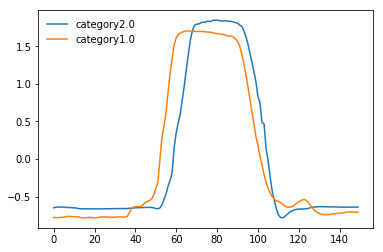

In [108]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [109]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    batch_size = int(min(x_train.shape[0]/10, 16))
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
     
   # x_test_min = np.min(x_test, axis = 1, keepdims=1)
   # x_test_max = np.max(x_test, axis = 1, keepdims=1)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    #x_train = x_train.reshape(x_train.shape + (1,))
    #x_test = x_test.reshape(x_test.shape + (1,))
    
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    duration_minutes = str(round((end-start)/60))
    print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')
    print('Selected the test result with the lowest training loss. Loss and accuracy are -')
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc)
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+  fname +'  |'+ timestamp + '  |' + duration_minutes + 'mins  |'
    # Save log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    return summary
 



# Train

In [110]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = KFold(k, True, k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
for each in results:
    print(each)
	

Running dataset GunPoint
Train on 150 samples, validate on 50 samples
Epoch 1/5000
 - 2s - loss: 0.6813 - acc: 0.5267 - val_loss: 0.6447 - val_acc: 0.6200
Epoch 2/5000
 - 0s - loss: 0.6373 - acc: 0.6400 - val_loss: 0.5660 - val_acc: 0.6400
Epoch 3/5000
 - 0s - loss: 0.5219 - acc: 0.7333 - val_loss: 0.4568 - val_acc: 0.6400
Epoch 4/5000
 - 0s - loss: 0.4514 - acc: 0.7400 - val_loss: 0.3569 - val_acc: 0.8800
Epoch 5/5000
 - 0s - loss: 0.4166 - acc: 0.7933 - val_loss: 0.3941 - val_acc: 0.6800
Epoch 6/5000
 - 0s - loss: 0.4257 - acc: 0.7800 - val_loss: 0.3294 - val_acc: 0.8800
Epoch 7/5000
 - 0s - loss: 0.3674 - acc: 0.7933 - val_loss: 0.3612 - val_acc: 0.7200
Epoch 8/5000
 - 0s - loss: 0.3442 - acc: 0.8067 - val_loss: 0.5101 - val_acc: 0.8200
Epoch 9/5000
 - 0s - loss: 0.4084 - acc: 0.7933 - val_loss: 0.3117 - val_acc: 0.8200
Epoch 10/5000
 - 0s - loss: 0.3323 - acc: 0.8000 - val_loss: 0.3136 - val_acc: 0.8000
Epoch 11/5000
 - 0s - loss: 0.3082 - acc: 0.8400 - val_loss: 0.2783 - val_acc: 

Epoch 96/5000
 - 0s - loss: 0.0218 - acc: 0.9933 - val_loss: 0.0183 - val_acc: 1.0000
Epoch 97/5000
 - 0s - loss: 0.0224 - acc: 0.9933 - val_loss: 0.0184 - val_acc: 0.9800
Epoch 98/5000
 - 0s - loss: 0.0228 - acc: 0.9867 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 99/5000
 - 0s - loss: 0.0193 - acc: 0.9933 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 100/5000
 - 0s - loss: 0.0209 - acc: 0.9867 - val_loss: 0.0508 - val_acc: 0.9800
Epoch 101/5000
 - 0s - loss: 0.0190 - acc: 0.9933 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 102/5000
 - 0s - loss: 0.0273 - acc: 0.9800 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 103/5000
 - 0s - loss: 0.0301 - acc: 0.9867 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 104/5000
 - 0s - loss: 0.0114 - acc: 0.9933 - val_loss: 0.0281 - val_acc: 0.9800
Epoch 105/5000
 - 0s - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0164 - val_acc: 1.0000
Epoch 106/5000
 - 0s - loss: 0.0342 - acc: 0.9800 - val_loss: 0.1603 - val_acc: 0.9600
Epoch 107/5000
 - 0s - loss: 0.0306 - acc: 0.98

 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 191/5000
 - 0s - loss: 6.1615e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 192/5000
 - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 193/5000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 194/5000
 - 0s - loss: 0.0148 - acc: 0.9933 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 195/5000
 - 0s - loss: 0.0085 - acc: 0.9933 - val_loss: 0.0322 - val_acc: 0.9800
Epoch 196/5000
 - 0s - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 1.0000
Epoch 197/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 198/5000
 - 0s - loss: 0.0078 - acc: 0.9933 - val_loss: 0.0242 - val_acc: 0.9800
Epoch 199/5000
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 200/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 201/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - va

Epoch 282/5000
 - 0s - loss: 1.0728e-04 - acc: 1.0000 - val_loss: 5.2867e-04 - val_acc: 1.0000
Epoch 283/5000
 - 0s - loss: 1.3815e-04 - acc: 1.0000 - val_loss: 5.1488e-04 - val_acc: 1.0000
Epoch 284/5000
 - 0s - loss: 3.1176e-04 - acc: 1.0000 - val_loss: 7.2542e-04 - val_acc: 1.0000
Epoch 285/5000
 - 0s - loss: 2.8494e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 286/5000
 - 0s - loss: 1.0694e-04 - acc: 1.0000 - val_loss: 7.1219e-04 - val_acc: 1.0000
Epoch 287/5000
 - 0s - loss: 7.9871e-05 - acc: 1.0000 - val_loss: 5.9616e-04 - val_acc: 1.0000
Epoch 288/5000
 - 0s - loss: 5.0997e-04 - acc: 1.0000 - val_loss: 8.4037e-04 - val_acc: 1.0000
Epoch 289/5000
 - 0s - loss: 3.3576e-05 - acc: 1.0000 - val_loss: 8.2943e-04 - val_acc: 1.0000
Epoch 290/5000
 - 0s - loss: 1.0053e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 291/5000
 - 0s - loss: 3.6656e-04 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9600
Epoch 292/5000
 - 0s - loss: 3.5367e-04 - acc: 1.0000 - val_lo

Epoch 371/5000
 - 0s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 372/5000
 - 0s - loss: 1.0140e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 373/5000
 - 0s - loss: 1.4018e-04 - acc: 1.0000 - val_loss: 2.2396e-04 - val_acc: 1.0000
Epoch 374/5000
 - 0s - loss: 1.8303e-05 - acc: 1.0000 - val_loss: 1.6983e-04 - val_acc: 1.0000
Epoch 375/5000
 - 0s - loss: 3.7674e-04 - acc: 1.0000 - val_loss: 3.3586e-04 - val_acc: 1.0000
Epoch 376/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 377/5000
 - 0s - loss: 7.2690e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 378/5000
 - 0s - loss: 4.4697e-04 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 379/5000
 - 0s - loss: 1.0417e-05 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 380/5000
 - 0s - loss: 3.0077e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 381/5000
 - 0s - loss: 6.9552e-05 - acc: 1.0000 - val_loss: 3.9041e-04 - val_acc

Epoch 461/5000
 - 0s - loss: 1.4475e-05 - acc: 1.0000 - val_loss: 2.7216e-04 - val_acc: 1.0000
Epoch 462/5000
 - 0s - loss: 3.2157e-05 - acc: 1.0000 - val_loss: 3.8541e-04 - val_acc: 1.0000
Epoch 463/5000
 - 0s - loss: 6.4736e-05 - acc: 1.0000 - val_loss: 3.2352e-04 - val_acc: 1.0000
Epoch 464/5000
 - 0s - loss: 9.5829e-06 - acc: 1.0000 - val_loss: 2.8391e-04 - val_acc: 1.0000
Epoch 465/5000
 - 0s - loss: 1.3002e-05 - acc: 1.0000 - val_loss: 5.6443e-04 - val_acc: 1.0000
Epoch 466/5000
 - 0s - loss: 5.3938e-06 - acc: 1.0000 - val_loss: 4.3672e-04 - val_acc: 1.0000
Epoch 467/5000
 - 0s - loss: 7.5738e-06 - acc: 1.0000 - val_loss: 2.8035e-04 - val_acc: 1.0000
Epoch 468/5000
 - 0s - loss: 8.6314e-06 - acc: 1.0000 - val_loss: 1.7795e-04 - val_acc: 1.0000
Epoch 469/5000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 470/5000
 - 0s - loss: 2.1501e-04 - acc: 1.0000 - val_loss: 8.1853e-05 - val_acc: 1.0000
Epoch 471/5000
 - 0s - loss: 1.5571e-05 - acc: 1.0000 - va

Epoch 548/5000
 - 0s - loss: 1.9551e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 549/5000
 - 0s - loss: 5.6422e-06 - acc: 1.0000 - val_loss: 5.1565e-04 - val_acc: 1.0000
Epoch 550/5000
 - 0s - loss: 2.5615e-06 - acc: 1.0000 - val_loss: 4.4948e-04 - val_acc: 1.0000
Epoch 551/5000
 - 0s - loss: 5.0530e-05 - acc: 1.0000 - val_loss: 2.7422e-04 - val_acc: 1.0000
Epoch 552/5000
 - 0s - loss: 9.8392e-06 - acc: 1.0000 - val_loss: 2.2551e-04 - val_acc: 1.0000
Epoch 553/5000
 - 0s - loss: 3.6519e-06 - acc: 1.0000 - val_loss: 2.0209e-04 - val_acc: 1.0000
Epoch 554/5000
 - 0s - loss: 7.0990e-06 - acc: 1.0000 - val_loss: 3.0393e-04 - val_acc: 1.0000
Epoch 555/5000
 - 0s - loss: 1.1970e-05 - acc: 1.0000 - val_loss: 1.7132e-04 - val_acc: 1.0000
Epoch 556/5000
 - 0s - loss: 1.3217e-06 - acc: 1.0000 - val_loss: 1.7880e-04 - val_acc: 1.0000
Epoch 557/5000
 - 0s - loss: 3.4641e-06 - acc: 1.0000 - val_loss: 2.4096e-04 - val_acc: 1.0000
Epoch 558/5000
 - 0s - loss: 1.0876e-05 - acc: 1.0000 

Epoch 635/5000
 - 0s - loss: 1.2402e-06 - acc: 1.0000 - val_loss: 1.9118e-04 - val_acc: 1.0000
Epoch 636/5000
 - 0s - loss: 1.7759e-06 - acc: 1.0000 - val_loss: 1.8918e-04 - val_acc: 1.0000
Epoch 637/5000
 - 0s - loss: 1.0916e-05 - acc: 1.0000 - val_loss: 2.0257e-04 - val_acc: 1.0000
Epoch 638/5000
 - 0s - loss: 3.3934e-05 - acc: 1.0000 - val_loss: 4.4119e-04 - val_acc: 1.0000
Epoch 639/5000
 - 0s - loss: 1.1244e-05 - acc: 1.0000 - val_loss: 3.0364e-04 - val_acc: 1.0000
Epoch 640/5000
 - 0s - loss: 6.0646e-05 - acc: 1.0000 - val_loss: 9.1500e-04 - val_acc: 1.0000
Epoch 641/5000
 - 0s - loss: 5.8654e-06 - acc: 1.0000 - val_loss: 8.8544e-04 - val_acc: 1.0000
Epoch 642/5000
 - 0s - loss: 2.3980e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 643/5000
 - 0s - loss: 3.4340e-06 - acc: 1.0000 - val_loss: 8.7952e-04 - val_acc: 1.0000
Epoch 644/5000
 - 0s - loss: 3.4072e-06 - acc: 1.0000 - val_loss: 7.9300e-04 - val_acc: 1.0000
Epoch 645/5000
 - 0s - loss: 1.2202e-05 - acc: 1.0000 

Epoch 722/5000
 - 0s - loss: 1.7322e-06 - acc: 1.0000 - val_loss: 2.3883e-04 - val_acc: 1.0000
Epoch 723/5000
 - 0s - loss: 6.1484e-06 - acc: 1.0000 - val_loss: 1.6898e-04 - val_acc: 1.0000
Epoch 724/5000
 - 0s - loss: 1.2064e-06 - acc: 1.0000 - val_loss: 1.7574e-04 - val_acc: 1.0000
Epoch 725/5000
 - 0s - loss: 2.2520e-06 - acc: 1.0000 - val_loss: 2.0453e-04 - val_acc: 1.0000
Epoch 726/5000
 - 0s - loss: 6.2610e-06 - acc: 1.0000 - val_loss: 2.5022e-04 - val_acc: 1.0000
Epoch 727/5000
 - 0s - loss: 4.5242e-06 - acc: 1.0000 - val_loss: 1.9102e-04 - val_acc: 1.0000
Epoch 728/5000
 - 0s - loss: 1.5983e-06 - acc: 1.0000 - val_loss: 1.8170e-04 - val_acc: 1.0000
Epoch 729/5000
 - 0s - loss: 6.2655e-06 - acc: 1.0000 - val_loss: 1.4880e-04 - val_acc: 1.0000
Epoch 730/5000
 - 0s - loss: 2.6657e-06 - acc: 1.0000 - val_loss: 1.6320e-04 - val_acc: 1.0000
Epoch 731/5000
 - 0s - loss: 4.7712e-05 - acc: 1.0000 - val_loss: 3.3586e-04 - val_acc: 1.0000
Epoch 732/5000
 - 0s - loss: 1.2366e-06 - acc: 1.0

Epoch 809/5000
 - 0s - loss: 5.2420e-05 - acc: 1.0000 - val_loss: 1.4475e-04 - val_acc: 1.0000
Epoch 810/5000
 - 0s - loss: 3.0007e-06 - acc: 1.0000 - val_loss: 1.5491e-04 - val_acc: 1.0000
Epoch 811/5000
 - 0s - loss: 7.4420e-06 - acc: 1.0000 - val_loss: 1.1029e-04 - val_acc: 1.0000
Epoch 812/5000
 - 0s - loss: 2.9416e-05 - acc: 1.0000 - val_loss: 2.5574e-04 - val_acc: 1.0000
Epoch 813/5000
 - 0s - loss: 6.8912e-06 - acc: 1.0000 - val_loss: 3.1375e-04 - val_acc: 1.0000
Epoch 814/5000
 - 0s - loss: 9.2529e-06 - acc: 1.0000 - val_loss: 3.3320e-04 - val_acc: 1.0000
Epoch 815/5000
 - 0s - loss: 2.8789e-06 - acc: 1.0000 - val_loss: 2.8912e-04 - val_acc: 1.0000
Epoch 816/5000
 - 0s - loss: 9.0521e-07 - acc: 1.0000 - val_loss: 3.0375e-04 - val_acc: 1.0000
Epoch 817/5000
 - 0s - loss: 3.4351e-06 - acc: 1.0000 - val_loss: 2.2820e-04 - val_acc: 1.0000
Epoch 818/5000
 - 0s - loss: 5.8928e-06 - acc: 1.0000 - val_loss: 1.3732e-04 - val_acc: 1.0000
Epoch 819/5000
 - 0s - loss: 9.2810e-05 - acc: 1.0

Epoch 896/5000
 - 0s - loss: 9.9713e-06 - acc: 1.0000 - val_loss: 3.2633e-04 - val_acc: 1.0000
Epoch 897/5000
 - 0s - loss: 1.9241e-06 - acc: 1.0000 - val_loss: 3.3198e-04 - val_acc: 1.0000
Epoch 898/5000
 - 0s - loss: 1.5533e-06 - acc: 1.0000 - val_loss: 3.1425e-04 - val_acc: 1.0000
Epoch 899/5000
 - 0s - loss: 7.4546e-07 - acc: 1.0000 - val_loss: 3.1071e-04 - val_acc: 1.0000
Epoch 900/5000
 - 0s - loss: 2.0076e-06 - acc: 1.0000 - val_loss: 2.9490e-04 - val_acc: 1.0000
Epoch 901/5000
 - 0s - loss: 4.3325e-06 - acc: 1.0000 - val_loss: 3.0409e-04 - val_acc: 1.0000
Epoch 902/5000
 - 0s - loss: 2.6080e-06 - acc: 1.0000 - val_loss: 2.8357e-04 - val_acc: 1.0000
Epoch 903/5000
 - 0s - loss: 1.7525e-06 - acc: 1.0000 - val_loss: 2.7379e-04 - val_acc: 1.0000
Epoch 904/5000
 - 0s - loss: 2.0270e-06 - acc: 1.0000 - val_loss: 2.5404e-04 - val_acc: 1.0000
Epoch 905/5000
 - 0s - loss: 1.2148e-06 - acc: 1.0000 - val_loss: 2.5158e-04 - val_acc: 1.0000
Epoch 906/5000
 - 0s - loss: 3.2209e-06 - acc: 1.0

Epoch 983/5000
 - 0s - loss: 2.4701e-06 - acc: 1.0000 - val_loss: 1.9159e-04 - val_acc: 1.0000
Epoch 984/5000
 - 0s - loss: 2.3064e-06 - acc: 1.0000 - val_loss: 1.9070e-04 - val_acc: 1.0000
Epoch 985/5000
 - 0s - loss: 8.3382e-06 - acc: 1.0000 - val_loss: 2.0795e-04 - val_acc: 1.0000
Epoch 986/5000
 - 0s - loss: 4.0973e-06 - acc: 1.0000 - val_loss: 1.9710e-04 - val_acc: 1.0000
Epoch 987/5000
 - 0s - loss: 3.0051e-06 - acc: 1.0000 - val_loss: 1.8983e-04 - val_acc: 1.0000
Epoch 988/5000
 - 0s - loss: 1.1261e-06 - acc: 1.0000 - val_loss: 1.8976e-04 - val_acc: 1.0000
Epoch 989/5000
 - 0s - loss: 2.1164e-06 - acc: 1.0000 - val_loss: 1.8591e-04 - val_acc: 1.0000
Epoch 990/5000
 - 0s - loss: 7.8307e-06 - acc: 1.0000 - val_loss: 2.2930e-04 - val_acc: 1.0000
Epoch 991/5000
 - 0s - loss: 2.8884e-06 - acc: 1.0000 - val_loss: 2.0854e-04 - val_acc: 1.0000
Epoch 992/5000
 - 0s - loss: 1.7763e-06 - acc: 1.0000 - val_loss: 1.9907e-04 - val_acc: 1.0000
Epoch 993/5000
 - 0s - loss: 1.0562e-06 - acc: 1.0

Epoch 1069/5000
 - 0s - loss: 1.6543e-06 - acc: 1.0000 - val_loss: 2.4820e-04 - val_acc: 1.0000
Epoch 1070/5000
 - 0s - loss: 1.4762e-06 - acc: 1.0000 - val_loss: 2.4789e-04 - val_acc: 1.0000
Epoch 1071/5000
 - 0s - loss: 9.7316e-07 - acc: 1.0000 - val_loss: 2.4884e-04 - val_acc: 1.0000
Epoch 1072/5000
 - 0s - loss: 1.9416e-06 - acc: 1.0000 - val_loss: 2.3500e-04 - val_acc: 1.0000
Epoch 1073/5000
 - 0s - loss: 3.3913e-06 - acc: 1.0000 - val_loss: 2.3547e-04 - val_acc: 1.0000
Epoch 1074/5000
 - 0s - loss: 1.0308e-06 - acc: 1.0000 - val_loss: 2.2992e-04 - val_acc: 1.0000
Epoch 1075/5000
 - 0s - loss: 1.6829e-06 - acc: 1.0000 - val_loss: 2.3611e-04 - val_acc: 1.0000
Epoch 1076/5000
 - 0s - loss: 2.4343e-06 - acc: 1.0000 - val_loss: 2.3436e-04 - val_acc: 1.0000
Epoch 1077/5000
 - 0s - loss: 2.0218e-06 - acc: 1.0000 - val_loss: 2.3963e-04 - val_acc: 1.0000
Epoch 1078/5000
 - 0s - loss: 9.2349e-07 - acc: 1.0000 - val_loss: 2.3697e-04 - val_acc: 1.0000
Epoch 1079/5000
 - 0s - loss: 3.3502e-06

Epoch 1155/5000
 - 0s - loss: 1.6920e-06 - acc: 1.0000 - val_loss: 1.7574e-04 - val_acc: 1.0000
Epoch 1156/5000
 - 0s - loss: 3.7852e-06 - acc: 1.0000 - val_loss: 1.9378e-04 - val_acc: 1.0000
Epoch 1157/5000
 - 0s - loss: 2.5716e-06 - acc: 1.0000 - val_loss: 2.0128e-04 - val_acc: 1.0000
Epoch 1158/5000
 - 0s - loss: 1.0689e-06 - acc: 1.0000 - val_loss: 2.0450e-04 - val_acc: 1.0000
Epoch 1159/5000
 - 0s - loss: 6.6738e-06 - acc: 1.0000 - val_loss: 2.6485e-04 - val_acc: 1.0000
Epoch 1160/5000
 - 0s - loss: 4.0915e-06 - acc: 1.0000 - val_loss: 2.5245e-04 - val_acc: 1.0000
Epoch 1161/5000
 - 0s - loss: 1.7127e-06 - acc: 1.0000 - val_loss: 2.5466e-04 - val_acc: 1.0000
Epoch 1162/5000
 - 0s - loss: 1.1393e-06 - acc: 1.0000 - val_loss: 2.5441e-04 - val_acc: 1.0000
Epoch 1163/5000
 - 0s - loss: 2.5067e-06 - acc: 1.0000 - val_loss: 2.4809e-04 - val_acc: 1.0000
Epoch 1164/5000
 - 0s - loss: 3.5382e-06 - acc: 1.0000 - val_loss: 2.3163e-04 - val_acc: 1.0000
Epoch 1165/5000
 - 0s - loss: 1.5045e-06

Epoch 1241/5000
 - 0s - loss: 1.6984e-06 - acc: 1.0000 - val_loss: 2.5431e-04 - val_acc: 1.0000
Epoch 1242/5000
 - 0s - loss: 5.3843e-07 - acc: 1.0000 - val_loss: 2.5328e-04 - val_acc: 1.0000
Epoch 1243/5000
 - 0s - loss: 3.3246e-06 - acc: 1.0000 - val_loss: 2.4719e-04 - val_acc: 1.0000
Epoch 1244/5000
 - 0s - loss: 1.1440e-06 - acc: 1.0000 - val_loss: 2.4828e-04 - val_acc: 1.0000
Epoch 1245/5000
 - 0s - loss: 1.2259e-06 - acc: 1.0000 - val_loss: 2.5185e-04 - val_acc: 1.0000
Epoch 1246/5000
 - 0s - loss: 1.8595e-05 - acc: 1.0000 - val_loss: 3.3374e-04 - val_acc: 1.0000
Epoch 1247/5000
 - 0s - loss: 2.6744e-06 - acc: 1.0000 - val_loss: 3.2080e-04 - val_acc: 1.0000
Epoch 1248/5000
 - 0s - loss: 2.6540e-05 - acc: 1.0000 - val_loss: 3.1716e-04 - val_acc: 1.0000
Epoch 1249/5000
 - 0s - loss: 3.1732e-06 - acc: 1.0000 - val_loss: 3.1026e-04 - val_acc: 1.0000
Epoch 1250/5000
 - 0s - loss: 4.6214e-05 - acc: 1.0000 - val_loss: 2.1375e-04 - val_acc: 1.0000
Epoch 1251/5000
 - 0s - loss: 2.9105e-06

Epoch 1327/5000
 - 0s - loss: 2.7427e-06 - acc: 1.0000 - val_loss: 2.8285e-04 - val_acc: 1.0000
Epoch 1328/5000
 - 0s - loss: 2.6327e-06 - acc: 1.0000 - val_loss: 2.5850e-04 - val_acc: 1.0000
Epoch 1329/5000
 - 0s - loss: 1.8410e-06 - acc: 1.0000 - val_loss: 2.5707e-04 - val_acc: 1.0000
Epoch 1330/5000
 - 0s - loss: 5.6333e-06 - acc: 1.0000 - val_loss: 2.1058e-04 - val_acc: 1.0000
Epoch 1331/5000
 - 0s - loss: 1.9599e-06 - acc: 1.0000 - val_loss: 2.0369e-04 - val_acc: 1.0000
Epoch 1332/5000
 - 0s - loss: 1.8283e-06 - acc: 1.0000 - val_loss: 2.0111e-04 - val_acc: 1.0000
Epoch 1333/5000
 - 0s - loss: 1.5525e-06 - acc: 1.0000 - val_loss: 2.0801e-04 - val_acc: 1.0000
Epoch 1334/5000
 - 0s - loss: 3.4613e-06 - acc: 1.0000 - val_loss: 2.0124e-04 - val_acc: 1.0000
Epoch 1335/5000
 - 0s - loss: 1.5796e-06 - acc: 1.0000 - val_loss: 1.9836e-04 - val_acc: 1.0000
Epoch 1336/5000
 - 0s - loss: 9.7276e-07 - acc: 1.0000 - val_loss: 1.9446e-04 - val_acc: 1.0000
Epoch 1337/5000
 - 0s - loss: 2.7601e-06

Epoch 1413/5000
 - 0s - loss: 1.1663e-06 - acc: 1.0000 - val_loss: 3.2453e-04 - val_acc: 1.0000
Epoch 1414/5000
 - 0s - loss: 1.8816e-06 - acc: 1.0000 - val_loss: 3.1963e-04 - val_acc: 1.0000
Epoch 1415/5000
 - 0s - loss: 4.2486e-06 - acc: 1.0000 - val_loss: 3.7092e-04 - val_acc: 1.0000
Epoch 1416/5000
 - 0s - loss: 5.7101e-07 - acc: 1.0000 - val_loss: 3.6940e-04 - val_acc: 1.0000
Epoch 1417/5000
 - 0s - loss: 1.4723e-06 - acc: 1.0000 - val_loss: 3.5832e-04 - val_acc: 1.0000
Epoch 1418/5000
 - 0s - loss: 2.6677e-06 - acc: 1.0000 - val_loss: 3.3546e-04 - val_acc: 1.0000
Epoch 1419/5000
 - 0s - loss: 3.4371e-06 - acc: 1.0000 - val_loss: 3.4321e-04 - val_acc: 1.0000
Epoch 1420/5000
 - 0s - loss: 1.1365e-06 - acc: 1.0000 - val_loss: 3.3371e-04 - val_acc: 1.0000
Epoch 1421/5000
 - 0s - loss: 2.9690e-06 - acc: 1.0000 - val_loss: 3.5841e-04 - val_acc: 1.0000
Epoch 1422/5000
 - 0s - loss: 8.2931e-07 - acc: 1.0000 - val_loss: 3.6098e-04 - val_acc: 1.0000
Epoch 1423/5000
 - 0s - loss: 1.2764e-06

Epoch 1499/5000
 - 0s - loss: 1.6849e-06 - acc: 1.0000 - val_loss: 2.1096e-04 - val_acc: 1.0000
Epoch 1500/5000
 - 0s - loss: 4.5882e-06 - acc: 1.0000 - val_loss: 1.8242e-04 - val_acc: 1.0000
Epoch 1501/5000
 - 0s - loss: 1.3932e-06 - acc: 1.0000 - val_loss: 1.7919e-04 - val_acc: 1.0000
Epoch 1502/5000
 - 0s - loss: 5.1968e-06 - acc: 1.0000 - val_loss: 1.6375e-04 - val_acc: 1.0000
Epoch 1503/5000
 - 0s - loss: 6.7738e-06 - acc: 1.0000 - val_loss: 2.0811e-04 - val_acc: 1.0000
Epoch 1504/5000
 - 0s - loss: 1.7167e-06 - acc: 1.0000 - val_loss: 2.1697e-04 - val_acc: 1.0000
Epoch 1505/5000
 - 0s - loss: 6.1757e-06 - acc: 1.0000 - val_loss: 2.1618e-04 - val_acc: 1.0000
Epoch 1506/5000
 - 0s - loss: 4.0033e-06 - acc: 1.0000 - val_loss: 2.0184e-04 - val_acc: 1.0000
Epoch 1507/5000
 - 0s - loss: 8.2454e-07 - acc: 1.0000 - val_loss: 2.0049e-04 - val_acc: 1.0000
Epoch 1508/5000
 - 0s - loss: 1.3153e-06 - acc: 1.0000 - val_loss: 1.9807e-04 - val_acc: 1.0000
Epoch 1509/5000
 - 0s - loss: 8.2533e-07

Epoch 1585/5000
 - 0s - loss: 1.6988e-06 - acc: 1.0000 - val_loss: 2.1661e-04 - val_acc: 1.0000
Epoch 1586/5000
 - 0s - loss: 2.8729e-06 - acc: 1.0000 - val_loss: 2.0897e-04 - val_acc: 1.0000
Epoch 1587/5000
 - 0s - loss: 6.8784e-07 - acc: 1.0000 - val_loss: 2.0868e-04 - val_acc: 1.0000
Epoch 1588/5000
 - 0s - loss: 6.3499e-07 - acc: 1.0000 - val_loss: 2.0656e-04 - val_acc: 1.0000
Epoch 1589/5000
 - 0s - loss: 4.0036e-06 - acc: 1.0000 - val_loss: 2.2255e-04 - val_acc: 1.0000
Epoch 1590/5000
 - 0s - loss: 7.8019e-06 - acc: 1.0000 - val_loss: 1.7452e-04 - val_acc: 1.0000
Epoch 1591/5000
 - 0s - loss: 7.3871e-07 - acc: 1.0000 - val_loss: 1.7462e-04 - val_acc: 1.0000
Epoch 1592/5000
 - 0s - loss: 1.8439e-05 - acc: 1.0000 - val_loss: 1.7790e-04 - val_acc: 1.0000
Epoch 1593/5000
 - 0s - loss: 7.7851e-06 - acc: 1.0000 - val_loss: 1.5232e-04 - val_acc: 1.0000
Epoch 1594/5000
 - 0s - loss: 9.8587e-07 - acc: 1.0000 - val_loss: 1.5441e-04 - val_acc: 1.0000
Epoch 1595/5000
 - 0s - loss: 1.3745e-06

Epoch 1671/5000
 - 0s - loss: 5.5559e-06 - acc: 1.0000 - val_loss: 2.1878e-04 - val_acc: 1.0000
Epoch 1672/5000
 - 0s - loss: 1.7906e-06 - acc: 1.0000 - val_loss: 2.2048e-04 - val_acc: 1.0000
Epoch 1673/5000
 - 0s - loss: 1.1818e-06 - acc: 1.0000 - val_loss: 2.1114e-04 - val_acc: 1.0000
Epoch 1674/5000
 - 0s - loss: 1.0423e-06 - acc: 1.0000 - val_loss: 2.1138e-04 - val_acc: 1.0000
Epoch 1675/5000
 - 0s - loss: 1.1393e-06 - acc: 1.0000 - val_loss: 2.1102e-04 - val_acc: 1.0000
Epoch 1676/5000
 - 0s - loss: 3.1169e-06 - acc: 1.0000 - val_loss: 2.1108e-04 - val_acc: 1.0000
Epoch 1677/5000
 - 0s - loss: 2.3818e-05 - acc: 1.0000 - val_loss: 2.2086e-04 - val_acc: 1.0000
Epoch 1678/5000
 - 0s - loss: 1.1524e-06 - acc: 1.0000 - val_loss: 2.1884e-04 - val_acc: 1.0000
Epoch 1679/5000
 - 0s - loss: 3.2300e-06 - acc: 1.0000 - val_loss: 2.5070e-04 - val_acc: 1.0000
Epoch 1680/5000
 - 0s - loss: 5.8611e-06 - acc: 1.0000 - val_loss: 2.9915e-04 - val_acc: 1.0000
Epoch 1681/5000
 - 0s - loss: 4.6456e-06

Epoch 1757/5000
 - 0s - loss: 4.2849e-06 - acc: 1.0000 - val_loss: 1.9309e-04 - val_acc: 1.0000
Epoch 1758/5000
 - 0s - loss: 2.1248e-06 - acc: 1.0000 - val_loss: 1.8834e-04 - val_acc: 1.0000
Epoch 1759/5000
 - 0s - loss: 6.5923e-07 - acc: 1.0000 - val_loss: 1.8865e-04 - val_acc: 1.0000
Epoch 1760/5000
 - 0s - loss: 1.0256e-05 - acc: 1.0000 - val_loss: 2.1933e-04 - val_acc: 1.0000
Epoch 1761/5000
 - 0s - loss: 1.4556e-06 - acc: 1.0000 - val_loss: 2.1777e-04 - val_acc: 1.0000
Epoch 1762/5000
 - 0s - loss: 7.1327e-07 - acc: 1.0000 - val_loss: 2.1768e-04 - val_acc: 1.0000
Epoch 1763/5000
 - 0s - loss: 6.3698e-07 - acc: 1.0000 - val_loss: 2.1704e-04 - val_acc: 1.0000
Epoch 1764/5000
 - 0s - loss: 3.9523e-06 - acc: 1.0000 - val_loss: 2.0436e-04 - val_acc: 1.0000
Epoch 1765/5000
 - 0s - loss: 4.1213e-05 - acc: 1.0000 - val_loss: 1.4784e-04 - val_acc: 1.0000
Epoch 1766/5000
 - 0s - loss: 5.6026e-06 - acc: 1.0000 - val_loss: 1.4470e-04 - val_acc: 1.0000
Epoch 1767/5000
 - 0s - loss: 1.8033e-06

Epoch 1843/5000
 - 0s - loss: 4.3216e-06 - acc: 1.0000 - val_loss: 1.0830e-04 - val_acc: 1.0000
Epoch 1844/5000
 - 0s - loss: 1.4289e-06 - acc: 1.0000 - val_loss: 1.1001e-04 - val_acc: 1.0000
Epoch 1845/5000
 - 0s - loss: 2.4272e-04 - acc: 1.0000 - val_loss: 2.1058e-04 - val_acc: 1.0000
Epoch 1846/5000
 - 0s - loss: 2.3815e-06 - acc: 1.0000 - val_loss: 2.0272e-04 - val_acc: 1.0000
Epoch 1847/5000
 - 0s - loss: 8.5275e-07 - acc: 1.0000 - val_loss: 2.0178e-04 - val_acc: 1.0000
Epoch 1848/5000
 - 0s - loss: 4.4370e-06 - acc: 1.0000 - val_loss: 1.8300e-04 - val_acc: 1.0000
Epoch 1849/5000
 - 0s - loss: 1.6928e-06 - acc: 1.0000 - val_loss: 1.8052e-04 - val_acc: 1.0000
Epoch 1850/5000
 - 0s - loss: 6.9844e-06 - acc: 1.0000 - val_loss: 1.6363e-04 - val_acc: 1.0000
Epoch 1851/5000
 - 0s - loss: 2.9737e-06 - acc: 1.0000 - val_loss: 1.6551e-04 - val_acc: 1.0000
Epoch 1852/5000
 - 0s - loss: 8.3169e-07 - acc: 1.0000 - val_loss: 1.6627e-04 - val_acc: 1.0000
Epoch 1853/5000
 - 0s - loss: 1.4103e-06

Epoch 1929/5000
 - 0s - loss: 4.1676e-06 - acc: 1.0000 - val_loss: 2.0688e-04 - val_acc: 1.0000
Epoch 1930/5000
 - 0s - loss: 2.1757e-06 - acc: 1.0000 - val_loss: 1.9885e-04 - val_acc: 1.0000
Epoch 1931/5000
 - 0s - loss: 3.9101e-07 - acc: 1.0000 - val_loss: 1.9795e-04 - val_acc: 1.0000
Epoch 1932/5000
 - 0s - loss: 2.6908e-06 - acc: 1.0000 - val_loss: 1.9225e-04 - val_acc: 1.0000
Epoch 1933/5000
 - 0s - loss: 2.1943e-06 - acc: 1.0000 - val_loss: 1.9909e-04 - val_acc: 1.0000
Epoch 1934/5000
 - 0s - loss: 2.8711e-06 - acc: 1.0000 - val_loss: 1.8523e-04 - val_acc: 1.0000
Epoch 1935/5000
 - 0s - loss: 2.9631e-06 - acc: 1.0000 - val_loss: 1.6962e-04 - val_acc: 1.0000
Epoch 1936/5000
 - 0s - loss: 4.6668e-06 - acc: 1.0000 - val_loss: 1.7614e-04 - val_acc: 1.0000
Epoch 1937/5000
 - 0s - loss: 1.4079e-06 - acc: 1.0000 - val_loss: 1.7975e-04 - val_acc: 1.0000
Epoch 1938/5000
 - 0s - loss: 1.8053e-06 - acc: 1.0000 - val_loss: 1.7689e-04 - val_acc: 1.0000
Epoch 1939/5000
 - 0s - loss: 3.4113e-06

Epoch 2015/5000
 - 0s - loss: 6.8705e-07 - acc: 1.0000 - val_loss: 2.1184e-04 - val_acc: 1.0000
Epoch 2016/5000
 - 0s - loss: 3.9578e-06 - acc: 1.0000 - val_loss: 1.8515e-04 - val_acc: 1.0000
Epoch 2017/5000
 - 0s - loss: 4.9830e-06 - acc: 1.0000 - val_loss: 1.7761e-04 - val_acc: 1.0000
Epoch 2018/5000
 - 0s - loss: 1.4584e-06 - acc: 1.0000 - val_loss: 1.6625e-04 - val_acc: 1.0000
Epoch 2019/5000
 - 0s - loss: 3.1003e-06 - acc: 1.0000 - val_loss: 1.7802e-04 - val_acc: 1.0000
Epoch 2020/5000
 - 0s - loss: 3.1754e-06 - acc: 1.0000 - val_loss: 1.6418e-04 - val_acc: 1.0000
Epoch 2021/5000
 - 0s - loss: 7.2241e-07 - acc: 1.0000 - val_loss: 1.6387e-04 - val_acc: 1.0000
Epoch 2022/5000
 - 0s - loss: 1.6197e-06 - acc: 1.0000 - val_loss: 1.6892e-04 - val_acc: 1.0000
Epoch 2023/5000
 - 0s - loss: 1.0026e-06 - acc: 1.0000 - val_loss: 1.6810e-04 - val_acc: 1.0000
Epoch 2024/5000
 - 0s - loss: 1.9130e-06 - acc: 1.0000 - val_loss: 1.7375e-04 - val_acc: 1.0000
Epoch 2025/5000
 - 0s - loss: 1.2235e-06

Epoch 2101/5000
 - 0s - loss: 1.7966e-06 - acc: 1.0000 - val_loss: 7.2581e-04 - val_acc: 1.0000
Epoch 2102/5000
 - 0s - loss: 3.4486e-06 - acc: 1.0000 - val_loss: 6.4915e-04 - val_acc: 1.0000
Epoch 2103/5000
 - 0s - loss: 1.1715e-06 - acc: 1.0000 - val_loss: 6.5771e-04 - val_acc: 1.0000
Epoch 2104/5000
 - 0s - loss: 1.4592e-06 - acc: 1.0000 - val_loss: 6.2858e-04 - val_acc: 1.0000
Epoch 2105/5000
 - 0s - loss: 9.2188e-06 - acc: 1.0000 - val_loss: 4.3825e-04 - val_acc: 1.0000
Epoch 2106/5000
 - 0s - loss: 1.4250e-05 - acc: 1.0000 - val_loss: 2.1431e-04 - val_acc: 1.0000
Epoch 2107/5000
 - 0s - loss: 1.4592e-06 - acc: 1.0000 - val_loss: 2.1105e-04 - val_acc: 1.0000
Epoch 2108/5000
 - 0s - loss: 9.6403e-07 - acc: 1.0000 - val_loss: 2.0473e-04 - val_acc: 1.0000
Epoch 2109/5000
 - 0s - loss: 6.7663e-06 - acc: 1.0000 - val_loss: 1.6781e-04 - val_acc: 1.0000
Epoch 2110/5000
 - 0s - loss: 1.9226e-06 - acc: 1.0000 - val_loss: 1.7256e-04 - val_acc: 1.0000
Epoch 2111/5000
 - 0s - loss: 1.6797e-06

Epoch 2187/5000
 - 0s - loss: 1.5979e-06 - acc: 1.0000 - val_loss: 1.8375e-04 - val_acc: 1.0000
Epoch 2188/5000
 - 0s - loss: 1.3805e-06 - acc: 1.0000 - val_loss: 1.8278e-04 - val_acc: 1.0000
Epoch 2189/5000
 - 0s - loss: 1.2219e-06 - acc: 1.0000 - val_loss: 1.8169e-04 - val_acc: 1.0000
Epoch 2190/5000
 - 0s - loss: 3.2632e-06 - acc: 1.0000 - val_loss: 1.6814e-04 - val_acc: 1.0000
Epoch 2191/5000
 - 0s - loss: 3.0473e-06 - acc: 1.0000 - val_loss: 1.7927e-04 - val_acc: 1.0000
Epoch 2192/5000
 - 0s - loss: 3.1391e-06 - acc: 1.0000 - val_loss: 1.7710e-04 - val_acc: 1.0000
Epoch 2193/5000
 - 0s - loss: 1.0741e-06 - acc: 1.0000 - val_loss: 1.7912e-04 - val_acc: 1.0000
Epoch 2194/5000
 - 0s - loss: 1.4900e-05 - acc: 1.0000 - val_loss: 2.4894e-04 - val_acc: 1.0000
Epoch 2195/5000
 - 0s - loss: 1.5243e-06 - acc: 1.0000 - val_loss: 2.4625e-04 - val_acc: 1.0000
Epoch 2196/5000
 - 0s - loss: 1.3932e-06 - acc: 1.0000 - val_loss: 2.4383e-04 - val_acc: 1.0000
Epoch 2197/5000
 - 0s - loss: 4.4267e-07

Epoch 2273/5000
 - 0s - loss: 1.5458e-06 - acc: 1.0000 - val_loss: 2.9207e-04 - val_acc: 1.0000
Epoch 2274/5000
 - 0s - loss: 7.6431e-06 - acc: 1.0000 - val_loss: 2.8879e-04 - val_acc: 1.0000
Epoch 2275/5000
 - 0s - loss: 2.6716e-06 - acc: 1.0000 - val_loss: 2.6917e-04 - val_acc: 1.0000
Epoch 2276/5000
 - 0s - loss: 1.8626e-06 - acc: 1.0000 - val_loss: 2.8518e-04 - val_acc: 1.0000
Epoch 2277/5000
 - 0s - loss: 3.7022e-06 - acc: 1.0000 - val_loss: 2.8749e-04 - val_acc: 1.0000
Epoch 2278/5000
 - 0s - loss: 3.8518e-06 - acc: 1.0000 - val_loss: 2.5710e-04 - val_acc: 1.0000
Epoch 2279/5000
 - 0s - loss: 2.2075e-06 - acc: 1.0000 - val_loss: 2.4913e-04 - val_acc: 1.0000
Epoch 2280/5000
 - 0s - loss: 3.0174e-06 - acc: 1.0000 - val_loss: 2.4443e-04 - val_acc: 1.0000
Epoch 2281/5000
 - 0s - loss: 7.6334e-07 - acc: 1.0000 - val_loss: 2.4483e-04 - val_acc: 1.0000
Epoch 2282/5000
 - 0s - loss: 1.2537e-06 - acc: 1.0000 - val_loss: 2.5004e-04 - val_acc: 1.0000
Epoch 2283/5000
 - 0s - loss: 2.4261e-06

Epoch 2359/5000
 - 0s - loss: 1.4079e-06 - acc: 1.0000 - val_loss: 2.1558e-04 - val_acc: 1.0000
Epoch 2360/5000
 - 0s - loss: 1.9193e-06 - acc: 1.0000 - val_loss: 2.1469e-04 - val_acc: 1.0000
Epoch 2361/5000
 - 0s - loss: 1.7389e-06 - acc: 1.0000 - val_loss: 2.0995e-04 - val_acc: 1.0000
Epoch 2362/5000
 - 0s - loss: 3.8950e-06 - acc: 1.0000 - val_loss: 1.8828e-04 - val_acc: 1.0000
Epoch 2363/5000
 - 0s - loss: 1.6360e-06 - acc: 1.0000 - val_loss: 1.9162e-04 - val_acc: 1.0000
Epoch 2364/5000
 - 0s - loss: 6.6281e-07 - acc: 1.0000 - val_loss: 1.9064e-04 - val_acc: 1.0000
Epoch 2365/5000
 - 0s - loss: 4.4392e-06 - acc: 1.0000 - val_loss: 1.6744e-04 - val_acc: 1.0000
Epoch 2366/5000
 - 0s - loss: 1.7894e-06 - acc: 1.0000 - val_loss: 1.6703e-04 - val_acc: 1.0000
Epoch 2367/5000
 - 0s - loss: 2.6057e-06 - acc: 1.0000 - val_loss: 1.7227e-04 - val_acc: 1.0000
Epoch 2368/5000
 - 0s - loss: 1.9873e-06 - acc: 1.0000 - val_loss: 1.7723e-04 - val_acc: 1.0000
Epoch 2369/5000
 - 0s - loss: 8.0042e-06

Epoch 2445/5000
 - 0s - loss: 6.6281e-07 - acc: 1.0000 - val_loss: 1.3799e-04 - val_acc: 1.0000
Epoch 2446/5000
 - 0s - loss: 1.6635e-06 - acc: 1.0000 - val_loss: 1.3456e-04 - val_acc: 1.0000
Epoch 2447/5000
 - 0s - loss: 5.8726e-06 - acc: 1.0000 - val_loss: 1.5199e-04 - val_acc: 1.0000
Epoch 2448/5000
 - 0s - loss: 5.2770e-07 - acc: 1.0000 - val_loss: 1.5106e-04 - val_acc: 1.0000
Epoch 2449/5000
 - 0s - loss: 7.3116e-07 - acc: 1.0000 - val_loss: 1.4874e-04 - val_acc: 1.0000
Epoch 2450/5000
 - 0s - loss: 5.6073e-05 - acc: 1.0000 - val_loss: 1.7833e-04 - val_acc: 1.0000
Epoch 2451/5000
 - 0s - loss: 1.1993e-06 - acc: 1.0000 - val_loss: 1.7813e-04 - val_acc: 1.0000
Epoch 2452/5000
 - 0s - loss: 2.7709e-06 - acc: 1.0000 - val_loss: 1.6763e-04 - val_acc: 1.0000
Epoch 2453/5000
 - 0s - loss: 6.9023e-07 - acc: 1.0000 - val_loss: 1.6699e-04 - val_acc: 1.0000
Epoch 2454/5000
 - 0s - loss: 7.3473e-07 - acc: 1.0000 - val_loss: 1.6696e-04 - val_acc: 1.0000
Epoch 2455/5000
 - 0s - loss: 8.5673e-07

Epoch 2531/5000
 - 0s - loss: 2.9408e-06 - acc: 1.0000 - val_loss: 1.6217e-04 - val_acc: 1.0000
Epoch 2532/5000
 - 0s - loss: 1.4508e-06 - acc: 1.0000 - val_loss: 1.6196e-04 - val_acc: 1.0000
Epoch 2533/5000
 - 0s - loss: 1.3252e-06 - acc: 1.0000 - val_loss: 1.6128e-04 - val_acc: 1.0000
Epoch 2534/5000
 - 0s - loss: 2.9274e-06 - acc: 1.0000 - val_loss: 1.5643e-04 - val_acc: 1.0000
Epoch 2535/5000
 - 0s - loss: 1.8458e-06 - acc: 1.0000 - val_loss: 1.6461e-04 - val_acc: 1.0000
Epoch 2536/5000
 - 0s - loss: 3.9571e-06 - acc: 1.0000 - val_loss: 1.4055e-04 - val_acc: 1.0000
Epoch 2537/5000
 - 0s - loss: 1.6849e-06 - acc: 1.0000 - val_loss: 1.3800e-04 - val_acc: 1.0000
Epoch 2538/5000
 - 0s - loss: 5.8135e-07 - acc: 1.0000 - val_loss: 1.3815e-04 - val_acc: 1.0000
Epoch 2539/5000
 - 0s - loss: 5.1604e-06 - acc: 1.0000 - val_loss: 1.2604e-04 - val_acc: 1.0000
Epoch 2540/5000
 - 0s - loss: 1.1683e-06 - acc: 1.0000 - val_loss: 1.2632e-04 - val_acc: 1.0000
Epoch 2541/5000
 - 0s - loss: 1.7747e-06

Epoch 2617/5000
 - 0s - loss: 6.8760e-06 - acc: 1.0000 - val_loss: 1.6174e-04 - val_acc: 1.0000
Epoch 2618/5000
 - 0s - loss: 1.5251e-06 - acc: 1.0000 - val_loss: 1.5953e-04 - val_acc: 1.0000
Epoch 2619/5000
 - 0s - loss: 1.0773e-06 - acc: 1.0000 - val_loss: 1.5753e-04 - val_acc: 1.0000
Epoch 2620/5000
 - 0s - loss: 1.9098e-06 - acc: 1.0000 - val_loss: 1.5384e-04 - val_acc: 1.0000
Epoch 2621/5000
 - 0s - loss: 7.2043e-07 - acc: 1.0000 - val_loss: 1.5158e-04 - val_acc: 1.0000
Epoch 2622/5000
 - 0s - loss: 2.8362e-06 - acc: 1.0000 - val_loss: 1.4483e-04 - val_acc: 1.0000
Epoch 2623/5000
 - 0s - loss: 1.6034e-06 - acc: 1.0000 - val_loss: 1.4644e-04 - val_acc: 1.0000
Epoch 2624/5000
 - 0s - loss: 1.6833e-06 - acc: 1.0000 - val_loss: 1.4422e-04 - val_acc: 1.0000
Epoch 2625/5000
 - 0s - loss: 2.1824e-05 - acc: 1.0000 - val_loss: 2.3802e-04 - val_acc: 1.0000
Epoch 2626/5000
 - 0s - loss: 6.3301e-07 - acc: 1.0000 - val_loss: 2.3666e-04 - val_acc: 1.0000
Epoch 2627/5000
 - 0s - loss: 5.2860e-06

Epoch 2703/5000
 - 0s - loss: 8.6149e-07 - acc: 1.0000 - val_loss: 1.1787e-04 - val_acc: 1.0000
Epoch 2704/5000
 - 0s - loss: 2.5683e-06 - acc: 1.0000 - val_loss: 1.1790e-04 - val_acc: 1.0000
Epoch 2705/5000
 - 0s - loss: 3.5560e-06 - acc: 1.0000 - val_loss: 1.1566e-04 - val_acc: 1.0000
Epoch 2706/5000
 - 0s - loss: 1.4429e-06 - acc: 1.0000 - val_loss: 1.1778e-04 - val_acc: 1.0000
Epoch 2707/5000
 - 0s - loss: 2.0644e-06 - acc: 1.0000 - val_loss: 1.1503e-04 - val_acc: 1.0000
Epoch 2708/5000
 - 0s - loss: 4.1691e-05 - acc: 1.0000 - val_loss: 1.9765e-04 - val_acc: 1.0000
Epoch 2709/5000
 - 0s - loss: 1.6507e-06 - acc: 1.0000 - val_loss: 1.9320e-04 - val_acc: 1.0000
Epoch 2710/5000
 - 0s - loss: 6.6540e-06 - acc: 1.0000 - val_loss: 1.6300e-04 - val_acc: 1.0000
Epoch 2711/5000
 - 0s - loss: 4.2520e-06 - acc: 1.0000 - val_loss: 2.0453e-04 - val_acc: 1.0000
Epoch 2712/5000
 - 0s - loss: 1.8669e-06 - acc: 1.0000 - val_loss: 1.9724e-04 - val_acc: 1.0000
Epoch 2713/5000
 - 0s - loss: 1.6467e-06

Epoch 2789/5000
 - 0s - loss: 3.2617e-05 - acc: 1.0000 - val_loss: 1.4033e-04 - val_acc: 1.0000
Epoch 2790/5000
 - 0s - loss: 3.2950e-06 - acc: 1.0000 - val_loss: 1.4084e-04 - val_acc: 1.0000
Epoch 2791/5000
 - 0s - loss: 9.3779e-07 - acc: 1.0000 - val_loss: 1.4168e-04 - val_acc: 1.0000
Epoch 2792/5000
 - 0s - loss: 4.8036e-06 - acc: 1.0000 - val_loss: 1.4482e-04 - val_acc: 1.0000
Epoch 2793/5000
 - 0s - loss: 4.1234e-06 - acc: 1.0000 - val_loss: 1.4818e-04 - val_acc: 1.0000
Epoch 2794/5000
 - 0s - loss: 6.9818e-07 - acc: 1.0000 - val_loss: 1.4741e-04 - val_acc: 1.0000
Epoch 2795/5000
 - 0s - loss: 5.3923e-07 - acc: 1.0000 - val_loss: 1.4765e-04 - val_acc: 1.0000
Epoch 2796/5000
 - 0s - loss: 2.3005e-06 - acc: 1.0000 - val_loss: 1.4802e-04 - val_acc: 1.0000
Epoch 2797/5000
 - 0s - loss: 7.1141e-06 - acc: 1.0000 - val_loss: 1.8638e-04 - val_acc: 1.0000
Epoch 2798/5000
 - 0s - loss: 3.9101e-06 - acc: 1.0000 - val_loss: 1.6982e-04 - val_acc: 1.0000
Epoch 2799/5000
 - 0s - loss: 9.6880e-07

Epoch 2875/5000
 - 0s - loss: 2.7810e-06 - acc: 1.0000 - val_loss: 2.6699e-04 - val_acc: 1.0000
Epoch 2876/5000
 - 0s - loss: 9.2547e-07 - acc: 1.0000 - val_loss: 2.6358e-04 - val_acc: 1.0000
Epoch 2877/5000
 - 0s - loss: 1.0979e-06 - acc: 1.0000 - val_loss: 2.5899e-04 - val_acc: 1.0000
Epoch 2878/5000
 - 0s - loss: 2.6764e-06 - acc: 1.0000 - val_loss: 2.4621e-04 - val_acc: 1.0000
Epoch 2879/5000
 - 0s - loss: 2.1041e-06 - acc: 1.0000 - val_loss: 2.3701e-04 - val_acc: 1.0000
Epoch 2880/5000
 - 0s - loss: 1.3427e-06 - acc: 1.0000 - val_loss: 2.3079e-04 - val_acc: 1.0000
Epoch 2881/5000
 - 0s - loss: 5.1693e-06 - acc: 1.0000 - val_loss: 2.1319e-04 - val_acc: 1.0000
Epoch 2882/5000
 - 0s - loss: 1.4854e-06 - acc: 1.0000 - val_loss: 2.2031e-04 - val_acc: 1.0000
Epoch 2883/5000
 - 0s - loss: 7.8599e-07 - acc: 1.0000 - val_loss: 2.2228e-04 - val_acc: 1.0000
Epoch 2884/5000
 - 0s - loss: 6.7314e-07 - acc: 1.0000 - val_loss: 2.2700e-04 - val_acc: 1.0000
Epoch 2885/5000
 - 0s - loss: 1.5795e-05

Epoch 2961/5000
 - 0s - loss: 7.3990e-07 - acc: 1.0000 - val_loss: 1.4951e-04 - val_acc: 1.0000
Epoch 2962/5000
 - 0s - loss: 3.2188e-06 - acc: 1.0000 - val_loss: 1.3921e-04 - val_acc: 1.0000
Epoch 2963/5000
 - 0s - loss: 9.2587e-07 - acc: 1.0000 - val_loss: 1.3693e-04 - val_acc: 1.0000
Epoch 2964/5000
 - 0s - loss: 5.5194e-07 - acc: 1.0000 - val_loss: 1.3686e-04 - val_acc: 1.0000
Epoch 2965/5000
 - 0s - loss: 8.7938e-07 - acc: 1.0000 - val_loss: 1.3789e-04 - val_acc: 1.0000
Epoch 2966/5000
 - 0s - loss: 1.2350e-06 - acc: 1.0000 - val_loss: 1.3660e-04 - val_acc: 1.0000
Epoch 2967/5000
 - 0s - loss: 3.3551e-06 - acc: 1.0000 - val_loss: 1.3991e-04 - val_acc: 1.0000
Epoch 2968/5000
 - 0s - loss: 2.0103e-06 - acc: 1.0000 - val_loss: 1.4248e-04 - val_acc: 1.0000
Epoch 2969/5000
 - 0s - loss: 1.6372e-06 - acc: 1.0000 - val_loss: 1.5173e-04 - val_acc: 1.0000
Epoch 2970/5000
 - 0s - loss: 3.1612e-06 - acc: 1.0000 - val_loss: 1.5647e-04 - val_acc: 1.0000
Epoch 2971/5000
 - 0s - loss: 1.9905e-06

Epoch 3047/5000
 - 0s - loss: 1.1651e-06 - acc: 1.0000 - val_loss: 1.5037e-04 - val_acc: 1.0000
Epoch 3048/5000
 - 0s - loss: 1.7576e-06 - acc: 1.0000 - val_loss: 1.5819e-04 - val_acc: 1.0000
Epoch 3049/5000
 - 0s - loss: 3.0955e-07 - acc: 1.0000 - val_loss: 1.5833e-04 - val_acc: 1.0000
Epoch 3050/5000
 - 0s - loss: 2.4870e-06 - acc: 1.0000 - val_loss: 1.7022e-04 - val_acc: 1.0000
Epoch 3051/5000
 - 0s - loss: 8.0864e-07 - acc: 1.0000 - val_loss: 1.6984e-04 - val_acc: 1.0000
Epoch 3052/5000
 - 0s - loss: 4.6015e-07 - acc: 1.0000 - val_loss: 1.7017e-04 - val_acc: 1.0000
Epoch 3053/5000
 - 0s - loss: 6.3261e-07 - acc: 1.0000 - val_loss: 1.7222e-04 - val_acc: 1.0000
Epoch 3054/5000
 - 0s - loss: 6.8029e-07 - acc: 1.0000 - val_loss: 1.7223e-04 - val_acc: 1.0000
Epoch 3055/5000
 - 0s - loss: 1.0006e-06 - acc: 1.0000 - val_loss: 1.7700e-04 - val_acc: 1.0000
Epoch 3056/5000
 - 0s - loss: 1.0677e-06 - acc: 1.0000 - val_loss: 1.7517e-04 - val_acc: 1.0000
Epoch 3057/5000
 - 0s - loss: 5.7285e-06

Epoch 3133/5000
 - 0s - loss: 4.5657e-07 - acc: 1.0000 - val_loss: 1.6605e-04 - val_acc: 1.0000
Epoch 3134/5000
 - 0s - loss: 6.8189e-07 - acc: 1.0000 - val_loss: 1.6255e-04 - val_acc: 1.0000
Epoch 3135/5000
 - 0s - loss: 1.1051e-06 - acc: 1.0000 - val_loss: 1.6195e-04 - val_acc: 1.0000
Epoch 3136/5000
 - 0s - loss: 5.6585e-07 - acc: 1.0000 - val_loss: 1.6027e-04 - val_acc: 1.0000
Epoch 3137/5000
 - 0s - loss: 8.3885e-07 - acc: 1.0000 - val_loss: 1.6451e-04 - val_acc: 1.0000
Epoch 3138/5000
 - 0s - loss: 2.8053e-06 - acc: 1.0000 - val_loss: 1.5377e-04 - val_acc: 1.0000
Epoch 3139/5000
 - 0s - loss: 2.7706e-06 - acc: 1.0000 - val_loss: 1.4912e-04 - val_acc: 1.0000
Epoch 3140/5000
 - 0s - loss: 1.5529e-06 - acc: 1.0000 - val_loss: 1.4817e-04 - val_acc: 1.0000
Epoch 3141/5000
 - 0s - loss: 3.0112e-06 - acc: 1.0000 - val_loss: 1.6816e-04 - val_acc: 1.0000
Epoch 3142/5000
 - 0s - loss: 8.5355e-07 - acc: 1.0000 - val_loss: 1.6803e-04 - val_acc: 1.0000
Epoch 3143/5000
 - 0s - loss: 5.0635e-06

Epoch 3219/5000
 - 0s - loss: 5.1638e-06 - acc: 1.0000 - val_loss: 1.6350e-04 - val_acc: 1.0000
Epoch 3220/5000
 - 0s - loss: 5.1880e-06 - acc: 1.0000 - val_loss: 1.7654e-04 - val_acc: 1.0000
Epoch 3221/5000
 - 0s - loss: 1.2279e-06 - acc: 1.0000 - val_loss: 1.7281e-04 - val_acc: 1.0000
Epoch 3222/5000
 - 0s - loss: 1.7632e-06 - acc: 1.0000 - val_loss: 1.7506e-04 - val_acc: 1.0000
Epoch 3223/5000
 - 0s - loss: 8.0230e-07 - acc: 1.0000 - val_loss: 1.7792e-04 - val_acc: 1.0000
Epoch 3224/5000
 - 0s - loss: 2.7437e-06 - acc: 1.0000 - val_loss: 1.7766e-04 - val_acc: 1.0000
Epoch 3225/5000
 - 0s - loss: 7.7090e-07 - acc: 1.0000 - val_loss: 1.7964e-04 - val_acc: 1.0000
Epoch 3226/5000
 - 0s - loss: 1.4000e-06 - acc: 1.0000 - val_loss: 1.8148e-04 - val_acc: 1.0000
Epoch 3227/5000
 - 0s - loss: 7.5500e-07 - acc: 1.0000 - val_loss: 1.8195e-04 - val_acc: 1.0000
Epoch 3228/5000
 - 0s - loss: 9.8746e-07 - acc: 1.0000 - val_loss: 1.8224e-04 - val_acc: 1.0000
Epoch 3229/5000
 - 0s - loss: 3.3559e-06

Epoch 3305/5000
 - 0s - loss: 1.3101e-05 - acc: 1.0000 - val_loss: 1.3504e-04 - val_acc: 1.0000
Epoch 3306/5000
 - 0s - loss: 3.9983e-06 - acc: 1.0000 - val_loss: 1.5238e-04 - val_acc: 1.0000
Epoch 3307/5000
 - 0s - loss: 4.0372e-07 - acc: 1.0000 - val_loss: 1.5319e-04 - val_acc: 1.0000
Epoch 3308/5000
 - 0s - loss: 1.4282e-06 - acc: 1.0000 - val_loss: 1.6110e-04 - val_acc: 1.0000
Epoch 3309/5000
 - 0s - loss: 1.8375e-06 - acc: 1.0000 - val_loss: 1.7138e-04 - val_acc: 1.0000
Epoch 3310/5000
 - 0s - loss: 8.9805e-07 - acc: 1.0000 - val_loss: 1.7057e-04 - val_acc: 1.0000
Epoch 3311/5000
 - 0s - loss: 1.9612e-06 - acc: 1.0000 - val_loss: 1.6019e-04 - val_acc: 1.0000
Epoch 3312/5000
 - 0s - loss: 1.2227e-06 - acc: 1.0000 - val_loss: 1.6107e-04 - val_acc: 1.0000
Epoch 3313/5000
 - 0s - loss: 2.8360e-06 - acc: 1.0000 - val_loss: 1.4849e-04 - val_acc: 1.0000
Epoch 3314/5000
 - 0s - loss: 1.7366e-06 - acc: 1.0000 - val_loss: 1.5722e-04 - val_acc: 1.0000
Epoch 3315/5000
 - 0s - loss: 2.0727e-06

Epoch 3391/5000
 - 0s - loss: 4.2041e-07 - acc: 1.0000 - val_loss: 1.3457e-04 - val_acc: 1.0000
Epoch 3392/5000
 - 0s - loss: 3.2257e-06 - acc: 1.0000 - val_loss: 1.3567e-04 - val_acc: 1.0000
Epoch 3393/5000
 - 0s - loss: 1.3387e-05 - acc: 1.0000 - val_loss: 1.9939e-04 - val_acc: 1.0000
Epoch 3394/5000
 - 0s - loss: 1.6201e-06 - acc: 1.0000 - val_loss: 2.0318e-04 - val_acc: 1.0000
Epoch 3395/5000
 - 0s - loss: 1.9619e-06 - acc: 1.0000 - val_loss: 2.0013e-04 - val_acc: 1.0000
Epoch 3396/5000
 - 0s - loss: 2.7140e-07 - acc: 1.0000 - val_loss: 1.9945e-04 - val_acc: 1.0000
Epoch 3397/5000
 - 0s - loss: 4.8002e-07 - acc: 1.0000 - val_loss: 1.9968e-04 - val_acc: 1.0000
Epoch 3398/5000
 - 0s - loss: 4.6666e-06 - acc: 1.0000 - val_loss: 1.7259e-04 - val_acc: 1.0000
Epoch 3399/5000
 - 0s - loss: 8.6587e-07 - acc: 1.0000 - val_loss: 1.7570e-04 - val_acc: 1.0000
Epoch 3400/5000
 - 0s - loss: 7.8362e-07 - acc: 1.0000 - val_loss: 1.7192e-04 - val_acc: 1.0000
Epoch 3401/5000
 - 0s - loss: 9.7554e-07

Epoch 3477/5000
 - 0s - loss: 1.6794e-06 - acc: 1.0000 - val_loss: 2.7410e-04 - val_acc: 1.0000
Epoch 3478/5000
 - 0s - loss: 4.9512e-07 - acc: 1.0000 - val_loss: 2.7209e-04 - val_acc: 1.0000
Epoch 3479/5000
 - 0s - loss: 7.3871e-07 - acc: 1.0000 - val_loss: 2.7106e-04 - val_acc: 1.0000
Epoch 3480/5000
 - 0s - loss: 1.1713e-05 - acc: 1.0000 - val_loss: 3.8304e-04 - val_acc: 1.0000
Epoch 3481/5000
 - 0s - loss: 4.3750e-07 - acc: 1.0000 - val_loss: 3.8152e-04 - val_acc: 1.0000
Epoch 3482/5000
 - 0s - loss: 9.3263e-07 - acc: 1.0000 - val_loss: 3.7155e-04 - val_acc: 1.0000
Epoch 3483/5000
 - 0s - loss: 1.2358e-06 - acc: 1.0000 - val_loss: 3.5425e-04 - val_acc: 1.0000
Epoch 3484/5000
 - 0s - loss: 1.3976e-06 - acc: 1.0000 - val_loss: 3.6068e-04 - val_acc: 1.0000
Epoch 3485/5000
 - 0s - loss: 2.1189e-06 - acc: 1.0000 - val_loss: 3.3403e-04 - val_acc: 1.0000
Epoch 3486/5000
 - 0s - loss: 1.4758e-05 - acc: 1.0000 - val_loss: 2.3701e-04 - val_acc: 1.0000
Epoch 3487/5000
 - 0s - loss: 2.3092e-06

Epoch 3563/5000
 - 0s - loss: 1.1742e-05 - acc: 1.0000 - val_loss: 2.5588e-04 - val_acc: 1.0000
Epoch 3564/5000
 - 0s - loss: 9.3541e-07 - acc: 1.0000 - val_loss: 2.6601e-04 - val_acc: 1.0000
Epoch 3565/5000
 - 0s - loss: 2.2945e-06 - acc: 1.0000 - val_loss: 2.7113e-04 - val_acc: 1.0000
Epoch 3566/5000
 - 0s - loss: 5.7242e-06 - acc: 1.0000 - val_loss: 2.1949e-04 - val_acc: 1.0000
Epoch 3567/5000
 - 0s - loss: 2.6594e-06 - acc: 1.0000 - val_loss: 2.0557e-04 - val_acc: 1.0000
Epoch 3568/5000
 - 0s - loss: 1.1258e-06 - acc: 1.0000 - val_loss: 2.0157e-04 - val_acc: 1.0000
Epoch 3569/5000
 - 0s - loss: 7.6971e-07 - acc: 1.0000 - val_loss: 1.9623e-04 - val_acc: 1.0000
Epoch 3570/5000
 - 0s - loss: 9.4176e-07 - acc: 1.0000 - val_loss: 1.9186e-04 - val_acc: 1.0000
Epoch 3571/5000
 - 0s - loss: 5.5870e-07 - acc: 1.0000 - val_loss: 1.9254e-04 - val_acc: 1.0000
Epoch 3572/5000
 - 0s - loss: 1.8554e-06 - acc: 1.0000 - val_loss: 2.1166e-04 - val_acc: 1.0000
Epoch 3573/5000
 - 0s - loss: 2.3649e-06

Epoch 3649/5000
 - 0s - loss: 1.6630e-06 - acc: 1.0000 - val_loss: 3.0345e-04 - val_acc: 1.0000
Epoch 3650/5000
 - 0s - loss: 6.3420e-07 - acc: 1.0000 - val_loss: 2.9920e-04 - val_acc: 1.0000
Epoch 3651/5000
 - 0s - loss: 8.8057e-07 - acc: 1.0000 - val_loss: 2.9367e-04 - val_acc: 1.0000
Epoch 3652/5000
 - 0s - loss: 6.2983e-07 - acc: 1.0000 - val_loss: 2.9168e-04 - val_acc: 1.0000
Epoch 3653/5000
 - 0s - loss: 5.9062e-06 - acc: 1.0000 - val_loss: 2.7995e-04 - val_acc: 1.0000
Epoch 3654/5000
 - 0s - loss: 2.7052e-06 - acc: 1.0000 - val_loss: 2.6359e-04 - val_acc: 1.0000
Epoch 3655/5000
 - 0s - loss: 4.1385e-06 - acc: 1.0000 - val_loss: 2.0271e-04 - val_acc: 1.0000
Epoch 3656/5000
 - 0s - loss: 9.1514e-07 - acc: 1.0000 - val_loss: 2.0274e-04 - val_acc: 1.0000
Epoch 3657/5000
 - 0s - loss: 5.4717e-07 - acc: 1.0000 - val_loss: 2.0386e-04 - val_acc: 1.0000
Epoch 3658/5000
 - 0s - loss: 1.4671e-06 - acc: 1.0000 - val_loss: 1.9639e-04 - val_acc: 1.0000
Epoch 3659/5000
 - 0s - loss: 1.8137e-06

Epoch 3735/5000
 - 0s - loss: 3.7252e-06 - acc: 1.0000 - val_loss: 1.7747e-04 - val_acc: 1.0000
Epoch 3736/5000
 - 0s - loss: 1.3014e-06 - acc: 1.0000 - val_loss: 1.7357e-04 - val_acc: 1.0000
Epoch 3737/5000
 - 0s - loss: 4.4117e-06 - acc: 1.0000 - val_loss: 1.5985e-04 - val_acc: 1.0000
Epoch 3738/5000
 - 0s - loss: 3.7351e-06 - acc: 1.0000 - val_loss: 1.8177e-04 - val_acc: 1.0000
Epoch 3739/5000
 - 0s - loss: 4.3233e-07 - acc: 1.0000 - val_loss: 1.8170e-04 - val_acc: 1.0000
Epoch 3740/5000
 - 0s - loss: 8.8255e-07 - acc: 1.0000 - val_loss: 1.8063e-04 - val_acc: 1.0000
Epoch 3741/5000
 - 0s - loss: 5.6267e-07 - acc: 1.0000 - val_loss: 1.8062e-04 - val_acc: 1.0000
Epoch 3742/5000
 - 0s - loss: 3.0227e-06 - acc: 1.0000 - val_loss: 1.8342e-04 - val_acc: 1.0000
Epoch 3743/5000
 - 0s - loss: 1.7863e-06 - acc: 1.0000 - val_loss: 1.6976e-04 - val_acc: 1.0000
Epoch 3744/5000
 - 0s - loss: 5.5989e-07 - acc: 1.0000 - val_loss: 1.7018e-04 - val_acc: 1.0000
Epoch 3745/5000
 - 0s - loss: 6.5327e-07

Epoch 3821/5000
 - 0s - loss: 7.3195e-07 - acc: 1.0000 - val_loss: 1.6696e-04 - val_acc: 1.0000
Epoch 3822/5000
 - 0s - loss: 1.3686e-06 - acc: 1.0000 - val_loss: 1.6966e-04 - val_acc: 1.0000
Epoch 3823/5000
 - 0s - loss: 2.3950e-06 - acc: 1.0000 - val_loss: 1.7865e-04 - val_acc: 1.0000
Epoch 3824/5000
 - 0s - loss: 1.9807e-06 - acc: 1.0000 - val_loss: 1.6922e-04 - val_acc: 1.0000
Epoch 3825/5000
 - 0s - loss: 7.7328e-07 - acc: 1.0000 - val_loss: 1.6697e-04 - val_acc: 1.0000
Epoch 3826/5000
 - 0s - loss: 1.2005e-06 - acc: 1.0000 - val_loss: 1.6808e-04 - val_acc: 1.0000
Epoch 3827/5000
 - 0s - loss: 3.5445e-07 - acc: 1.0000 - val_loss: 1.6771e-04 - val_acc: 1.0000
Epoch 3828/5000
 - 0s - loss: 7.8704e-06 - acc: 1.0000 - val_loss: 2.4370e-04 - val_acc: 1.0000
Epoch 3829/5000
 - 0s - loss: 3.3339e-07 - acc: 1.0000 - val_loss: 2.4313e-04 - val_acc: 1.0000
Epoch 3830/5000
 - 0s - loss: 3.1153e-07 - acc: 1.0000 - val_loss: 2.4171e-04 - val_acc: 1.0000
Epoch 3831/5000
 - 0s - loss: 1.3757e-06

Epoch 3907/5000
 - 0s - loss: 1.2259e-06 - acc: 1.0000 - val_loss: 1.9809e-04 - val_acc: 1.0000
Epoch 3908/5000
 - 0s - loss: 8.0149e-07 - acc: 1.0000 - val_loss: 1.9968e-04 - val_acc: 1.0000
Epoch 3909/5000
 - 0s - loss: 4.1564e-07 - acc: 1.0000 - val_loss: 1.9733e-04 - val_acc: 1.0000
Epoch 3910/5000
 - 0s - loss: 3.4158e-06 - acc: 1.0000 - val_loss: 1.7736e-04 - val_acc: 1.0000
Epoch 3911/5000
 - 0s - loss: 5.4916e-07 - acc: 1.0000 - val_loss: 1.7662e-04 - val_acc: 1.0000
Epoch 3912/5000
 - 0s - loss: 2.8993e-06 - acc: 1.0000 - val_loss: 1.6024e-04 - val_acc: 1.0000
Epoch 3913/5000
 - 0s - loss: 1.3066e-06 - acc: 1.0000 - val_loss: 1.6204e-04 - val_acc: 1.0000
Epoch 3914/5000
 - 0s - loss: 9.5131e-07 - acc: 1.0000 - val_loss: 1.5958e-04 - val_acc: 1.0000
Epoch 3915/5000
 - 0s - loss: 1.5184e-06 - acc: 1.0000 - val_loss: 1.5995e-04 - val_acc: 1.0000
Epoch 3916/5000
 - 0s - loss: 6.9460e-07 - acc: 1.0000 - val_loss: 1.6097e-04 - val_acc: 1.0000
Epoch 3917/5000
 - 0s - loss: 1.7147e-06

Epoch 3993/5000
 - 0s - loss: 2.0231e-06 - acc: 1.0000 - val_loss: 1.4649e-04 - val_acc: 1.0000
Epoch 3994/5000
 - 0s - loss: 2.4746e-06 - acc: 1.0000 - val_loss: 1.5310e-04 - val_acc: 1.0000
Epoch 3995/5000
 - 0s - loss: 1.8013e-06 - acc: 1.0000 - val_loss: 1.5478e-04 - val_acc: 1.0000
Epoch 3996/5000
 - 0s - loss: 8.3487e-07 - acc: 1.0000 - val_loss: 1.5673e-04 - val_acc: 1.0000
Epoch 3997/5000
 - 0s - loss: 4.8439e-07 - acc: 1.0000 - val_loss: 1.5629e-04 - val_acc: 1.0000
Epoch 3998/5000
 - 0s - loss: 1.3968e-06 - acc: 1.0000 - val_loss: 1.5245e-04 - val_acc: 1.0000
Epoch 3999/5000
 - 0s - loss: 1.1063e-06 - acc: 1.0000 - val_loss: 1.5406e-04 - val_acc: 1.0000
Epoch 4000/5000
 - 0s - loss: 3.8783e-07 - acc: 1.0000 - val_loss: 1.5456e-04 - val_acc: 1.0000
Epoch 4001/5000
 - 0s - loss: 7.8918e-07 - acc: 1.0000 - val_loss: 1.5220e-04 - val_acc: 1.0000
Epoch 4002/5000
 - 0s - loss: 6.0638e-07 - acc: 1.0000 - val_loss: 1.5172e-04 - val_acc: 1.0000
Epoch 4003/5000
 - 0s - loss: 5.7022e-07

Epoch 4079/5000
 - 0s - loss: 8.7501e-07 - acc: 1.0000 - val_loss: 1.5258e-04 - val_acc: 1.0000
Epoch 4080/5000
 - 0s - loss: 1.9416e-06 - acc: 1.0000 - val_loss: 1.4473e-04 - val_acc: 1.0000
Epoch 4081/5000
 - 0s - loss: 4.3509e-06 - acc: 1.0000 - val_loss: 1.3837e-04 - val_acc: 1.0000
Epoch 4082/5000
 - 0s - loss: 3.5309e-05 - acc: 1.0000 - val_loss: 1.4293e-04 - val_acc: 1.0000
Epoch 4083/5000
 - 0s - loss: 1.3356e-06 - acc: 1.0000 - val_loss: 1.4275e-04 - val_acc: 1.0000
Epoch 4084/5000
 - 0s - loss: 2.4752e-05 - acc: 1.0000 - val_loss: 1.7097e-04 - val_acc: 1.0000
Epoch 4085/5000
 - 0s - loss: 1.1898e-06 - acc: 1.0000 - val_loss: 1.7425e-04 - val_acc: 1.0000
Epoch 4086/5000
 - 0s - loss: 8.7660e-07 - acc: 1.0000 - val_loss: 1.7348e-04 - val_acc: 1.0000
Epoch 4087/5000
 - 0s - loss: 1.8896e-06 - acc: 1.0000 - val_loss: 1.6225e-04 - val_acc: 1.0000
Epoch 4088/5000
 - 0s - loss: 1.9524e-06 - acc: 1.0000 - val_loss: 1.7280e-04 - val_acc: 1.0000
Epoch 4089/5000
 - 0s - loss: 2.0978e-06

Epoch 4165/5000
 - 0s - loss: 1.2772e-06 - acc: 1.0000 - val_loss: 1.7487e-04 - val_acc: 1.0000
Epoch 4166/5000
 - 0s - loss: 4.0445e-05 - acc: 1.0000 - val_loss: 2.2557e-04 - val_acc: 1.0000
Epoch 4167/5000
 - 0s - loss: 5.6665e-07 - acc: 1.0000 - val_loss: 2.2194e-04 - val_acc: 1.0000
Epoch 4168/5000
 - 0s - loss: 1.2501e-06 - acc: 1.0000 - val_loss: 2.1360e-04 - val_acc: 1.0000
Epoch 4169/5000
 - 0s - loss: 9.3064e-07 - acc: 1.0000 - val_loss: 2.1086e-04 - val_acc: 1.0000
Epoch 4170/5000
 - 0s - loss: 9.8786e-07 - acc: 1.0000 - val_loss: 2.0929e-04 - val_acc: 1.0000
Epoch 4171/5000
 - 0s - loss: 2.3045e-06 - acc: 1.0000 - val_loss: 1.7953e-04 - val_acc: 1.0000
Epoch 4172/5000
 - 0s - loss: 7.9315e-07 - acc: 1.0000 - val_loss: 1.7945e-04 - val_acc: 1.0000
Epoch 4173/5000
 - 0s - loss: 6.0360e-07 - acc: 1.0000 - val_loss: 1.7882e-04 - val_acc: 1.0000
Epoch 4174/5000
 - 0s - loss: 2.0823e-06 - acc: 1.0000 - val_loss: 1.8746e-04 - val_acc: 1.0000
Epoch 4175/5000
 - 0s - loss: 8.2971e-07

Epoch 4251/5000
 - 0s - loss: 1.0793e-06 - acc: 1.0000 - val_loss: 2.5209e-04 - val_acc: 1.0000
Epoch 4252/5000
 - 0s - loss: 7.8799e-06 - acc: 1.0000 - val_loss: 2.0221e-04 - val_acc: 1.0000
Epoch 4253/5000
 - 0s - loss: 1.2402e-06 - acc: 1.0000 - val_loss: 1.9801e-04 - val_acc: 1.0000
Epoch 4254/5000
 - 0s - loss: 1.0431e-06 - acc: 1.0000 - val_loss: 1.9845e-04 - val_acc: 1.0000
Epoch 4255/5000
 - 0s - loss: 6.6837e-07 - acc: 1.0000 - val_loss: 2.0139e-04 - val_acc: 1.0000
Epoch 4256/5000
 - 0s - loss: 1.5207e-06 - acc: 1.0000 - val_loss: 1.9829e-04 - val_acc: 1.0000
Epoch 4257/5000
 - 0s - loss: 1.1250e-06 - acc: 1.0000 - val_loss: 1.9360e-04 - val_acc: 1.0000
Epoch 4258/5000
 - 0s - loss: 1.8824e-06 - acc: 1.0000 - val_loss: 1.8998e-04 - val_acc: 1.0000
Epoch 4259/5000
 - 0s - loss: 1.6622e-06 - acc: 1.0000 - val_loss: 1.9063e-04 - val_acc: 1.0000
Epoch 4260/5000
 - 0s - loss: 3.6082e-06 - acc: 1.0000 - val_loss: 2.2539e-04 - val_acc: 1.0000
Epoch 4261/5000
 - 0s - loss: 6.2148e-07

Epoch 4337/5000
 - 0s - loss: 2.1669e-06 - acc: 1.0000 - val_loss: 1.4893e-04 - val_acc: 1.0000
Epoch 4338/5000
 - 0s - loss: 7.5103e-07 - acc: 1.0000 - val_loss: 1.4972e-04 - val_acc: 1.0000
Epoch 4339/5000
 - 0s - loss: 1.5482e-06 - acc: 1.0000 - val_loss: 1.4942e-04 - val_acc: 1.0000
Epoch 4340/5000
 - 0s - loss: 8.6746e-07 - acc: 1.0000 - val_loss: 1.4884e-04 - val_acc: 1.0000
Epoch 4341/5000
 - 0s - loss: 2.4665e-06 - acc: 1.0000 - val_loss: 1.4990e-04 - val_acc: 1.0000
Epoch 4342/5000
 - 0s - loss: 1.4588e-06 - acc: 1.0000 - val_loss: 1.5096e-04 - val_acc: 1.0000
Epoch 4343/5000
 - 0s - loss: 1.3729e-06 - acc: 1.0000 - val_loss: 1.4949e-04 - val_acc: 1.0000
Epoch 4344/5000
 - 0s - loss: 6.7871e-07 - acc: 1.0000 - val_loss: 1.4983e-04 - val_acc: 1.0000
Epoch 4345/5000
 - 0s - loss: 5.0485e-06 - acc: 1.0000 - val_loss: 1.4786e-04 - val_acc: 1.0000
Epoch 4346/5000
 - 0s - loss: 4.3949e-07 - acc: 1.0000 - val_loss: 1.4749e-04 - val_acc: 1.0000
Epoch 4347/5000
 - 0s - loss: 9.5488e-07

Epoch 4423/5000
 - 0s - loss: 6.5129e-07 - acc: 1.0000 - val_loss: 2.0409e-04 - val_acc: 1.0000
Epoch 4424/5000
 - 0s - loss: 3.4197e-06 - acc: 1.0000 - val_loss: 1.7106e-04 - val_acc: 1.0000
Epoch 4425/5000
 - 0s - loss: 3.0773e-06 - acc: 1.0000 - val_loss: 1.6323e-04 - val_acc: 1.0000
Epoch 4426/5000
 - 0s - loss: 8.6368e-06 - acc: 1.0000 - val_loss: 1.3557e-04 - val_acc: 1.0000
Epoch 4427/5000
 - 0s - loss: 2.5397e-06 - acc: 1.0000 - val_loss: 1.4107e-04 - val_acc: 1.0000
Epoch 4428/5000
 - 0s - loss: 4.9869e-07 - acc: 1.0000 - val_loss: 1.4133e-04 - val_acc: 1.0000
Epoch 4429/5000
 - 0s - loss: 2.2695e-06 - acc: 1.0000 - val_loss: 1.2949e-04 - val_acc: 1.0000
Epoch 4430/5000
 - 0s - loss: 1.1734e-06 - acc: 1.0000 - val_loss: 1.2784e-04 - val_acc: 1.0000
Epoch 4431/5000
 - 0s - loss: 4.2677e-07 - acc: 1.0000 - val_loss: 1.2880e-04 - val_acc: 1.0000
Epoch 4432/5000
 - 0s - loss: 6.4254e-07 - acc: 1.0000 - val_loss: 1.2919e-04 - val_acc: 1.0000
Epoch 4433/5000
 - 0s - loss: 2.0672e-06

Epoch 4509/5000
 - 0s - loss: 2.7219e-07 - acc: 1.0000 - val_loss: 1.6840e-04 - val_acc: 1.0000
Epoch 4510/5000
 - 0s - loss: 3.9142e-06 - acc: 1.0000 - val_loss: 1.5796e-04 - val_acc: 1.0000
Epoch 4511/5000
 - 0s - loss: 1.9795e-06 - acc: 1.0000 - val_loss: 1.7724e-04 - val_acc: 1.0000
Epoch 4512/5000
 - 0s - loss: 1.6535e-06 - acc: 1.0000 - val_loss: 1.8825e-04 - val_acc: 1.0000
Epoch 4513/5000
 - 0s - loss: 1.2676e-06 - acc: 1.0000 - val_loss: 1.8847e-04 - val_acc: 1.0000
Epoch 4514/5000
 - 0s - loss: 9.8032e-07 - acc: 1.0000 - val_loss: 1.9634e-04 - val_acc: 1.0000
Epoch 4515/5000
 - 0s - loss: 8.4719e-07 - acc: 1.0000 - val_loss: 1.9579e-04 - val_acc: 1.0000
Epoch 4516/5000
 - 0s - loss: 1.6976e-06 - acc: 1.0000 - val_loss: 2.0133e-04 - val_acc: 1.0000
Epoch 4517/5000
 - 0s - loss: 1.1099e-06 - acc: 1.0000 - val_loss: 1.9876e-04 - val_acc: 1.0000
Epoch 4518/5000
 - 0s - loss: 5.5117e-06 - acc: 1.0000 - val_loss: 2.5513e-04 - val_acc: 1.0000
Epoch 4519/5000
 - 0s - loss: 6.0757e-07

Epoch 4595/5000
 - 0s - loss: 1.4353e-06 - acc: 1.0000 - val_loss: 1.8693e-04 - val_acc: 1.0000
Epoch 4596/5000
 - 0s - loss: 3.7984e-06 - acc: 1.0000 - val_loss: 1.7234e-04 - val_acc: 1.0000
Epoch 4597/5000
 - 0s - loss: 4.1867e-06 - acc: 1.0000 - val_loss: 1.6709e-04 - val_acc: 1.0000
Epoch 4598/5000
 - 0s - loss: 3.6564e-06 - acc: 1.0000 - val_loss: 1.4933e-04 - val_acc: 1.0000
Epoch 4599/5000
 - 0s - loss: 4.1803e-07 - acc: 1.0000 - val_loss: 1.4922e-04 - val_acc: 1.0000
Epoch 4600/5000
 - 0s - loss: 5.2770e-07 - acc: 1.0000 - val_loss: 1.4982e-04 - val_acc: 1.0000
Epoch 4601/5000
 - 0s - loss: 7.9633e-07 - acc: 1.0000 - val_loss: 1.4941e-04 - val_acc: 1.0000
Epoch 4602/5000
 - 0s - loss: 5.8771e-07 - acc: 1.0000 - val_loss: 1.5002e-04 - val_acc: 1.0000
Epoch 4603/5000
 - 0s - loss: 1.2764e-06 - acc: 1.0000 - val_loss: 1.4428e-04 - val_acc: 1.0000
Epoch 4604/5000
 - 0s - loss: 4.9830e-07 - acc: 1.0000 - val_loss: 1.4296e-04 - val_acc: 1.0000
Epoch 4605/5000
 - 0s - loss: 1.0999e-06

Epoch 4681/5000
 - 0s - loss: 4.5199e-05 - acc: 1.0000 - val_loss: 4.2351e-04 - val_acc: 1.0000
Epoch 4682/5000
 - 0s - loss: 1.1711e-06 - acc: 1.0000 - val_loss: 4.1556e-04 - val_acc: 1.0000
Epoch 4683/5000
 - 0s - loss: 9.1674e-07 - acc: 1.0000 - val_loss: 4.0784e-04 - val_acc: 1.0000
Epoch 4684/5000
 - 0s - loss: 6.7355e-07 - acc: 1.0000 - val_loss: 4.0457e-04 - val_acc: 1.0000
Epoch 4685/5000
 - 0s - loss: 5.7597e-06 - acc: 1.0000 - val_loss: 3.4501e-04 - val_acc: 1.0000
Epoch 4686/5000
 - 0s - loss: 2.6442e-06 - acc: 1.0000 - val_loss: 3.3267e-04 - val_acc: 1.0000
Epoch 4687/5000
 - 0s - loss: 2.6384e-06 - acc: 1.0000 - val_loss: 3.0774e-04 - val_acc: 1.0000
Epoch 4688/5000
 - 0s - loss: 9.8349e-07 - acc: 1.0000 - val_loss: 3.0553e-04 - val_acc: 1.0000
Epoch 4689/5000
 - 0s - loss: 1.1941e-06 - acc: 1.0000 - val_loss: 3.0720e-04 - val_acc: 1.0000
Epoch 4690/5000
 - 0s - loss: 3.6990e-06 - acc: 1.0000 - val_loss: 2.8155e-04 - val_acc: 1.0000
Epoch 4691/5000
 - 0s - loss: 8.4312e-06

Epoch 4767/5000
 - 0s - loss: 9.7674e-07 - acc: 1.0000 - val_loss: 1.2956e-04 - val_acc: 1.0000
Epoch 4768/5000
 - 0s - loss: 6.7027e-05 - acc: 1.0000 - val_loss: 1.3940e-04 - val_acc: 1.0000
Epoch 4769/5000
 - 0s - loss: 4.1392e-06 - acc: 1.0000 - val_loss: 1.5243e-04 - val_acc: 1.0000
Epoch 4770/5000
 - 0s - loss: 1.3753e-06 - acc: 1.0000 - val_loss: 1.5393e-04 - val_acc: 1.0000
Epoch 4771/5000
 - 0s - loss: 1.3205e-06 - acc: 1.0000 - val_loss: 1.5938e-04 - val_acc: 1.0000
Epoch 4772/5000
 - 0s - loss: 6.3777e-07 - acc: 1.0000 - val_loss: 1.5829e-04 - val_acc: 1.0000
Epoch 4773/5000
 - 0s - loss: 2.4944e-06 - acc: 1.0000 - val_loss: 1.6584e-04 - val_acc: 1.0000
Epoch 4774/5000
 - 0s - loss: 1.3877e-06 - acc: 1.0000 - val_loss: 1.7343e-04 - val_acc: 1.0000
Epoch 4775/5000
 - 0s - loss: 8.0268e-07 - acc: 1.0000 - val_loss: 1.7355e-04 - val_acc: 1.0000
Epoch 4776/5000
 - 0s - loss: 1.4961e-06 - acc: 1.0000 - val_loss: 1.7522e-04 - val_acc: 1.0000
Epoch 4777/5000
 - 0s - loss: 5.5751e-07

Epoch 4853/5000
 - 0s - loss: 7.3513e-07 - acc: 1.0000 - val_loss: 1.2377e-04 - val_acc: 1.0000
Epoch 4854/5000
 - 0s - loss: 4.7326e-07 - acc: 1.0000 - val_loss: 1.2441e-04 - val_acc: 1.0000
Epoch 4855/5000
 - 0s - loss: 2.8412e-07 - acc: 1.0000 - val_loss: 1.2438e-04 - val_acc: 1.0000
Epoch 4856/5000
 - 0s - loss: 7.1447e-07 - acc: 1.0000 - val_loss: 1.2522e-04 - val_acc: 1.0000
Epoch 4857/5000
 - 0s - loss: 1.2799e-06 - acc: 1.0000 - val_loss: 1.2403e-04 - val_acc: 1.0000
Epoch 4858/5000
 - 0s - loss: 9.1634e-07 - acc: 1.0000 - val_loss: 1.2445e-04 - val_acc: 1.0000
Epoch 4859/5000
 - 0s - loss: 1.3555e-06 - acc: 1.0000 - val_loss: 1.2777e-04 - val_acc: 1.0000
Epoch 4860/5000
 - 0s - loss: 3.6677e-07 - acc: 1.0000 - val_loss: 1.2760e-04 - val_acc: 1.0000
Epoch 4861/5000
 - 0s - loss: 1.2621e-06 - acc: 1.0000 - val_loss: 1.2863e-04 - val_acc: 1.0000
Epoch 4862/5000
 - 0s - loss: 8.5156e-07 - acc: 1.0000 - val_loss: 1.2812e-04 - val_acc: 1.0000
Epoch 4863/5000
 - 0s - loss: 2.0593e-06

Epoch 4939/5000
 - 0s - loss: 6.2069e-07 - acc: 1.0000 - val_loss: 1.2586e-04 - val_acc: 1.0000
Epoch 4940/5000
 - 0s - loss: 2.2497e-06 - acc: 1.0000 - val_loss: 1.2107e-04 - val_acc: 1.0000
Epoch 4941/5000
 - 0s - loss: 2.6364e-06 - acc: 1.0000 - val_loss: 1.2995e-04 - val_acc: 1.0000
Epoch 4942/5000
 - 0s - loss: 2.8044e-06 - acc: 1.0000 - val_loss: 1.2304e-04 - val_acc: 1.0000
Epoch 4943/5000
 - 0s - loss: 5.3605e-07 - acc: 1.0000 - val_loss: 1.2207e-04 - val_acc: 1.0000
Epoch 4944/5000
 - 0s - loss: 8.9726e-07 - acc: 1.0000 - val_loss: 1.2208e-04 - val_acc: 1.0000
Epoch 4945/5000
 - 0s - loss: 5.1101e-07 - acc: 1.0000 - val_loss: 1.2103e-04 - val_acc: 1.0000
Epoch 4946/5000
 - 0s - loss: 5.7897e-07 - acc: 1.0000 - val_loss: 1.2212e-04 - val_acc: 1.0000
Epoch 4947/5000
 - 0s - loss: 4.2439e-07 - acc: 1.0000 - val_loss: 1.2184e-04 - val_acc: 1.0000
Epoch 4948/5000
 - 0s - loss: 2.9242e-06 - acc: 1.0000 - val_loss: 1.3099e-04 - val_acc: 1.0000
Epoch 4949/5000
 - 0s - loss: 6.3142e-07

Epoch 24/5000
 - 0s - loss: 0.2795 - acc: 0.8533 - val_loss: 0.2542 - val_acc: 0.8600
Epoch 25/5000
 - 0s - loss: 0.2412 - acc: 0.9000 - val_loss: 0.2063 - val_acc: 0.9600
Epoch 26/5000
 - 0s - loss: 0.2190 - acc: 0.9000 - val_loss: 0.2458 - val_acc: 0.8600
Epoch 27/5000
 - 0s - loss: 0.1655 - acc: 0.9333 - val_loss: 0.2507 - val_acc: 0.9000
Epoch 28/5000
 - 0s - loss: 0.1680 - acc: 0.9467 - val_loss: 0.3097 - val_acc: 0.8600
Epoch 29/5000
 - 0s - loss: 0.2795 - acc: 0.8533 - val_loss: 0.2131 - val_acc: 0.9400
Epoch 30/5000
 - 0s - loss: 0.1271 - acc: 0.9467 - val_loss: 0.2914 - val_acc: 0.8400
Epoch 31/5000
 - 0s - loss: 0.2120 - acc: 0.9133 - val_loss: 0.1831 - val_acc: 0.9400
Epoch 32/5000
 - 0s - loss: 0.1773 - acc: 0.9133 - val_loss: 0.2057 - val_acc: 0.9400
Epoch 33/5000
 - 0s - loss: 0.1285 - acc: 0.9600 - val_loss: 0.1726 - val_acc: 0.9600
Epoch 34/5000
 - 0s - loss: 0.1663 - acc: 0.9467 - val_loss: 0.2177 - val_acc: 0.9600
Epoch 35/5000
 - 0s - loss: 0.1488 - acc: 0.9533 - val

Epoch 119/5000
 - 0s - loss: 5.5793e-04 - acc: 1.0000 - val_loss: 0.3263 - val_acc: 0.9600
Epoch 120/5000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3503 - val_acc: 0.9200
Epoch 121/5000
 - 0s - loss: 8.9872e-04 - acc: 1.0000 - val_loss: 0.4473 - val_acc: 0.9600
Epoch 122/5000
 - 0s - loss: 0.0147 - acc: 0.9933 - val_loss: 0.4658 - val_acc: 0.9400
Epoch 123/5000
 - 0s - loss: 0.0085 - acc: 1.0000 - val_loss: 0.4750 - val_acc: 0.9600
Epoch 124/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3971 - val_acc: 0.9600
Epoch 125/5000
 - 0s - loss: 9.4718e-04 - acc: 1.0000 - val_loss: 0.3995 - val_acc: 0.9600
Epoch 126/5000
 - 0s - loss: 6.6372e-04 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9600
Epoch 127/5000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9600
Epoch 128/5000
 - 0s - loss: 2.3255e-04 - acc: 1.0000 - val_loss: 0.3521 - val_acc: 0.9600
Epoch 129/5000
 - 0s - loss: 2.7455e-04 - acc: 1.0000 - val_loss: 0.3708 - val_acc: 0.9600
Epoch 130/5000
 - 0

Epoch 211/5000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.4141 - val_acc: 0.9400
Epoch 212/5000
 - 0s - loss: 4.6152e-05 - acc: 1.0000 - val_loss: 0.4112 - val_acc: 0.9400
Epoch 213/5000
 - 0s - loss: 1.0318e-04 - acc: 1.0000 - val_loss: 0.3937 - val_acc: 0.9400
Epoch 214/5000
 - 0s - loss: 0.0171 - acc: 0.9867 - val_loss: 0.3560 - val_acc: 0.9600
Epoch 215/5000
 - 0s - loss: 9.9151e-05 - acc: 1.0000 - val_loss: 0.3638 - val_acc: 0.9600
Epoch 216/5000
 - 0s - loss: 1.3884e-04 - acc: 1.0000 - val_loss: 0.3696 - val_acc: 0.9600
Epoch 217/5000
 - 0s - loss: 6.0409e-04 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.9600
Epoch 218/5000
 - 0s - loss: 3.7877e-04 - acc: 1.0000 - val_loss: 0.3520 - val_acc: 0.9600
Epoch 219/5000
 - 0s - loss: 8.4991e-05 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.9600
Epoch 220/5000
 - 0s - loss: 1.9393e-04 - acc: 1.0000 - val_loss: 0.3825 - val_acc: 0.9600
Epoch 221/5000
 - 0s - loss: 8.9492e-05 - acc: 1.0000 - val_loss: 0.3772 - val_acc: 0.9600
Epoch 2

Epoch 302/5000
 - 0s - loss: 3.1246e-05 - acc: 1.0000 - val_loss: 0.4364 - val_acc: 0.9600
Epoch 303/5000
 - 0s - loss: 3.5380e-05 - acc: 1.0000 - val_loss: 0.4629 - val_acc: 0.9400
Epoch 304/5000
 - 0s - loss: 0.0104 - acc: 0.9933 - val_loss: 0.3730 - val_acc: 0.9600
Epoch 305/5000
 - 0s - loss: 2.3165e-04 - acc: 1.0000 - val_loss: 0.4342 - val_acc: 0.9600
Epoch 306/5000
 - 0s - loss: 2.4308e-05 - acc: 1.0000 - val_loss: 0.4275 - val_acc: 0.9600
Epoch 307/5000
 - 0s - loss: 2.0702e-05 - acc: 1.0000 - val_loss: 0.4318 - val_acc: 0.9600
Epoch 308/5000
 - 0s - loss: 4.1122e-06 - acc: 1.0000 - val_loss: 0.4303 - val_acc: 0.9600
Epoch 309/5000
 - 0s - loss: 7.9726e-06 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.9600
Epoch 310/5000
 - 0s - loss: 2.2178e-05 - acc: 1.0000 - val_loss: 0.3990 - val_acc: 0.9600
Epoch 311/5000
 - 0s - loss: 7.2846e-06 - acc: 1.0000 - val_loss: 0.4017 - val_acc: 0.9600
Epoch 312/5000
 - 0s - loss: 2.4863e-05 - acc: 1.0000 - val_loss: 0.4058 - val_acc: 0.9600
Epo

 - 0s - loss: 1.6744e-05 - acc: 1.0000 - val_loss: 0.4200 - val_acc: 0.9600
Epoch 393/5000
 - 0s - loss: 2.7225e-06 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.9600
Epoch 394/5000
 - 0s - loss: 4.3603e-05 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 395/5000
 - 0s - loss: 4.1921e-06 - acc: 1.0000 - val_loss: 0.4402 - val_acc: 0.9600
Epoch 396/5000
 - 0s - loss: 1.2037e-05 - acc: 1.0000 - val_loss: 0.4095 - val_acc: 0.9600
Epoch 397/5000
 - 0s - loss: 4.1253e-06 - acc: 1.0000 - val_loss: 0.4131 - val_acc: 0.9600
Epoch 398/5000
 - 0s - loss: 1.5528e-05 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9400
Epoch 399/5000
 - 0s - loss: 6.8168e-06 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.9600
Epoch 400/5000
 - 0s - loss: 1.2183e-05 - acc: 1.0000 - val_loss: 0.4038 - val_acc: 0.9600
Epoch 401/5000
 - 0s - loss: 6.7060e-06 - acc: 1.0000 - val_loss: 0.4117 - val_acc: 0.9600
Epoch 402/5000
 - 0s - loss: 2.9469e-05 - acc: 1.0000 - val_loss: 0.4071 - val_acc: 0.9600
Epoch 403/5000

Epoch 483/5000
 - 0s - loss: 2.9986e-05 - acc: 1.0000 - val_loss: 0.4113 - val_acc: 0.9600
Epoch 484/5000
 - 0s - loss: 2.9279e-06 - acc: 1.0000 - val_loss: 0.4156 - val_acc: 0.9600
Epoch 485/5000
 - 0s - loss: 5.2588e-06 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.9600
Epoch 486/5000
 - 0s - loss: 2.0607e-05 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.9600
Epoch 487/5000
 - 0s - loss: 2.4002e-05 - acc: 1.0000 - val_loss: 0.4538 - val_acc: 0.9600
Epoch 488/5000
 - 0s - loss: 2.5910e-06 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9600
Epoch 489/5000
 - 0s - loss: 6.4312e-06 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 490/5000
 - 0s - loss: 1.8543e-05 - acc: 1.0000 - val_loss: 0.4189 - val_acc: 0.9600
Epoch 491/5000
 - 0s - loss: 2.5480e-06 - acc: 1.0000 - val_loss: 0.4200 - val_acc: 0.9600
Epoch 492/5000
 - 0s - loss: 1.9531e-06 - acc: 1.0000 - val_loss: 0.4224 - val_acc: 0.9600
Epoch 493/5000
 - 0s - loss: 3.0817e-05 - acc: 1.0000 - val_loss: 0.4809 - val_acc: 0.9600

 - 0s - loss: 1.3225e-05 - acc: 1.0000 - val_loss: 0.4639 - val_acc: 0.9600
Epoch 574/5000
 - 0s - loss: 2.6984e-06 - acc: 1.0000 - val_loss: 0.4613 - val_acc: 0.9600
Epoch 575/5000
 - 0s - loss: 6.4292e-06 - acc: 1.0000 - val_loss: 0.4527 - val_acc: 0.9600
Epoch 576/5000
 - 0s - loss: 7.4029e-07 - acc: 1.0000 - val_loss: 0.4525 - val_acc: 0.9600
Epoch 577/5000
 - 0s - loss: 7.5099e-05 - acc: 1.0000 - val_loss: 0.4887 - val_acc: 0.9400
Epoch 578/5000
 - 0s - loss: 4.2613e-06 - acc: 1.0000 - val_loss: 0.4823 - val_acc: 0.9400
Epoch 579/5000
 - 0s - loss: 1.8497e-05 - acc: 1.0000 - val_loss: 0.5012 - val_acc: 0.9400
Epoch 580/5000
 - 0s - loss: 8.7421e-06 - acc: 1.0000 - val_loss: 0.4875 - val_acc: 0.9400
Epoch 581/5000
 - 0s - loss: 6.2280e-06 - acc: 1.0000 - val_loss: 0.4776 - val_acc: 0.9400
Epoch 582/5000
 - 0s - loss: 4.7407e-05 - acc: 1.0000 - val_loss: 0.4359 - val_acc: 0.9600
Epoch 583/5000
 - 0s - loss: 5.6934e-06 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9600
Epoch 584/5000

Epoch 664/5000
 - 0s - loss: 9.9541e-07 - acc: 1.0000 - val_loss: 0.4280 - val_acc: 0.9600
Epoch 665/5000
 - 0s - loss: 1.4464e-06 - acc: 1.0000 - val_loss: 0.4282 - val_acc: 0.9600
Epoch 666/5000
 - 0s - loss: 1.6423e-05 - acc: 1.0000 - val_loss: 0.4550 - val_acc: 0.9600
Epoch 667/5000
 - 0s - loss: 1.3697e-06 - acc: 1.0000 - val_loss: 0.4547 - val_acc: 0.9600
Epoch 668/5000
 - 0s - loss: 7.1313e-06 - acc: 1.0000 - val_loss: 0.4522 - val_acc: 0.9600
Epoch 669/5000
 - 0s - loss: 9.2070e-07 - acc: 1.0000 - val_loss: 0.4518 - val_acc: 0.9600
Epoch 670/5000
 - 0s - loss: 2.7472e-06 - acc: 1.0000 - val_loss: 0.4469 - val_acc: 0.9600
Epoch 671/5000
 - 0s - loss: 2.2491e-06 - acc: 1.0000 - val_loss: 0.4471 - val_acc: 0.9600
Epoch 672/5000
 - 0s - loss: 1.7961e-06 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.9600
Epoch 673/5000
 - 0s - loss: 1.7707e-06 - acc: 1.0000 - val_loss: 0.4448 - val_acc: 0.9600
Epoch 674/5000
 - 0s - loss: 1.9491e-06 - acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.9600

 - 0s - loss: 6.0658e-06 - acc: 1.0000 - val_loss: 0.4609 - val_acc: 0.9600
Epoch 755/5000
 - 0s - loss: 2.0032e-06 - acc: 1.0000 - val_loss: 0.4608 - val_acc: 0.9600
Epoch 756/5000
 - 0s - loss: 1.3376e-06 - acc: 1.0000 - val_loss: 0.4596 - val_acc: 0.9600
Epoch 757/5000
 - 0s - loss: 1.4870e-05 - acc: 1.0000 - val_loss: 0.4579 - val_acc: 0.9600
Epoch 758/5000
 - 0s - loss: 4.2975e-06 - acc: 1.0000 - val_loss: 0.4575 - val_acc: 0.9600
Epoch 759/5000
 - 0s - loss: 1.4901e-06 - acc: 1.0000 - val_loss: 0.4561 - val_acc: 0.9600
Epoch 760/5000
 - 0s - loss: 1.0693e-06 - acc: 1.0000 - val_loss: 0.4562 - val_acc: 0.9600
Epoch 761/5000
 - 0s - loss: 2.0358e-06 - acc: 1.0000 - val_loss: 0.4571 - val_acc: 0.9600
Epoch 762/5000
 - 0s - loss: 1.2477e-06 - acc: 1.0000 - val_loss: 0.4564 - val_acc: 0.9600
Epoch 763/5000
 - 0s - loss: 2.7606e-06 - acc: 1.0000 - val_loss: 0.4567 - val_acc: 0.9600
Epoch 764/5000
 - 0s - loss: 7.1798e-06 - acc: 1.0000 - val_loss: 0.4504 - val_acc: 0.9600
Epoch 765/5000

Epoch 845/5000
 - 0s - loss: 5.5971e-05 - acc: 1.0000 - val_loss: 0.4612 - val_acc: 0.9600
Epoch 846/5000
 - 0s - loss: 3.0984e-06 - acc: 1.0000 - val_loss: 0.4600 - val_acc: 0.9600
Epoch 847/5000
 - 0s - loss: 2.0958e-06 - acc: 1.0000 - val_loss: 0.4592 - val_acc: 0.9600
Epoch 848/5000
 - 0s - loss: 4.0670e-06 - acc: 1.0000 - val_loss: 0.4616 - val_acc: 0.9600
Epoch 849/5000
 - 0s - loss: 9.9501e-07 - acc: 1.0000 - val_loss: 0.4611 - val_acc: 0.9600
Epoch 850/5000
 - 0s - loss: 2.5611e-06 - acc: 1.0000 - val_loss: 0.4599 - val_acc: 0.9600
Epoch 851/5000
 - 0s - loss: 1.6543e-06 - acc: 1.0000 - val_loss: 0.4590 - val_acc: 0.9600
Epoch 852/5000
 - 0s - loss: 1.0316e-04 - acc: 1.0000 - val_loss: 0.4708 - val_acc: 0.9600
Epoch 853/5000
 - 0s - loss: 2.8226e-06 - acc: 1.0000 - val_loss: 0.4696 - val_acc: 0.9600
Epoch 854/5000
 - 0s - loss: 4.2247e-06 - acc: 1.0000 - val_loss: 0.4695 - val_acc: 0.9600
Epoch 855/5000
 - 0s - loss: 2.0497e-06 - acc: 1.0000 - val_loss: 0.4697 - val_acc: 0.9600

 - 0s - loss: 4.6938e-06 - acc: 1.0000 - val_loss: 0.4425 - val_acc: 0.9600
Epoch 936/5000
 - 0s - loss: 1.8450e-06 - acc: 1.0000 - val_loss: 0.4419 - val_acc: 0.9600
Epoch 937/5000
 - 0s - loss: 6.7462e-06 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 938/5000
 - 0s - loss: 4.9623e-06 - acc: 1.0000 - val_loss: 0.4454 - val_acc: 0.9600
Epoch 939/5000
 - 0s - loss: 4.9307e-05 - acc: 1.0000 - val_loss: 0.4561 - val_acc: 0.9600
Epoch 940/5000
 - 0s - loss: 1.3582e-06 - acc: 1.0000 - val_loss: 0.4558 - val_acc: 0.9600
Epoch 941/5000
 - 0s - loss: 1.0884e-06 - acc: 1.0000 - val_loss: 0.4556 - val_acc: 0.9600
Epoch 942/5000
 - 0s - loss: 1.3399e-06 - acc: 1.0000 - val_loss: 0.4549 - val_acc: 0.9600
Epoch 943/5000
 - 0s - loss: 1.8077e-05 - acc: 1.0000 - val_loss: 0.4463 - val_acc: 0.9600
Epoch 944/5000
 - 0s - loss: 5.6771e-06 - acc: 1.0000 - val_loss: 0.4477 - val_acc: 0.9600
Epoch 945/5000
 - 0s - loss: 8.7615e-06 - acc: 1.0000 - val_loss: 0.4511 - val_acc: 0.9600
Epoch 946/5000

Epoch 1025/5000
 - 0s - loss: 1.5915e-06 - acc: 1.0000 - val_loss: 0.4361 - val_acc: 0.9600
Epoch 1026/5000
 - 0s - loss: 1.0398e-05 - acc: 1.0000 - val_loss: 0.4431 - val_acc: 0.9600
Epoch 1027/5000
 - 0s - loss: 2.4328e-06 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9600
Epoch 1028/5000
 - 0s - loss: 7.9295e-06 - acc: 1.0000 - val_loss: 0.4379 - val_acc: 0.9600
Epoch 1029/5000
 - 0s - loss: 2.1272e-06 - acc: 1.0000 - val_loss: 0.4377 - val_acc: 0.9600
Epoch 1030/5000
 - 0s - loss: 1.2255e-06 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 0.9600
Epoch 1031/5000
 - 0s - loss: 2.9247e-06 - acc: 1.0000 - val_loss: 0.4376 - val_acc: 0.9600
Epoch 1032/5000
 - 0s - loss: 1.6090e-06 - acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.9600
Epoch 1033/5000
 - 0s - loss: 1.4568e-06 - acc: 1.0000 - val_loss: 0.4371 - val_acc: 0.9600
Epoch 1034/5000
 - 0s - loss: 1.4440e-06 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 1035/5000
 - 0s - loss: 1.0808e-06 - acc: 1.0000 - val_loss: 0.4367 - val_

 - 0s - loss: 3.1911e-06 - acc: 1.0000 - val_loss: 0.4518 - val_acc: 0.9600
Epoch 1115/5000
 - 0s - loss: 5.3809e-06 - acc: 1.0000 - val_loss: 0.4480 - val_acc: 0.9600
Epoch 1116/5000
 - 0s - loss: 2.0342e-06 - acc: 1.0000 - val_loss: 0.4469 - val_acc: 0.9600
Epoch 1117/5000
 - 0s - loss: 2.4396e-06 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.9600
Epoch 1118/5000
 - 0s - loss: 6.4869e-06 - acc: 1.0000 - val_loss: 0.4451 - val_acc: 0.9600
Epoch 1119/5000
 - 0s - loss: 2.5814e-06 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.9600
Epoch 1120/5000
 - 0s - loss: 9.9958e-06 - acc: 1.0000 - val_loss: 0.4536 - val_acc: 0.9600
Epoch 1121/5000
 - 0s - loss: 1.7075e-05 - acc: 1.0000 - val_loss: 0.4482 - val_acc: 0.9600
Epoch 1122/5000
 - 0s - loss: 2.4047e-06 - acc: 1.0000 - val_loss: 0.4474 - val_acc: 0.9600
Epoch 1123/5000
 - 0s - loss: 1.4135e-06 - acc: 1.0000 - val_loss: 0.4470 - val_acc: 0.9600
Epoch 1124/5000
 - 0s - loss: 2.5516e-06 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9600
Epoc

Epoch 1204/5000
 - 0s - loss: 2.1685e-06 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.9600
Epoch 1205/5000
 - 0s - loss: 5.7618e-07 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.9600
Epoch 1206/5000
 - 0s - loss: 9.9486e-06 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9600
Epoch 1207/5000
 - 0s - loss: 2.7550e-06 - acc: 1.0000 - val_loss: 0.4476 - val_acc: 0.9600
Epoch 1208/5000
 - 0s - loss: 3.9807e-06 - acc: 1.0000 - val_loss: 0.4444 - val_acc: 0.9600
Epoch 1209/5000
 - 0s - loss: 1.0187e-05 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9600
Epoch 1210/5000
 - 0s - loss: 9.7355e-07 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9600
Epoch 1211/5000
 - 0s - loss: 7.4943e-07 - acc: 1.0000 - val_loss: 0.4485 - val_acc: 0.9600
Epoch 1212/5000
 - 0s - loss: 1.5458e-06 - acc: 1.0000 - val_loss: 0.4476 - val_acc: 0.9600
Epoch 1213/5000
 - 0s - loss: 3.9021e-06 - acc: 1.0000 - val_loss: 0.4447 - val_acc: 0.9600
Epoch 1214/5000
 - 0s - loss: 2.7606e-06 - acc: 1.0000 - val_loss: 0.4438 - val_

 - 0s - loss: 8.3604e-06 - acc: 1.0000 - val_loss: 0.4328 - val_acc: 0.9600
Epoch 1294/5000
 - 0s - loss: 3.6832e-06 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9600
Epoch 1295/5000
 - 0s - loss: 1.8920e-06 - acc: 1.0000 - val_loss: 0.4321 - val_acc: 0.9600
Epoch 1296/5000
 - 0s - loss: 7.9720e-06 - acc: 1.0000 - val_loss: 0.4300 - val_acc: 0.9600
Epoch 1297/5000
 - 0s - loss: 9.8451e-06 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 1298/5000
 - 0s - loss: 7.7264e-06 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9600
Epoch 1299/5000
 - 0s - loss: 3.1852e-06 - acc: 1.0000 - val_loss: 0.4306 - val_acc: 0.9600
Epoch 1300/5000
 - 0s - loss: 1.4218e-06 - acc: 1.0000 - val_loss: 0.4305 - val_acc: 0.9600
Epoch 1301/5000
 - 0s - loss: 2.0465e-06 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9600
Epoch 1302/5000
 - 0s - loss: 2.9442e-06 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9600
Epoch 1303/5000
 - 0s - loss: 1.2974e-06 - acc: 1.0000 - val_loss: 0.4285 - val_acc: 0.9600
Epoc

Epoch 1383/5000
 - 0s - loss: 1.8986e-06 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 0.9600
Epoch 1384/5000
 - 0s - loss: 1.3085e-06 - acc: 1.0000 - val_loss: 0.4356 - val_acc: 0.9600
Epoch 1385/5000
 - 0s - loss: 2.9399e-06 - acc: 1.0000 - val_loss: 0.4344 - val_acc: 0.9600
Epoch 1386/5000
 - 0s - loss: 1.6427e-06 - acc: 1.0000 - val_loss: 0.4350 - val_acc: 0.9600
Epoch 1387/5000
 - 0s - loss: 1.9495e-06 - acc: 1.0000 - val_loss: 0.4341 - val_acc: 0.9600
Epoch 1388/5000
 - 0s - loss: 1.1774e-06 - acc: 1.0000 - val_loss: 0.4341 - val_acc: 0.9600
Epoch 1389/5000
 - 0s - loss: 2.6733e-06 - acc: 1.0000 - val_loss: 0.4335 - val_acc: 0.9600
Epoch 1390/5000
 - 0s - loss: 7.2089e-06 - acc: 1.0000 - val_loss: 0.4391 - val_acc: 0.9600
Epoch 1391/5000
 - 0s - loss: 1.4639e-06 - acc: 1.0000 - val_loss: 0.4385 - val_acc: 0.9600
Epoch 1392/5000
 - 0s - loss: 2.0036e-06 - acc: 1.0000 - val_loss: 0.4376 - val_acc: 0.9600
Epoch 1393/5000
 - 0s - loss: 2.9554e-06 - acc: 1.0000 - val_loss: 0.4375 - val_

 - 0s - loss: 4.1905e-06 - acc: 1.0000 - val_loss: 0.4329 - val_acc: 0.9600
Epoch 1473/5000
 - 0s - loss: 1.4242e-06 - acc: 1.0000 - val_loss: 0.4329 - val_acc: 0.9600
Epoch 1474/5000
 - 0s - loss: 1.9131e-05 - acc: 1.0000 - val_loss: 0.4406 - val_acc: 0.9600
Epoch 1475/5000
 - 0s - loss: 7.7321e-06 - acc: 1.0000 - val_loss: 0.4439 - val_acc: 0.9400
Epoch 1476/5000
 - 0s - loss: 3.3250e-06 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9400
Epoch 1477/5000
 - 0s - loss: 2.6168e-06 - acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.9400
Epoch 1478/5000
 - 0s - loss: 1.1460e-06 - acc: 1.0000 - val_loss: 0.4448 - val_acc: 0.9400
Epoch 1479/5000
 - 0s - loss: 9.2342e-05 - acc: 1.0000 - val_loss: 0.4703 - val_acc: 0.9400
Epoch 1480/5000
 - 0s - loss: 4.9991e-06 - acc: 1.0000 - val_loss: 0.4670 - val_acc: 0.9400
Epoch 1481/5000
 - 0s - loss: 1.9253e-06 - acc: 1.0000 - val_loss: 0.4656 - val_acc: 0.9400
Epoch 1482/5000
 - 0s - loss: 3.5736e-06 - acc: 1.0000 - val_loss: 0.4640 - val_acc: 0.9400
Epoc

Epoch 1562/5000
 - 0s - loss: 4.1512e-06 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9600
Epoch 1563/5000
 - 0s - loss: 3.3266e-06 - acc: 1.0000 - val_loss: 0.4467 - val_acc: 0.9600
Epoch 1564/5000
 - 0s - loss: 1.7306e-06 - acc: 1.0000 - val_loss: 0.4463 - val_acc: 0.9600
Epoch 1565/5000
 - 0s - loss: 1.9519e-06 - acc: 1.0000 - val_loss: 0.4455 - val_acc: 0.9600
Epoch 1566/5000
 - 0s - loss: 1.1679e-06 - acc: 1.0000 - val_loss: 0.4454 - val_acc: 0.9600
Epoch 1567/5000
 - 0s - loss: 1.2640e-06 - acc: 1.0000 - val_loss: 0.4447 - val_acc: 0.9600
Epoch 1568/5000
 - 0s - loss: 4.6206e-06 - acc: 1.0000 - val_loss: 0.4426 - val_acc: 0.9600
Epoch 1569/5000
 - 0s - loss: 2.0266e-06 - acc: 1.0000 - val_loss: 0.4434 - val_acc: 0.9600
Epoch 1570/5000
 - 0s - loss: 8.7540e-07 - acc: 1.0000 - val_loss: 0.4433 - val_acc: 0.9600
Epoch 1571/5000
 - 0s - loss: 1.8216e-06 - acc: 1.0000 - val_loss: 0.4438 - val_acc: 0.9600
Epoch 1572/5000
 - 0s - loss: 3.0531e-06 - acc: 1.0000 - val_loss: 0.4434 - val_

 - 0s - loss: 1.4778e-06 - acc: 1.0000 - val_loss: 0.4375 - val_acc: 0.9600
Epoch 1652/5000
 - 0s - loss: 1.6443e-06 - acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.9600
Epoch 1653/5000
 - 0s - loss: 3.0486e-05 - acc: 1.0000 - val_loss: 0.4414 - val_acc: 0.9600
Epoch 1654/5000
 - 0s - loss: 7.2442e-06 - acc: 1.0000 - val_loss: 0.4382 - val_acc: 0.9600
Epoch 1655/5000
 - 0s - loss: 1.5553e-06 - acc: 1.0000 - val_loss: 0.4386 - val_acc: 0.9600
Epoch 1656/5000
 - 0s - loss: 2.3103e-06 - acc: 1.0000 - val_loss: 0.4390 - val_acc: 0.9600
Epoch 1657/5000
 - 0s - loss: 1.0049e-06 - acc: 1.0000 - val_loss: 0.4387 - val_acc: 0.9600
Epoch 1658/5000
 - 0s - loss: 7.1702e-06 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.9600
Epoch 1659/5000
 - 0s - loss: 3.4962e-06 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 1660/5000
 - 0s - loss: 6.0749e-06 - acc: 1.0000 - val_loss: 0.4402 - val_acc: 0.9600
Epoch 1661/5000
 - 0s - loss: 1.1023e-06 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoc

Epoch 1741/5000
 - 0s - loss: 9.3302e-07 - acc: 1.0000 - val_loss: 0.4414 - val_acc: 0.9600
Epoch 1742/5000
 - 0s - loss: 7.3314e-07 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 1743/5000
 - 0s - loss: 4.4995e-06 - acc: 1.0000 - val_loss: 0.4409 - val_acc: 0.9600
Epoch 1744/5000
 - 0s - loss: 5.6744e-07 - acc: 1.0000 - val_loss: 0.4409 - val_acc: 0.9600
Epoch 1745/5000
 - 0s - loss: 1.0127e-05 - acc: 1.0000 - val_loss: 0.4448 - val_acc: 0.9600
Epoch 1746/5000
 - 0s - loss: 3.8100e-06 - acc: 1.0000 - val_loss: 0.4438 - val_acc: 0.9600
Epoch 1747/5000
 - 0s - loss: 8.4123e-07 - acc: 1.0000 - val_loss: 0.4437 - val_acc: 0.9600
Epoch 1748/5000
 - 0s - loss: 1.7051e-06 - acc: 1.0000 - val_loss: 0.4437 - val_acc: 0.9600
Epoch 1749/5000
 - 0s - loss: 5.6938e-06 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9600
Epoch 1750/5000
 - 0s - loss: 1.8712e-06 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.9600
Epoch 1751/5000
 - 0s - loss: 1.5083e-05 - acc: 1.0000 - val_loss: 0.4531 - val_

 - 0s - loss: 1.0100e-05 - acc: 1.0000 - val_loss: 0.4409 - val_acc: 0.9600
Epoch 1831/5000
 - 0s - loss: 8.2175e-07 - acc: 1.0000 - val_loss: 0.4406 - val_acc: 0.9600
Epoch 1832/5000
 - 0s - loss: 1.6420e-06 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoch 1833/5000
 - 0s - loss: 3.7157e-06 - acc: 1.0000 - val_loss: 0.4375 - val_acc: 0.9600
Epoch 1834/5000
 - 0s - loss: 2.2433e-06 - acc: 1.0000 - val_loss: 0.4386 - val_acc: 0.9600
Epoch 1835/5000
 - 0s - loss: 1.5005e-06 - acc: 1.0000 - val_loss: 0.4384 - val_acc: 0.9600
Epoch 1836/5000
 - 0s - loss: 1.2934e-06 - acc: 1.0000 - val_loss: 0.4379 - val_acc: 0.9600
Epoch 1837/5000
 - 0s - loss: 9.0918e-07 - acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.9600
Epoch 1838/5000
 - 0s - loss: 1.7190e-06 - acc: 1.0000 - val_loss: 0.4373 - val_acc: 0.9600
Epoch 1839/5000
 - 0s - loss: 1.0681e-06 - acc: 1.0000 - val_loss: 0.4373 - val_acc: 0.9600
Epoch 1840/5000
 - 0s - loss: 2.8571e-04 - acc: 1.0000 - val_loss: 0.4477 - val_acc: 0.9600
Epoc

Epoch 1920/5000
 - 0s - loss: 1.8708e-05 - acc: 1.0000 - val_loss: 0.4384 - val_acc: 0.9600
Epoch 1921/5000
 - 0s - loss: 4.0719e-06 - acc: 1.0000 - val_loss: 0.4393 - val_acc: 0.9600
Epoch 1922/5000
 - 0s - loss: 6.7180e-06 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9600
Epoch 1923/5000
 - 0s - loss: 1.8462e-06 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9600
Epoch 1924/5000
 - 0s - loss: 4.3371e-06 - acc: 1.0000 - val_loss: 0.4352 - val_acc: 0.9600
Epoch 1925/5000
 - 0s - loss: 2.1944e-06 - acc: 1.0000 - val_loss: 0.4348 - val_acc: 0.9600
Epoch 1926/5000
 - 0s - loss: 1.2211e-06 - acc: 1.0000 - val_loss: 0.4342 - val_acc: 0.9600
Epoch 1927/5000
 - 0s - loss: 1.0971e-06 - acc: 1.0000 - val_loss: 0.4341 - val_acc: 0.9600
Epoch 1928/5000
 - 0s - loss: 2.0119e-06 - acc: 1.0000 - val_loss: 0.4332 - val_acc: 0.9600
Epoch 1929/5000
 - 0s - loss: 3.1783e-06 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9600
Epoch 1930/5000
 - 0s - loss: 1.2094e-05 - acc: 1.0000 - val_loss: 0.4403 - val_

 - 0s - loss: 3.4404e-06 - acc: 1.0000 - val_loss: 0.4458 - val_acc: 0.9600
Epoch 2010/5000
 - 0s - loss: 2.3676e-06 - acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.9600
Epoch 2011/5000
 - 0s - loss: 1.0878e-05 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoch 2012/5000
 - 0s - loss: 1.5466e-06 - acc: 1.0000 - val_loss: 0.4386 - val_acc: 0.9600
Epoch 2013/5000
 - 0s - loss: 1.4381e-06 - acc: 1.0000 - val_loss: 0.4384 - val_acc: 0.9600
Epoch 2014/5000
 - 0s - loss: 5.4413e-06 - acc: 1.0000 - val_loss: 0.4426 - val_acc: 0.9600
Epoch 2015/5000
 - 0s - loss: 1.5939e-06 - acc: 1.0000 - val_loss: 0.4425 - val_acc: 0.9600
Epoch 2016/5000
 - 0s - loss: 9.9342e-07 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 2017/5000
 - 0s - loss: 2.0584e-06 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 2018/5000
 - 0s - loss: 3.1168e-06 - acc: 1.0000 - val_loss: 0.4397 - val_acc: 0.9600
Epoch 2019/5000
 - 0s - loss: 3.1756e-06 - acc: 1.0000 - val_loss: 0.4394 - val_acc: 0.9600
Epoc

Epoch 2099/5000
 - 0s - loss: 3.7458e-06 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9600
Epoch 2100/5000
 - 0s - loss: 2.1204e-06 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.9600
Epoch 2101/5000
 - 0s - loss: 8.4242e-07 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.9600
Epoch 2102/5000
 - 0s - loss: 2.7248e-06 - acc: 1.0000 - val_loss: 0.4462 - val_acc: 0.9600
Epoch 2103/5000
 - 0s - loss: 9.9421e-07 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9600
Epoch 2104/5000
 - 0s - loss: 9.1871e-07 - acc: 1.0000 - val_loss: 0.4459 - val_acc: 0.9600
Epoch 2105/5000
 - 0s - loss: 2.5787e-06 - acc: 1.0000 - val_loss: 0.4466 - val_acc: 0.9600
Epoch 2106/5000
 - 0s - loss: 9.4772e-07 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9600
Epoch 2107/5000
 - 0s - loss: 6.5531e-06 - acc: 1.0000 - val_loss: 0.4499 - val_acc: 0.9600
Epoch 2108/5000
 - 0s - loss: 1.6702e-06 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9600
Epoch 2109/5000
 - 0s - loss: 7.4905e-06 - acc: 1.0000 - val_loss: 0.4454 - val_

 - 0s - loss: 1.3626e-06 - acc: 1.0000 - val_loss: 0.4395 - val_acc: 0.9600
Epoch 2189/5000
 - 0s - loss: 1.2748e-06 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoch 2190/5000
 - 0s - loss: 3.0496e-06 - acc: 1.0000 - val_loss: 0.4415 - val_acc: 0.9600
Epoch 2191/5000
 - 0s - loss: 1.0991e-06 - acc: 1.0000 - val_loss: 0.4412 - val_acc: 0.9600
Epoch 2192/5000
 - 0s - loss: 7.5619e-07 - acc: 1.0000 - val_loss: 0.4412 - val_acc: 0.9600
Epoch 2193/5000
 - 0s - loss: 1.1122e-06 - acc: 1.0000 - val_loss: 0.4412 - val_acc: 0.9600
Epoch 2194/5000
 - 0s - loss: 5.4439e-07 - acc: 1.0000 - val_loss: 0.4412 - val_acc: 0.9600
Epoch 2195/5000
 - 0s - loss: 6.1232e-06 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9600
Epoch 2196/5000
 - 0s - loss: 4.0633e-06 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9600
Epoch 2197/5000
 - 0s - loss: 1.2660e-06 - acc: 1.0000 - val_loss: 0.4404 - val_acc: 0.9600
Epoch 2198/5000
 - 0s - loss: 4.3652e-06 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoc

Epoch 2278/5000
 - 0s - loss: 1.0816e-06 - acc: 1.0000 - val_loss: 0.4802 - val_acc: 0.9400
Epoch 2279/5000
 - 0s - loss: 1.6753e-06 - acc: 1.0000 - val_loss: 0.4795 - val_acc: 0.9400
Epoch 2280/5000
 - 0s - loss: 0.0087 - acc: 0.9933 - val_loss: 0.4973 - val_acc: 0.9400
Epoch 2281/5000
 - 0s - loss: 2.7674e-06 - acc: 1.0000 - val_loss: 0.4960 - val_acc: 0.9400
Epoch 2282/5000
 - 0s - loss: 4.9305e-06 - acc: 1.0000 - val_loss: 0.4931 - val_acc: 0.9400
Epoch 2283/5000
 - 0s - loss: 8.3190e-06 - acc: 1.0000 - val_loss: 0.4869 - val_acc: 0.9400
Epoch 2284/5000
 - 0s - loss: 5.7920e-06 - acc: 1.0000 - val_loss: 0.4843 - val_acc: 0.9400
Epoch 2285/5000
 - 0s - loss: 3.5828e-06 - acc: 1.0000 - val_loss: 0.4828 - val_acc: 0.9400
Epoch 2286/5000
 - 0s - loss: 8.6908e-06 - acc: 1.0000 - val_loss: 0.4767 - val_acc: 0.9400
Epoch 2287/5000
 - 0s - loss: 1.3916e-06 - acc: 1.0000 - val_loss: 0.4763 - val_acc: 0.9400
Epoch 2288/5000
 - 0s - loss: 1.3924e-06 - acc: 1.0000 - val_loss: 0.4758 - val_acc:

 - 0s - loss: 2.0358e-06 - acc: 1.0000 - val_loss: 0.4513 - val_acc: 0.9600
Epoch 2368/5000
 - 0s - loss: 1.9901e-06 - acc: 1.0000 - val_loss: 0.4508 - val_acc: 0.9600
Epoch 2369/5000
 - 0s - loss: 1.8248e-06 - acc: 1.0000 - val_loss: 0.4496 - val_acc: 0.9600
Epoch 2370/5000
 - 0s - loss: 3.6195e-06 - acc: 1.0000 - val_loss: 0.4503 - val_acc: 0.9600
Epoch 2371/5000
 - 0s - loss: 1.0995e-06 - acc: 1.0000 - val_loss: 0.4500 - val_acc: 0.9600
Epoch 2372/5000
 - 0s - loss: 1.1023e-06 - acc: 1.0000 - val_loss: 0.4502 - val_acc: 0.9600
Epoch 2373/5000
 - 0s - loss: 3.4824e-06 - acc: 1.0000 - val_loss: 0.4492 - val_acc: 0.9600
Epoch 2374/5000
 - 0s - loss: 8.6785e-07 - acc: 1.0000 - val_loss: 0.4493 - val_acc: 0.9600
Epoch 2375/5000
 - 0s - loss: 1.7008e-06 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9600
Epoch 2376/5000
 - 0s - loss: 2.9785e-06 - acc: 1.0000 - val_loss: 0.4496 - val_acc: 0.9600
Epoch 2377/5000
 - 0s - loss: 2.1951e-06 - acc: 1.0000 - val_loss: 0.4499 - val_acc: 0.9600
Epoc

Epoch 2457/5000
 - 0s - loss: 2.5505e-06 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.9600
Epoch 2458/5000
 - 0s - loss: 1.2132e-06 - acc: 1.0000 - val_loss: 0.4462 - val_acc: 0.9600
Epoch 2459/5000
 - 0s - loss: 7.2089e-06 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 2460/5000
 - 0s - loss: 7.2440e-07 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9600
Epoch 2461/5000
 - 0s - loss: 1.2414e-06 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 2462/5000
 - 0s - loss: 2.0965e-06 - acc: 1.0000 - val_loss: 0.4421 - val_acc: 0.9600
Epoch 2463/5000
 - 0s - loss: 1.0709e-06 - acc: 1.0000 - val_loss: 0.4418 - val_acc: 0.9600
Epoch 2464/5000
 - 0s - loss: 7.2480e-07 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 2465/5000
 - 0s - loss: 5.1374e-06 - acc: 1.0000 - val_loss: 0.4428 - val_acc: 0.9600
Epoch 2466/5000
 - 0s - loss: 2.5909e-06 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.9600
Epoch 2467/5000
 - 0s - loss: 1.5740e-06 - acc: 1.0000 - val_loss: 0.4415 - val_

 - 0s - loss: 2.2134e-06 - acc: 1.0000 - val_loss: 0.4429 - val_acc: 0.9600
Epoch 2547/5000
 - 0s - loss: 1.1810e-06 - acc: 1.0000 - val_loss: 0.4431 - val_acc: 0.9600
Epoch 2548/5000
 - 0s - loss: 1.5163e-05 - acc: 1.0000 - val_loss: 0.4517 - val_acc: 0.9600
Epoch 2549/5000
 - 0s - loss: 2.1257e-06 - acc: 1.0000 - val_loss: 0.4505 - val_acc: 0.9600
Epoch 2550/5000
 - 0s - loss: 1.3320e-06 - acc: 1.0000 - val_loss: 0.4500 - val_acc: 0.9600
Epoch 2551/5000
 - 0s - loss: 1.7175e-06 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9600
Epoch 2552/5000
 - 0s - loss: 1.8621e-06 - acc: 1.0000 - val_loss: 0.4478 - val_acc: 0.9600
Epoch 2553/5000
 - 0s - loss: 1.6988e-06 - acc: 1.0000 - val_loss: 0.4473 - val_acc: 0.9600
Epoch 2554/5000
 - 0s - loss: 1.1242e-06 - acc: 1.0000 - val_loss: 0.4477 - val_acc: 0.9600
Epoch 2555/5000
 - 0s - loss: 9.0521e-07 - acc: 1.0000 - val_loss: 0.4476 - val_acc: 0.9600
Epoch 2556/5000
 - 0s - loss: 1.4409e-06 - acc: 1.0000 - val_loss: 0.4468 - val_acc: 0.9600
Epoc

Epoch 2636/5000
 - 0s - loss: 3.1456e-06 - acc: 1.0000 - val_loss: 0.4380 - val_acc: 0.9600
Epoch 2637/5000
 - 0s - loss: 2.1737e-06 - acc: 1.0000 - val_loss: 0.4375 - val_acc: 0.9600
Epoch 2638/5000
 - 0s - loss: 4.3353e-06 - acc: 1.0000 - val_loss: 0.4351 - val_acc: 0.9600
Epoch 2639/5000
 - 0s - loss: 2.3522e-06 - acc: 1.0000 - val_loss: 0.4369 - val_acc: 0.9600
Epoch 2640/5000
 - 0s - loss: 3.8068e-07 - acc: 1.0000 - val_loss: 0.4368 - val_acc: 0.9600
Epoch 2641/5000
 - 0s - loss: 5.0744e-07 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 2642/5000
 - 0s - loss: 4.8967e-06 - acc: 1.0000 - val_loss: 0.4362 - val_acc: 0.9600
Epoch 2643/5000
 - 0s - loss: 1.7175e-06 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9600
Epoch 2644/5000
 - 0s - loss: 3.1867e-06 - acc: 1.0000 - val_loss: 0.4349 - val_acc: 0.9600
Epoch 2645/5000
 - 0s - loss: 2.3533e-06 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9600
Epoch 2646/5000
 - 0s - loss: 5.4630e-06 - acc: 1.0000 - val_loss: 0.4375 - val_

 - 0s - loss: 1.8105e-06 - acc: 1.0000 - val_loss: 0.4427 - val_acc: 0.9600
Epoch 2726/5000
 - 0s - loss: 6.8307e-07 - acc: 1.0000 - val_loss: 0.4425 - val_acc: 0.9600
Epoch 2727/5000
 - 0s - loss: 2.0529e-06 - acc: 1.0000 - val_loss: 0.4434 - val_acc: 0.9600
Epoch 2728/5000
 - 0s - loss: 1.2561e-06 - acc: 1.0000 - val_loss: 0.4428 - val_acc: 0.9600
Epoch 2729/5000
 - 0s - loss: 3.3064e-06 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoch 2730/5000
 - 0s - loss: 1.0630e-06 - acc: 1.0000 - val_loss: 0.4398 - val_acc: 0.9600
Epoch 2731/5000
 - 0s - loss: 4.1184e-06 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 2732/5000
 - 0s - loss: 1.5327e-06 - acc: 1.0000 - val_loss: 0.4406 - val_acc: 0.9600
Epoch 2733/5000
 - 0s - loss: 1.1345e-06 - acc: 1.0000 - val_loss: 0.4401 - val_acc: 0.9600
Epoch 2734/5000
 - 0s - loss: 2.2382e-06 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 2735/5000
 - 0s - loss: 3.3592e-06 - acc: 1.0000 - val_loss: 0.4397 - val_acc: 0.9600
Epoc

Epoch 2815/5000
 - 0s - loss: 2.3386e-06 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9600
Epoch 2816/5000
 - 0s - loss: 5.3565e-07 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.9600
Epoch 2817/5000
 - 0s - loss: 5.4575e-06 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9600
Epoch 2818/5000
 - 0s - loss: 6.7513e-07 - acc: 1.0000 - val_loss: 0.4331 - val_acc: 0.9600
Epoch 2819/5000
 - 0s - loss: 1.2060e-06 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9600
Epoch 2820/5000
 - 0s - loss: 1.8542e-06 - acc: 1.0000 - val_loss: 0.4343 - val_acc: 0.9600
Epoch 2821/5000
 - 0s - loss: 1.9976e-06 - acc: 1.0000 - val_loss: 0.4353 - val_acc: 0.9600
Epoch 2822/5000
 - 0s - loss: 1.0137e-05 - acc: 1.0000 - val_loss: 0.4299 - val_acc: 0.9600
Epoch 2823/5000
 - 0s - loss: 8.6189e-07 - acc: 1.0000 - val_loss: 0.4297 - val_acc: 0.9600
Epoch 2824/5000
 - 0s - loss: 8.2096e-07 - acc: 1.0000 - val_loss: 0.4296 - val_acc: 0.9600
Epoch 2825/5000
 - 0s - loss: 1.1091e-06 - acc: 1.0000 - val_loss: 0.4295 - val_

 - 0s - loss: 2.3310e-06 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9600
Epoch 2905/5000
 - 0s - loss: 2.1085e-06 - acc: 1.0000 - val_loss: 0.4409 - val_acc: 0.9600
Epoch 2906/5000
 - 0s - loss: 3.9426e-06 - acc: 1.0000 - val_loss: 0.4404 - val_acc: 0.9600
Epoch 2907/5000
 - 0s - loss: 1.0459e-06 - acc: 1.0000 - val_loss: 0.4400 - val_acc: 0.9600
Epoch 2908/5000
 - 0s - loss: 1.4345e-06 - acc: 1.0000 - val_loss: 0.4406 - val_acc: 0.9600
Epoch 2909/5000
 - 0s - loss: 2.2305e-06 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.9600
Epoch 2910/5000
 - 0s - loss: 7.4029e-07 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 2911/5000
 - 0s - loss: 1.0113e-06 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.9600
Epoch 2912/5000
 - 0s - loss: 8.1460e-07 - acc: 1.0000 - val_loss: 0.4409 - val_acc: 0.9600
Epoch 2913/5000
 - 0s - loss: 1.2943e-06 - acc: 1.0000 - val_loss: 0.4407 - val_acc: 0.9600
Epoch 2914/5000
 - 0s - loss: 1.8367e-06 - acc: 1.0000 - val_loss: 0.4405 - val_acc: 0.9600
Epoc

Epoch 2994/5000
 - 0s - loss: 3.3294e-06 - acc: 1.0000 - val_loss: 0.4541 - val_acc: 0.9600
Epoch 2995/5000
 - 0s - loss: 4.3355e-06 - acc: 1.0000 - val_loss: 0.4583 - val_acc: 0.9600
Epoch 2996/5000
 - 0s - loss: 1.4317e-06 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.9600
Epoch 2997/5000
 - 0s - loss: 5.0148e-07 - acc: 1.0000 - val_loss: 0.4580 - val_acc: 0.9600
Epoch 2998/5000
 - 0s - loss: 1.1822e-06 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.9600
Epoch 2999/5000
 - 0s - loss: 3.6842e-06 - acc: 1.0000 - val_loss: 0.4585 - val_acc: 0.9600
Epoch 3000/5000
 - 0s - loss: 1.1758e-06 - acc: 1.0000 - val_loss: 0.4582 - val_acc: 0.9600
Epoch 3001/5000
 - 0s - loss: 9.3780e-07 - acc: 1.0000 - val_loss: 0.4576 - val_acc: 0.9600
Epoch 3002/5000
 - 0s - loss: 1.4858e-06 - acc: 1.0000 - val_loss: 0.4570 - val_acc: 0.9600
Epoch 3003/5000
 - 0s - loss: 6.9261e-07 - acc: 1.0000 - val_loss: 0.4566 - val_acc: 0.9600
Epoch 3004/5000
 - 0s - loss: 3.4116e-06 - acc: 1.0000 - val_loss: 0.4537 - val_

 - 0s - loss: 2.0781e-05 - acc: 1.0000 - val_loss: 0.4538 - val_acc: 0.9400
Epoch 3084/5000
 - 0s - loss: 2.5954e-06 - acc: 1.0000 - val_loss: 0.4557 - val_acc: 0.9400
Epoch 3085/5000
 - 0s - loss: 2.0485e-06 - acc: 1.0000 - val_loss: 0.4548 - val_acc: 0.9400
Epoch 3086/5000
 - 0s - loss: 5.2883e-06 - acc: 1.0000 - val_loss: 0.4590 - val_acc: 0.9400
Epoch 3087/5000
 - 0s - loss: 2.3780e-06 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.9400
Epoch 3088/5000
 - 0s - loss: 1.0622e-06 - acc: 1.0000 - val_loss: 0.4589 - val_acc: 0.9400
Epoch 3089/5000
 - 0s - loss: 3.0171e-06 - acc: 1.0000 - val_loss: 0.4560 - val_acc: 0.9400
Epoch 3090/5000
 - 0s - loss: 3.2848e-06 - acc: 1.0000 - val_loss: 0.4525 - val_acc: 0.9400
Epoch 3091/5000
 - 0s - loss: 5.3009e-07 - acc: 1.0000 - val_loss: 0.4525 - val_acc: 0.9400
Epoch 3092/5000
 - 0s - loss: 9.4471e-06 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.9400
Epoch 3093/5000
 - 0s - loss: 2.0005e-05 - acc: 1.0000 - val_loss: 0.4668 - val_acc: 0.9400
Epoc

Epoch 3173/5000
 - 0s - loss: 5.8890e-07 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9400
Epoch 3174/5000
 - 0s - loss: 1.5772e-06 - acc: 1.0000 - val_loss: 0.4493 - val_acc: 0.9400
Epoch 3175/5000
 - 0s - loss: 7.8400e-07 - acc: 1.0000 - val_loss: 0.4491 - val_acc: 0.9400
Epoch 3176/5000
 - 0s - loss: 2.9280e-06 - acc: 1.0000 - val_loss: 0.4475 - val_acc: 0.9400
Epoch 3177/5000
 - 0s - loss: 3.2269e-05 - acc: 1.0000 - val_loss: 0.4584 - val_acc: 0.9400
Epoch 3178/5000
 - 0s - loss: 1.1425e-06 - acc: 1.0000 - val_loss: 0.4578 - val_acc: 0.9400
Epoch 3179/5000
 - 0s - loss: 1.1075e-06 - acc: 1.0000 - val_loss: 0.4579 - val_acc: 0.9400
Epoch 3180/5000
 - 0s - loss: 3.1104e-06 - acc: 1.0000 - val_loss: 0.4560 - val_acc: 0.9400
Epoch 3181/5000
 - 0s - loss: 3.4791e-06 - acc: 1.0000 - val_loss: 0.4532 - val_acc: 0.9400
Epoch 3182/5000
 - 0s - loss: 1.8800e-06 - acc: 1.0000 - val_loss: 0.4521 - val_acc: 0.9400
Epoch 3183/5000
 - 0s - loss: 3.4387e-06 - acc: 1.0000 - val_loss: 0.4527 - val_

 - 0s - loss: 3.4052e-06 - acc: 1.0000 - val_loss: 0.4486 - val_acc: 0.9400
Epoch 3263/5000
 - 0s - loss: 1.7493e-06 - acc: 1.0000 - val_loss: 0.4473 - val_acc: 0.9400
Epoch 3264/5000
 - 0s - loss: 4.0141e-06 - acc: 1.0000 - val_loss: 0.4484 - val_acc: 0.9400
Epoch 3265/5000
 - 0s - loss: 1.5343e-06 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9400
Epoch 3266/5000
 - 0s - loss: 6.6996e-07 - acc: 1.0000 - val_loss: 0.4490 - val_acc: 0.9400
Epoch 3267/5000
 - 0s - loss: 1.1810e-06 - acc: 1.0000 - val_loss: 0.4497 - val_acc: 0.9400
Epoch 3268/5000
 - 0s - loss: 1.0193e-06 - acc: 1.0000 - val_loss: 0.4496 - val_acc: 0.9400
Epoch 3269/5000
 - 0s - loss: 1.3455e-06 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9400
Epoch 3270/5000
 - 0s - loss: 9.3024e-07 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9400
Epoch 3271/5000
 - 0s - loss: 2.3326e-06 - acc: 1.0000 - val_loss: 0.4478 - val_acc: 0.9400
Epoch 3272/5000
 - 0s - loss: 3.5368e-06 - acc: 1.0000 - val_loss: 0.4471 - val_acc: 0.9400
Epoc

Epoch 3352/5000
 - 0s - loss: 2.7119e-06 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9400
Epoch 3353/5000
 - 0s - loss: 5.6943e-07 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9400
Epoch 3354/5000
 - 0s - loss: 1.4127e-06 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9400
Epoch 3355/5000
 - 0s - loss: 1.1798e-06 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9400
Epoch 3356/5000
 - 0s - loss: 5.3024e-06 - acc: 1.0000 - val_loss: 0.4447 - val_acc: 0.9400
Epoch 3357/5000
 - 0s - loss: 6.6718e-07 - acc: 1.0000 - val_loss: 0.4445 - val_acc: 0.9400
Epoch 3358/5000
 - 0s - loss: 5.6956e-06 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.9400
Epoch 3359/5000
 - 0s - loss: 3.6510e-06 - acc: 1.0000 - val_loss: 0.4400 - val_acc: 0.9400
Epoch 3360/5000
 - 0s - loss: 1.1865e-06 - acc: 1.0000 - val_loss: 0.4397 - val_acc: 0.9400
Epoch 3361/5000
 - 0s - loss: 1.9118e-06 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.9400
Epoch 3362/5000
 - 0s - loss: 2.9133e-06 - acc: 1.0000 - val_loss: 0.4421 - val_

 - 0s - loss: 1.3117e-06 - acc: 1.0000 - val_loss: 0.4407 - val_acc: 0.9600
Epoch 3442/5000
 - 0s - loss: 9.9695e-06 - acc: 1.0000 - val_loss: 0.4332 - val_acc: 0.9600
Epoch 3443/5000
 - 0s - loss: 1.3030e-06 - acc: 1.0000 - val_loss: 0.4330 - val_acc: 0.9600
Epoch 3444/5000
 - 0s - loss: 1.3276e-06 - acc: 1.0000 - val_loss: 0.4334 - val_acc: 0.9600
Epoch 3445/5000
 - 0s - loss: 7.9235e-07 - acc: 1.0000 - val_loss: 0.4334 - val_acc: 0.9600
Epoch 3446/5000
 - 0s - loss: 1.6595e-06 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.9600
Epoch 3447/5000
 - 0s - loss: 1.2974e-06 - acc: 1.0000 - val_loss: 0.4326 - val_acc: 0.9600
Epoch 3448/5000
 - 0s - loss: 8.7382e-07 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.9600
Epoch 3449/5000
 - 0s - loss: 5.6602e-05 - acc: 1.0000 - val_loss: 0.4507 - val_acc: 0.9400
Epoch 3450/5000
 - 0s - loss: 8.2653e-07 - acc: 1.0000 - val_loss: 0.4508 - val_acc: 0.9400
Epoch 3451/5000
 - 0s - loss: 1.8065e-06 - acc: 1.0000 - val_loss: 0.4510 - val_acc: 0.9400
Epoc

Epoch 3531/5000
 - 0s - loss: 1.0316e-06 - acc: 1.0000 - val_loss: 0.4370 - val_acc: 0.9600
Epoch 3532/5000
 - 0s - loss: 9.0044e-07 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9600
Epoch 3533/5000
 - 0s - loss: 6.3936e-07 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9600
Epoch 3534/5000
 - 0s - loss: 1.0912e-06 - acc: 1.0000 - val_loss: 0.4365 - val_acc: 0.9600
Epoch 3535/5000
 - 0s - loss: 5.1658e-07 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9600
Epoch 3536/5000
 - 0s - loss: 7.3910e-07 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 3537/5000
 - 0s - loss: 4.6047e-06 - acc: 1.0000 - val_loss: 0.4392 - val_acc: 0.9600
Epoch 3538/5000
 - 0s - loss: 2.0962e-06 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoch 3539/5000
 - 0s - loss: 1.4572e-06 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 0.9600
Epoch 3540/5000
 - 0s - loss: 1.2136e-06 - acc: 1.0000 - val_loss: 0.4377 - val_acc: 0.9600
Epoch 3541/5000
 - 0s - loss: 8.2334e-07 - acc: 1.0000 - val_loss: 0.4378 - val_

 - 0s - loss: 6.5208e-07 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.9600
Epoch 3621/5000
 - 0s - loss: 9.7315e-07 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.9600
Epoch 3622/5000
 - 0s - loss: 1.3860e-06 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 3623/5000
 - 0s - loss: 1.4272e-05 - acc: 1.0000 - val_loss: 0.4389 - val_acc: 0.9600
Epoch 3624/5000
 - 0s - loss: 4.2721e-06 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoch 3625/5000
 - 0s - loss: 1.9972e-06 - acc: 1.0000 - val_loss: 0.4395 - val_acc: 0.9600
Epoch 3626/5000
 - 0s - loss: 1.2354e-06 - acc: 1.0000 - val_loss: 0.4390 - val_acc: 0.9600
Epoch 3627/5000
 - 0s - loss: 7.2599e-07 - acc: 1.0000 - val_loss: 0.4392 - val_acc: 0.9600
Epoch 3628/5000
 - 0s - loss: 5.2929e-07 - acc: 1.0000 - val_loss: 0.4391 - val_acc: 0.9600
Epoch 3629/5000
 - 0s - loss: 1.0796e-06 - acc: 1.0000 - val_loss: 0.4390 - val_acc: 0.9600
Epoch 3630/5000
 - 0s - loss: 1.0678e-05 - acc: 1.0000 - val_loss: 0.4356 - val_acc: 0.9600
Epoc

Epoch 3710/5000
 - 0s - loss: 1.1162e-06 - acc: 1.0000 - val_loss: 0.4445 - val_acc: 0.9600
Epoch 3711/5000
 - 0s - loss: 9.4534e-07 - acc: 1.0000 - val_loss: 0.4440 - val_acc: 0.9600
Epoch 3712/5000
 - 0s - loss: 1.4878e-06 - acc: 1.0000 - val_loss: 0.4435 - val_acc: 0.9600
Epoch 3713/5000
 - 0s - loss: 5.3070e-06 - acc: 1.0000 - val_loss: 0.4387 - val_acc: 0.9600
Epoch 3714/5000
 - 0s - loss: 1.2744e-06 - acc: 1.0000 - val_loss: 0.4380 - val_acc: 0.9600
Epoch 3715/5000
 - 0s - loss: 1.1003e-06 - acc: 1.0000 - val_loss: 0.4381 - val_acc: 0.9600
Epoch 3716/5000
 - 0s - loss: 1.8443e-06 - acc: 1.0000 - val_loss: 0.4369 - val_acc: 0.9600
Epoch 3717/5000
 - 0s - loss: 5.8611e-07 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 3718/5000
 - 0s - loss: 1.9110e-06 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 0.9600
Epoch 3719/5000
 - 0s - loss: 1.1289e-06 - acc: 1.0000 - val_loss: 0.4376 - val_acc: 0.9600
Epoch 3720/5000
 - 0s - loss: 1.3697e-06 - acc: 1.0000 - val_loss: 0.4375 - val_

 - 0s - loss: 1.6420e-06 - acc: 1.0000 - val_loss: 0.4534 - val_acc: 0.9400
Epoch 3800/5000
 - 0s - loss: 1.5807e-06 - acc: 1.0000 - val_loss: 0.4531 - val_acc: 0.9400
Epoch 3801/5000
 - 0s - loss: 1.3312e-06 - acc: 1.0000 - val_loss: 0.4522 - val_acc: 0.9400
Epoch 3802/5000
 - 0s - loss: 1.7330e-06 - acc: 1.0000 - val_loss: 0.4513 - val_acc: 0.9400
Epoch 3803/5000
 - 0s - loss: 1.1079e-06 - acc: 1.0000 - val_loss: 0.4511 - val_acc: 0.9400
Epoch 3804/5000
 - 0s - loss: 8.0546e-07 - acc: 1.0000 - val_loss: 0.4509 - val_acc: 0.9400
Epoch 3805/5000
 - 0s - loss: 3.4222e-05 - acc: 1.0000 - val_loss: 0.4702 - val_acc: 0.9400
Epoch 3806/5000
 - 0s - loss: 1.5406e-05 - acc: 1.0000 - val_loss: 0.4609 - val_acc: 0.9400
Epoch 3807/5000
 - 0s - loss: 4.0708e-06 - acc: 1.0000 - val_loss: 0.4611 - val_acc: 0.9400
Epoch 3808/5000
 - 0s - loss: 1.1591e-06 - acc: 1.0000 - val_loss: 0.4604 - val_acc: 0.9400
Epoch 3809/5000
 - 0s - loss: 8.1977e-07 - acc: 1.0000 - val_loss: 0.4600 - val_acc: 0.9400
Epoc

Epoch 3889/5000
 - 0s - loss: 7.4546e-07 - acc: 1.0000 - val_loss: 0.4426 - val_acc: 0.9600
Epoch 3890/5000
 - 0s - loss: 1.4926e-06 - acc: 1.0000 - val_loss: 0.4417 - val_acc: 0.9600
Epoch 3891/5000
 - 0s - loss: 2.0902e-06 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9600
Epoch 3892/5000
 - 0s - loss: 2.6731e-05 - acc: 1.0000 - val_loss: 0.4352 - val_acc: 0.9600
Epoch 3893/5000
 - 0s - loss: 1.3097e-06 - acc: 1.0000 - val_loss: 0.4354 - val_acc: 0.9600
Epoch 3894/5000
 - 0s - loss: 3.6087e-06 - acc: 1.0000 - val_loss: 0.4367 - val_acc: 0.9600
Epoch 3895/5000
 - 0s - loss: 8.1977e-07 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9600
Epoch 3896/5000
 - 0s - loss: 1.2041e-06 - acc: 1.0000 - val_loss: 0.4361 - val_acc: 0.9600
Epoch 3897/5000
 - 0s - loss: 2.0561e-06 - acc: 1.0000 - val_loss: 0.4349 - val_acc: 0.9600
Epoch 3898/5000
 - 0s - loss: 8.7596e-05 - acc: 1.0000 - val_loss: 0.4508 - val_acc: 0.9400
Epoch 3899/5000
 - 0s - loss: 8.7461e-07 - acc: 1.0000 - val_loss: 0.4506 - val_

 - 0s - loss: 2.5532e-06 - acc: 1.0000 - val_loss: 0.4286 - val_acc: 0.9600
Epoch 3979/5000
 - 0s - loss: 9.3581e-07 - acc: 1.0000 - val_loss: 0.4288 - val_acc: 0.9600
Epoch 3980/5000
 - 0s - loss: 4.5599e-06 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9600
Epoch 3981/5000
 - 0s - loss: 1.4266e-06 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.9600
Epoch 3982/5000
 - 0s - loss: 2.2993e-06 - acc: 1.0000 - val_loss: 0.4302 - val_acc: 0.9600
Epoch 3983/5000
 - 0s - loss: 8.5315e-07 - acc: 1.0000 - val_loss: 0.4303 - val_acc: 0.9600
Epoch 3984/5000
 - 0s - loss: 2.6300e-06 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9600
Epoch 3985/5000
 - 0s - loss: 1.3030e-06 - acc: 1.0000 - val_loss: 0.4310 - val_acc: 0.9600
Epoch 3986/5000
 - 0s - loss: 3.3854e-06 - acc: 1.0000 - val_loss: 0.4325 - val_acc: 0.9600
Epoch 3987/5000
 - 0s - loss: 1.4202e-06 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9600
Epoch 3988/5000
 - 0s - loss: 7.2082e-07 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.9600
Epoc

Epoch 4068/5000
 - 0s - loss: 4.5903e-06 - acc: 1.0000 - val_loss: 0.4430 - val_acc: 0.9600
Epoch 4069/5000
 - 0s - loss: 1.4858e-06 - acc: 1.0000 - val_loss: 0.4429 - val_acc: 0.9600
Epoch 4070/5000
 - 0s - loss: 5.6625e-07 - acc: 1.0000 - val_loss: 0.4429 - val_acc: 0.9600
Epoch 4071/5000
 - 0s - loss: 3.7909e-07 - acc: 1.0000 - val_loss: 0.4429 - val_acc: 0.9600
Epoch 4072/5000
 - 0s - loss: 3.4906e-06 - acc: 1.0000 - val_loss: 0.4453 - val_acc: 0.9600
Epoch 4073/5000
 - 0s - loss: 1.3332e-06 - acc: 1.0000 - val_loss: 0.4453 - val_acc: 0.9600
Epoch 4074/5000
 - 0s - loss: 5.6029e-07 - acc: 1.0000 - val_loss: 0.4454 - val_acc: 0.9600
Epoch 4075/5000
 - 0s - loss: 1.0912e-06 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.9600
Epoch 4076/5000
 - 0s - loss: 1.1913e-06 - acc: 1.0000 - val_loss: 0.4454 - val_acc: 0.9600
Epoch 4077/5000
 - 0s - loss: 1.4631e-06 - acc: 1.0000 - val_loss: 0.4458 - val_acc: 0.9600
Epoch 4078/5000
 - 0s - loss: 4.4578e-06 - acc: 1.0000 - val_loss: 0.4440 - val_

 - 0s - loss: 1.3731e-05 - acc: 1.0000 - val_loss: 0.4611 - val_acc: 0.9400
Epoch 4158/5000
 - 0s - loss: 1.9499e-06 - acc: 1.0000 - val_loss: 0.4601 - val_acc: 0.9600
Epoch 4159/5000
 - 0s - loss: 6.8546e-07 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.9600
Epoch 4160/5000
 - 0s - loss: 2.1880e-06 - acc: 1.0000 - val_loss: 0.4613 - val_acc: 0.9400
Epoch 4161/5000
 - 0s - loss: 1.1917e-06 - acc: 1.0000 - val_loss: 0.4606 - val_acc: 0.9400
Epoch 4162/5000
 - 0s - loss: 6.2506e-07 - acc: 1.0000 - val_loss: 0.4603 - val_acc: 0.9400
Epoch 4163/5000
 - 0s - loss: 8.8573e-07 - acc: 1.0000 - val_loss: 0.4601 - val_acc: 0.9400
Epoch 4164/5000
 - 0s - loss: 3.2163e-06 - acc: 1.0000 - val_loss: 0.4578 - val_acc: 0.9600
Epoch 4165/5000
 - 0s - loss: 2.2317e-06 - acc: 1.0000 - val_loss: 0.4590 - val_acc: 0.9600
Epoch 4166/5000
 - 0s - loss: 4.1484e-06 - acc: 1.0000 - val_loss: 0.4595 - val_acc: 0.9600
Epoch 4167/5000
 - 0s - loss: 2.5915e-06 - acc: 1.0000 - val_loss: 0.4574 - val_acc: 0.9600
Epoc

Epoch 4247/5000
 - 0s - loss: 2.3640e-06 - acc: 1.0000 - val_loss: 0.4507 - val_acc: 0.9600
Epoch 4248/5000
 - 0s - loss: 3.3300e-06 - acc: 1.0000 - val_loss: 0.4494 - val_acc: 0.9600
Epoch 4249/5000
 - 0s - loss: 2.5426e-06 - acc: 1.0000 - val_loss: 0.4477 - val_acc: 0.9600
Epoch 4250/5000
 - 0s - loss: 8.7739e-07 - acc: 1.0000 - val_loss: 0.4474 - val_acc: 0.9600
Epoch 4251/5000
 - 0s - loss: 5.6466e-07 - acc: 1.0000 - val_loss: 0.4475 - val_acc: 0.9600
Epoch 4252/5000
 - 0s - loss: 1.3602e-06 - acc: 1.0000 - val_loss: 0.4473 - val_acc: 0.9600
Epoch 4253/5000
 - 0s - loss: 2.5544e-06 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9600
Epoch 4254/5000
 - 0s - loss: 3.4284e-06 - acc: 1.0000 - val_loss: 0.4477 - val_acc: 0.9600
Epoch 4255/5000
 - 0s - loss: 9.4058e-07 - acc: 1.0000 - val_loss: 0.4483 - val_acc: 0.9600
Epoch 4256/5000
 - 0s - loss: 2.7957e-06 - acc: 1.0000 - val_loss: 0.4463 - val_acc: 0.9600
Epoch 4257/5000
 - 0s - loss: 1.2748e-06 - acc: 1.0000 - val_loss: 0.4471 - val_

 - 0s - loss: 2.0465e-06 - acc: 1.0000 - val_loss: 0.4450 - val_acc: 0.9600
Epoch 4337/5000
 - 0s - loss: 6.4373e-07 - acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.9600
Epoch 4338/5000
 - 0s - loss: 1.0216e-06 - acc: 1.0000 - val_loss: 0.4449 - val_acc: 0.9600
Epoch 4339/5000
 - 0s - loss: 2.9470e-06 - acc: 1.0000 - val_loss: 0.4455 - val_acc: 0.9600
Epoch 4340/5000
 - 0s - loss: 9.8587e-07 - acc: 1.0000 - val_loss: 0.4450 - val_acc: 0.9600
Epoch 4341/5000
 - 0s - loss: 1.5025e-06 - acc: 1.0000 - val_loss: 0.4446 - val_acc: 0.9600
Epoch 4342/5000
 - 0s - loss: 8.8891e-07 - acc: 1.0000 - val_loss: 0.4441 - val_acc: 0.9600
Epoch 4343/5000
 - 0s - loss: 2.2559e-06 - acc: 1.0000 - val_loss: 0.4448 - val_acc: 0.9600
Epoch 4344/5000
 - 0s - loss: 1.2895e-06 - acc: 1.0000 - val_loss: 0.4443 - val_acc: 0.9600
Epoch 4345/5000
 - 0s - loss: 6.6598e-07 - acc: 1.0000 - val_loss: 0.4443 - val_acc: 0.9600
Epoch 4346/5000
 - 0s - loss: 1.4314e-04 - acc: 1.0000 - val_loss: 0.4366 - val_acc: 0.9600
Epoc

Epoch 4426/5000
 - 0s - loss: 5.4255e-06 - acc: 1.0000 - val_loss: 0.4393 - val_acc: 0.9600
Epoch 4427/5000
 - 0s - loss: 3.1327e-06 - acc: 1.0000 - val_loss: 0.4401 - val_acc: 0.9600
Epoch 4428/5000
 - 0s - loss: 8.2891e-07 - acc: 1.0000 - val_loss: 0.4400 - val_acc: 0.9600
Epoch 4429/5000
 - 0s - loss: 9.5011e-07 - acc: 1.0000 - val_loss: 0.4402 - val_acc: 0.9600
Epoch 4430/5000
 - 0s - loss: 3.5114e-05 - acc: 1.0000 - val_loss: 0.4495 - val_acc: 0.9400
Epoch 4431/5000
 - 0s - loss: 7.4745e-07 - acc: 1.0000 - val_loss: 0.4497 - val_acc: 0.9400
Epoch 4432/5000
 - 0s - loss: 4.3342e-06 - acc: 1.0000 - val_loss: 0.4517 - val_acc: 0.9400
Epoch 4433/5000
 - 0s - loss: 3.3328e-06 - acc: 1.0000 - val_loss: 0.4533 - val_acc: 0.9400
Epoch 4434/5000
 - 0s - loss: 1.1035e-06 - acc: 1.0000 - val_loss: 0.4536 - val_acc: 0.9400
Epoch 4435/5000
 - 0s - loss: 8.0545e-06 - acc: 1.0000 - val_loss: 0.4506 - val_acc: 0.9400
Epoch 4436/5000
 - 0s - loss: 4.2280e-07 - acc: 1.0000 - val_loss: 0.4504 - val_

 - 0s - loss: 3.4088e-06 - acc: 1.0000 - val_loss: 0.4587 - val_acc: 0.9400
Epoch 4516/5000
 - 0s - loss: 8.0388e-07 - acc: 1.0000 - val_loss: 0.4585 - val_acc: 0.9400
Epoch 4517/5000
 - 0s - loss: 8.9765e-07 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 0.9400
Epoch 4518/5000
 - 0s - loss: 8.5950e-07 - acc: 1.0000 - val_loss: 0.4576 - val_acc: 0.9400
Epoch 4519/5000
 - 0s - loss: 1.0908e-06 - acc: 1.0000 - val_loss: 0.4574 - val_acc: 0.9400
Epoch 4520/5000
 - 0s - loss: 2.0084e-06 - acc: 1.0000 - val_loss: 0.4559 - val_acc: 0.9400
Epoch 4521/5000
 - 0s - loss: 8.0149e-07 - acc: 1.0000 - val_loss: 0.4556 - val_acc: 0.9400
Epoch 4522/5000
 - 0s - loss: 8.5792e-07 - acc: 1.0000 - val_loss: 0.4552 - val_acc: 0.9400
Epoch 4523/5000
 - 0s - loss: 1.4774e-06 - acc: 1.0000 - val_loss: 0.4547 - val_acc: 0.9400
Epoch 4524/5000
 - 0s - loss: 2.3598e-06 - acc: 1.0000 - val_loss: 0.4526 - val_acc: 0.9400
Epoch 4525/5000
 - 0s - loss: 8.5395e-07 - acc: 1.0000 - val_loss: 0.4523 - val_acc: 0.9400
Epoc

Epoch 4605/5000
 - 0s - loss: 2.7567e-06 - acc: 1.0000 - val_loss: 0.4485 - val_acc: 0.9600
Epoch 4606/5000
 - 0s - loss: 3.2873e-06 - acc: 1.0000 - val_loss: 0.4500 - val_acc: 0.9600
Epoch 4607/5000
 - 0s - loss: 1.7247e-06 - acc: 1.0000 - val_loss: 0.4490 - val_acc: 0.9600
Epoch 4608/5000
 - 0s - loss: 1.1337e-06 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9600
Epoch 4609/5000
 - 0s - loss: 9.4891e-07 - acc: 1.0000 - val_loss: 0.4484 - val_acc: 0.9600
Epoch 4610/5000
 - 0s - loss: 8.2114e-06 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 4611/5000
 - 0s - loss: 7.2837e-07 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.9600
Epoch 4612/5000
 - 0s - loss: 2.2003e-06 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.9600
Epoch 4613/5000
 - 0s - loss: 2.9257e-06 - acc: 1.0000 - val_loss: 0.4438 - val_acc: 0.9600
Epoch 4614/5000
 - 0s - loss: 1.5776e-06 - acc: 1.0000 - val_loss: 0.4441 - val_acc: 0.9600
Epoch 4615/5000
 - 0s - loss: 1.0514e-06 - acc: 1.0000 - val_loss: 0.4437 - val_

 - 0s - loss: 8.2931e-07 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9600
Epoch 4695/5000
 - 0s - loss: 3.3006e-06 - acc: 1.0000 - val_loss: 0.4436 - val_acc: 0.9600
Epoch 4696/5000
 - 0s - loss: 9.8428e-07 - acc: 1.0000 - val_loss: 0.4432 - val_acc: 0.9600
Epoch 4697/5000
 - 0s - loss: 1.5506e-06 - acc: 1.0000 - val_loss: 0.4425 - val_acc: 0.9600
Epoch 4698/5000
 - 0s - loss: 1.1901e-06 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 4699/5000
 - 0s - loss: 5.5274e-07 - acc: 1.0000 - val_loss: 0.4413 - val_acc: 0.9600
Epoch 4700/5000
 - 0s - loss: 7.9036e-07 - acc: 1.0000 - val_loss: 0.4415 - val_acc: 0.9600
Epoch 4701/5000
 - 0s - loss: 1.4703e-06 - acc: 1.0000 - val_loss: 0.4419 - val_acc: 0.9600
Epoch 4702/5000
 - 0s - loss: 7.1725e-07 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.9600
Epoch 4703/5000
 - 0s - loss: 5.4018e-05 - acc: 1.0000 - val_loss: 0.4503 - val_acc: 0.9600
Epoch 4704/5000
 - 0s - loss: 2.0668e-06 - acc: 1.0000 - val_loss: 0.4513 - val_acc: 0.9600
Epoc

Epoch 4784/5000
 - 0s - loss: 2.0855e-06 - acc: 1.0000 - val_loss: 0.4471 - val_acc: 0.9600
Epoch 4785/5000
 - 0s - loss: 9.7514e-07 - acc: 1.0000 - val_loss: 0.4470 - val_acc: 0.9600
Epoch 4786/5000
 - 0s - loss: 1.9841e-06 - acc: 1.0000 - val_loss: 0.4463 - val_acc: 0.9600
Epoch 4787/5000
 - 0s - loss: 9.1037e-07 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.9600
Epoch 4788/5000
 - 0s - loss: 4.2439e-07 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9600
Epoch 4789/5000
 - 0s - loss: 5.1706e-06 - acc: 1.0000 - val_loss: 0.4455 - val_acc: 0.9600
Epoch 4790/5000
 - 0s - loss: 3.4369e-06 - acc: 1.0000 - val_loss: 0.4489 - val_acc: 0.9600
Epoch 4791/5000
 - 0s - loss: 7.5102e-07 - acc: 1.0000 - val_loss: 0.4486 - val_acc: 0.9600
Epoch 4792/5000
 - 0s - loss: 3.1311e-06 - acc: 1.0000 - val_loss: 0.4502 - val_acc: 0.9600
Epoch 4793/5000
 - 0s - loss: 1.3022e-06 - acc: 1.0000 - val_loss: 0.4500 - val_acc: 0.9600
Epoch 4794/5000
 - 0s - loss: 9.8915e-06 - acc: 1.0000 - val_loss: 0.4508 - val_

 - 0s - loss: 1.0344e-06 - acc: 1.0000 - val_loss: 0.4380 - val_acc: 0.9600
Epoch 4874/5000
 - 0s - loss: 2.0385e-06 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoch 4875/5000
 - 0s - loss: 8.4441e-07 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoch 4876/5000
 - 0s - loss: 1.1027e-06 - acc: 1.0000 - val_loss: 0.4392 - val_acc: 0.9600
Epoch 4877/5000
 - 0s - loss: 6.2347e-07 - acc: 1.0000 - val_loss: 0.4394 - val_acc: 0.9600
Epoch 4878/5000
 - 0s - loss: 1.1445e-06 - acc: 1.0000 - val_loss: 0.4388 - val_acc: 0.9600
Epoch 4879/5000
 - 0s - loss: 8.6428e-07 - acc: 1.0000 - val_loss: 0.4387 - val_acc: 0.9600
Epoch 4880/5000
 - 0s - loss: 1.3276e-06 - acc: 1.0000 - val_loss: 0.4397 - val_acc: 0.9600
Epoch 4881/5000
 - 0s - loss: 4.0633e-06 - acc: 1.0000 - val_loss: 0.4430 - val_acc: 0.9600
Epoch 4882/5000
 - 0s - loss: 2.9791e-06 - acc: 1.0000 - val_loss: 0.4435 - val_acc: 0.9600
Epoch 4883/5000
 - 0s - loss: 5.0942e-07 - acc: 1.0000 - val_loss: 0.4434 - val_acc: 0.9600
Epoc

Epoch 4963/5000
 - 0s - loss: 1.7433e-06 - acc: 1.0000 - val_loss: 0.4548 - val_acc: 0.9600
Epoch 4964/5000
 - 0s - loss: 2.2146e-06 - acc: 1.0000 - val_loss: 0.4554 - val_acc: 0.9400
Epoch 4965/5000
 - 0s - loss: 9.9024e-07 - acc: 1.0000 - val_loss: 0.4551 - val_acc: 0.9600
Epoch 4966/5000
 - 0s - loss: 1.5009e-06 - acc: 1.0000 - val_loss: 0.4540 - val_acc: 0.9600
Epoch 4967/5000
 - 0s - loss: 9.3462e-07 - acc: 1.0000 - val_loss: 0.4536 - val_acc: 0.9600
Epoch 4968/5000
 - 0s - loss: 1.4715e-06 - acc: 1.0000 - val_loss: 0.4527 - val_acc: 0.9600
Epoch 4969/5000
 - 0s - loss: 9.8826e-07 - acc: 1.0000 - val_loss: 0.4522 - val_acc: 0.9600
Epoch 4970/5000
 - 0s - loss: 2.6607e-06 - acc: 1.0000 - val_loss: 0.4505 - val_acc: 0.9600
Epoch 4971/5000
 - 0s - loss: 6.4833e-06 - acc: 1.0000 - val_loss: 0.4462 - val_acc: 0.9600
Epoch 4972/5000
 - 0s - loss: 1.0002e-06 - acc: 1.0000 - val_loss: 0.4458 - val_acc: 0.9600
Epoch 4973/5000
 - 0s - loss: 1.7882e-06 - acc: 1.0000 - val_loss: 0.4450 - val_

Epoch 52/5000
 - 0s - loss: 0.0488 - acc: 0.9800 - val_loss: 0.1411 - val_acc: 0.9400
Epoch 53/5000
 - 0s - loss: 0.0401 - acc: 0.9800 - val_loss: 0.3027 - val_acc: 0.9200
Epoch 54/5000
 - 0s - loss: 0.0944 - acc: 0.9667 - val_loss: 0.2096 - val_acc: 0.9400
Epoch 55/5000
 - 0s - loss: 0.0291 - acc: 0.9867 - val_loss: 0.2500 - val_acc: 0.9400
Epoch 56/5000
 - 0s - loss: 0.0361 - acc: 0.9933 - val_loss: 0.2554 - val_acc: 0.9400
Epoch 57/5000
 - 0s - loss: 0.0202 - acc: 0.9933 - val_loss: 0.2543 - val_acc: 0.9400
Epoch 58/5000
 - 0s - loss: 0.0527 - acc: 0.9800 - val_loss: 0.2890 - val_acc: 0.9400
Epoch 59/5000
 - 0s - loss: 0.0372 - acc: 0.9800 - val_loss: 0.2185 - val_acc: 0.9400
Epoch 60/5000
 - 0s - loss: 0.0279 - acc: 0.9867 - val_loss: 0.2952 - val_acc: 0.9400
Epoch 61/5000
 - 0s - loss: 0.0447 - acc: 0.9800 - val_loss: 0.2341 - val_acc: 0.9400
Epoch 62/5000
 - 0s - loss: 0.0265 - acc: 0.9867 - val_loss: 0.2019 - val_acc: 0.9400
Epoch 63/5000
 - 0s - loss: 0.0210 - acc: 0.9933 - val

Epoch 147/5000
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.3333 - val_acc: 0.9200
Epoch 148/5000
 - 0s - loss: 0.0081 - acc: 0.9933 - val_loss: 0.2416 - val_acc: 0.9200
Epoch 149/5000
 - 0s - loss: 0.0182 - acc: 0.9933 - val_loss: 0.2045 - val_acc: 0.9600
Epoch 150/5000
 - 0s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.2049 - val_acc: 0.9600
Epoch 151/5000
 - 0s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.2215 - val_acc: 0.9600
Epoch 152/5000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2170 - val_acc: 0.9600
Epoch 153/5000
 - 0s - loss: 0.0243 - acc: 0.9867 - val_loss: 0.2170 - val_acc: 0.9600
Epoch 154/5000
 - 0s - loss: 0.0083 - acc: 1.0000 - val_loss: 0.1832 - val_acc: 0.9600
Epoch 155/5000
 - 0s - loss: 0.0106 - acc: 1.0000 - val_loss: 0.2189 - val_acc: 0.9600
Epoch 156/5000
 - 0s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.2473 - val_acc: 0.9600
Epoch 157/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.2469 - val_acc: 0.9400
Epoch 158/5000
 - 0s - loss: 0.0111 - acc: 

Epoch 240/5000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.6855 - val_acc: 0.9200
Epoch 241/5000
 - 0s - loss: 0.0416 - acc: 0.9933 - val_loss: 0.1766 - val_acc: 0.9600
Epoch 242/5000
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2029 - val_acc: 0.9600
Epoch 243/5000
 - 0s - loss: 0.0147 - acc: 0.9933 - val_loss: 0.2757 - val_acc: 0.9600
Epoch 244/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.9400
Epoch 245/5000
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.9000
Epoch 246/5000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3548 - val_acc: 0.9400
Epoch 247/5000
 - 0s - loss: 7.2087e-04 - acc: 1.0000 - val_loss: 0.3792 - val_acc: 0.9200
Epoch 248/5000
 - 0s - loss: 3.5241e-04 - acc: 1.0000 - val_loss: 0.3576 - val_acc: 0.9400
Epoch 249/5000
 - 0s - loss: 1.5749e-04 - acc: 1.0000 - val_loss: 0.3657 - val_acc: 0.9400
Epoch 250/5000
 - 0s - loss: 3.3988e-04 - acc: 1.0000 - val_loss: 0.3495 - val_acc: 0.9400
Epoch 251/5000
 - 0s - loss

Epoch 331/5000
 - 0s - loss: 1.1636e-04 - acc: 1.0000 - val_loss: 0.2733 - val_acc: 0.9600
Epoch 332/5000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.3159 - val_acc: 0.9200
Epoch 333/5000
 - 0s - loss: 2.2033e-05 - acc: 1.0000 - val_loss: 0.3172 - val_acc: 0.9200
Epoch 334/5000
 - 0s - loss: 1.2332e-05 - acc: 1.0000 - val_loss: 0.3143 - val_acc: 0.9200
Epoch 335/5000
 - 0s - loss: 1.4442e-05 - acc: 1.0000 - val_loss: 0.3125 - val_acc: 0.9200
Epoch 336/5000
 - 0s - loss: 7.5573e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9000
Epoch 337/5000
 - 0s - loss: 9.1591e-05 - acc: 1.0000 - val_loss: 0.4550 - val_acc: 0.9000
Epoch 338/5000
 - 0s - loss: 6.6638e-05 - acc: 1.0000 - val_loss: 0.3614 - val_acc: 0.9000
Epoch 339/5000
 - 0s - loss: 3.9302e-05 - acc: 1.0000 - val_loss: 0.3470 - val_acc: 0.9000
Epoch 340/5000
 - 0s - loss: 6.5245e-05 - acc: 1.0000 - val_loss: 0.2634 - val_acc: 0.9400
Epoch 341/5000
 - 0s - loss: 1.1345e-04 - acc: 1.0000 - val_loss: 0.3179 - val_acc: 0.9200
Epo

Epoch 422/5000
 - 0s - loss: 1.0671e-05 - acc: 1.0000 - val_loss: 0.4155 - val_acc: 0.9200
Epoch 423/5000
 - 0s - loss: 5.6993e-05 - acc: 1.0000 - val_loss: 0.4790 - val_acc: 0.9000
Epoch 424/5000
 - 0s - loss: 4.3123e-05 - acc: 1.0000 - val_loss: 0.4001 - val_acc: 0.9400
Epoch 425/5000
 - 0s - loss: 1.9342e-05 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.9400
Epoch 426/5000
 - 0s - loss: 1.9348e-05 - acc: 1.0000 - val_loss: 0.4102 - val_acc: 0.9400
Epoch 427/5000
 - 0s - loss: 1.9280e-05 - acc: 1.0000 - val_loss: 0.4259 - val_acc: 0.9400
Epoch 428/5000
 - 0s - loss: 1.1528e-05 - acc: 1.0000 - val_loss: 0.4273 - val_acc: 0.9400
Epoch 429/5000
 - 0s - loss: 1.0674e-05 - acc: 1.0000 - val_loss: 0.3799 - val_acc: 0.9400
Epoch 430/5000
 - 0s - loss: 1.5416e-05 - acc: 1.0000 - val_loss: 0.4059 - val_acc: 0.9200
Epoch 431/5000
 - 0s - loss: 2.2758e-04 - acc: 1.0000 - val_loss: 0.4935 - val_acc: 0.9000
Epoch 432/5000
 - 0s - loss: 5.2156e-05 - acc: 1.0000 - val_loss: 0.3973 - val_acc: 0.9400

Epoch 513/5000
 - 0s - loss: 1.9468e-06 - acc: 1.0000 - val_loss: 0.4406 - val_acc: 0.9400
Epoch 514/5000
 - 0s - loss: 3.0885e-06 - acc: 1.0000 - val_loss: 0.4421 - val_acc: 0.9400
Epoch 515/5000
 - 0s - loss: 1.5800e-05 - acc: 1.0000 - val_loss: 0.5300 - val_acc: 0.9000
Epoch 516/5000
 - 0s - loss: 3.6179e-04 - acc: 1.0000 - val_loss: 0.4131 - val_acc: 0.9400
Epoch 517/5000
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.6579 - val_acc: 0.9200
Epoch 518/5000
 - 0s - loss: 0.0303 - acc: 0.9867 - val_loss: 1.0839 - val_acc: 0.9200
Epoch 519/5000
 - 1s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.5562 - val_acc: 0.9400
Epoch 520/5000
 - 0s - loss: 1.0347e-05 - acc: 1.0000 - val_loss: 0.5557 - val_acc: 0.9400
Epoch 521/5000
 - 0s - loss: 1.3497e-05 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 0.9400
Epoch 522/5000
 - 0s - loss: 5.2424e-06 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 0.9400
Epoch 523/5000
 - 0s - loss: 1.6449e-05 - acc: 1.0000 - val_loss: 0.5557 - val_acc: 0.9400
Epoch 524/5

 - 0s - loss: 4.3355e-05 - acc: 1.0000 - val_loss: 0.3711 - val_acc: 0.9200
Epoch 604/5000
 - 0s - loss: 1.4043e-06 - acc: 1.0000 - val_loss: 0.3708 - val_acc: 0.9200
Epoch 605/5000
 - 0s - loss: 5.5176e-06 - acc: 1.0000 - val_loss: 0.3799 - val_acc: 0.9200
Epoch 606/5000
 - 0s - loss: 4.4961e-06 - acc: 1.0000 - val_loss: 0.3880 - val_acc: 0.9200
Epoch 607/5000
 - 0s - loss: 2.4477e-05 - acc: 1.0000 - val_loss: 0.3440 - val_acc: 0.9400
Epoch 608/5000
 - 0s - loss: 6.5793e-06 - acc: 1.0000 - val_loss: 0.3677 - val_acc: 0.9400
Epoch 609/5000
 - 0s - loss: 2.1280e-04 - acc: 1.0000 - val_loss: 0.2156 - val_acc: 0.9600
Epoch 610/5000
 - 0s - loss: 6.2803e-06 - acc: 1.0000 - val_loss: 0.2062 - val_acc: 0.9600
Epoch 611/5000
 - 0s - loss: 6.4737e-06 - acc: 1.0000 - val_loss: 0.2110 - val_acc: 0.9600
Epoch 612/5000
 - 0s - loss: 3.2837e-06 - acc: 1.0000 - val_loss: 0.2116 - val_acc: 0.9600
Epoch 613/5000
 - 0s - loss: 2.5949e-06 - acc: 1.0000 - val_loss: 0.2147 - val_acc: 0.9600
Epoch 614/5000

Epoch 694/5000
 - 0s - loss: 1.8919e-06 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.9400
Epoch 695/5000
 - 0s - loss: 2.8597e-06 - acc: 1.0000 - val_loss: 0.3721 - val_acc: 0.9200
Epoch 696/5000
 - 0s - loss: 2.1224e-06 - acc: 1.0000 - val_loss: 0.3709 - val_acc: 0.9200
Epoch 697/5000
 - 0s - loss: 1.0908e-06 - acc: 1.0000 - val_loss: 0.3711 - val_acc: 0.9200
Epoch 698/5000
 - 0s - loss: 1.2414e-06 - acc: 1.0000 - val_loss: 0.3694 - val_acc: 0.9200
Epoch 699/5000
 - 0s - loss: 2.6236e-06 - acc: 1.0000 - val_loss: 0.3690 - val_acc: 0.9200
Epoch 700/5000
 - 0s - loss: 8.5375e-06 - acc: 1.0000 - val_loss: 0.4142 - val_acc: 0.9200
Epoch 701/5000
 - 0s - loss: 1.9515e-06 - acc: 1.0000 - val_loss: 0.4079 - val_acc: 0.9200
Epoch 702/5000
 - 0s - loss: 9.2746e-07 - acc: 1.0000 - val_loss: 0.4059 - val_acc: 0.9200
Epoch 703/5000
 - 0s - loss: 2.0600e-06 - acc: 1.0000 - val_loss: 0.3955 - val_acc: 0.9200
Epoch 704/5000
 - 0s - loss: 1.3860e-06 - acc: 1.0000 - val_loss: 0.3936 - val_acc: 0.9200

 - 0s - loss: 4.4030e-06 - acc: 1.0000 - val_loss: 0.2587 - val_acc: 0.9400
Epoch 785/5000
 - 0s - loss: 1.3686e-06 - acc: 1.0000 - val_loss: 0.2591 - val_acc: 0.9400
Epoch 786/5000
 - 0s - loss: 1.5152e-06 - acc: 1.0000 - val_loss: 0.2596 - val_acc: 0.9400
Epoch 787/5000
 - 0s - loss: 2.8143e-06 - acc: 1.0000 - val_loss: 0.2606 - val_acc: 0.9400
Epoch 788/5000
 - 0s - loss: 1.0053e-06 - acc: 1.0000 - val_loss: 0.2612 - val_acc: 0.9400
Epoch 789/5000
 - 0s - loss: 7.3002e-05 - acc: 1.0000 - val_loss: 0.2288 - val_acc: 0.9600
Epoch 790/5000
 - 0s - loss: 3.6212e-06 - acc: 1.0000 - val_loss: 0.2298 - val_acc: 0.9600
Epoch 791/5000
 - 0s - loss: 8.3407e-07 - acc: 1.0000 - val_loss: 0.2301 - val_acc: 0.9600
Epoch 792/5000
 - 0s - loss: 3.2471e-06 - acc: 1.0000 - val_loss: 0.2294 - val_acc: 0.9600
Epoch 793/5000
 - 0s - loss: 1.7854e-06 - acc: 1.0000 - val_loss: 0.2303 - val_acc: 0.9600
Epoch 794/5000
 - 0s - loss: 3.0281e-06 - acc: 1.0000 - val_loss: 0.2325 - val_acc: 0.9600
Epoch 795/5000

Epoch 875/5000
 - 0s - loss: 1.4572e-06 - acc: 1.0000 - val_loss: 0.2692 - val_acc: 0.9400
Epoch 876/5000
 - 0s - loss: 2.0235e-06 - acc: 1.0000 - val_loss: 0.2706 - val_acc: 0.9400
Epoch 877/5000
 - 0s - loss: 2.4649e-06 - acc: 1.0000 - val_loss: 0.2709 - val_acc: 0.9400
Epoch 878/5000
 - 0s - loss: 2.5516e-06 - acc: 1.0000 - val_loss: 0.2718 - val_acc: 0.9400
Epoch 879/5000
 - 0s - loss: 3.4009e-06 - acc: 1.0000 - val_loss: 0.2713 - val_acc: 0.9400
Epoch 880/5000
 - 0s - loss: 1.0069e-06 - acc: 1.0000 - val_loss: 0.2712 - val_acc: 0.9400
Epoch 881/5000
 - 0s - loss: 1.2188e-06 - acc: 1.0000 - val_loss: 0.2721 - val_acc: 0.9400
Epoch 882/5000
 - 0s - loss: 1.7270e-06 - acc: 1.0000 - val_loss: 0.2716 - val_acc: 0.9400
Epoch 883/5000
 - 0s - loss: 3.2954e-06 - acc: 1.0000 - val_loss: 0.2610 - val_acc: 0.9400
Epoch 884/5000
 - 0s - loss: 1.5569e-06 - acc: 1.0000 - val_loss: 0.2616 - val_acc: 0.9400
Epoch 885/5000
 - 0s - loss: 1.1946e-05 - acc: 1.0000 - val_loss: 0.2597 - val_acc: 0.9200

 - 0s - loss: 7.8798e-07 - acc: 1.0000 - val_loss: 0.3198 - val_acc: 0.9200
Epoch 966/5000
 - 0s - loss: 6.2585e-07 - acc: 1.0000 - val_loss: 0.3197 - val_acc: 0.9200
Epoch 967/5000
 - 0s - loss: 6.7036e-07 - acc: 1.0000 - val_loss: 0.3198 - val_acc: 0.9200
Epoch 968/5000
 - 0s - loss: 1.0832e-06 - acc: 1.0000 - val_loss: 0.3200 - val_acc: 0.9200
Epoch 969/5000
 - 0s - loss: 5.9189e-06 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.9200
Epoch 970/5000
 - 0s - loss: 6.0757e-07 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.9200
Epoch 971/5000
 - 0s - loss: 1.6535e-06 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.9200
Epoch 972/5000
 - 0s - loss: 3.2101e-06 - acc: 1.0000 - val_loss: 0.3197 - val_acc: 0.9200
Epoch 973/5000
 - 0s - loss: 8.6309e-07 - acc: 1.0000 - val_loss: 0.3197 - val_acc: 0.9200
Epoch 974/5000
 - 0s - loss: 4.8893e-06 - acc: 1.0000 - val_loss: 0.3227 - val_acc: 0.9200
Epoch 975/5000
 - 0s - loss: 2.8922e-06 - acc: 1.0000 - val_loss: 0.3200 - val_acc: 0.9200
Epoch 976/5000

Epoch 1055/5000
 - 0s - loss: 2.3342e-06 - acc: 1.0000 - val_loss: 0.3085 - val_acc: 0.9400
Epoch 1056/5000
 - 0s - loss: 3.0828e-06 - acc: 1.0000 - val_loss: 0.3081 - val_acc: 0.9400
Epoch 1057/5000
 - 0s - loss: 1.6078e-06 - acc: 1.0000 - val_loss: 0.3083 - val_acc: 0.9400
Epoch 1058/5000
 - 0s - loss: 1.0816e-06 - acc: 1.0000 - val_loss: 0.3088 - val_acc: 0.9400
Epoch 1059/5000
 - 0s - loss: 5.9009e-07 - acc: 1.0000 - val_loss: 0.3093 - val_acc: 0.9400
Epoch 1060/5000
 - 0s - loss: 3.2760e-06 - acc: 1.0000 - val_loss: 0.3112 - val_acc: 0.9400
Epoch 1061/5000
 - 0s - loss: 1.3415e-06 - acc: 1.0000 - val_loss: 0.3112 - val_acc: 0.9400
Epoch 1062/5000
 - 0s - loss: 1.3316e-06 - acc: 1.0000 - val_loss: 0.3112 - val_acc: 0.9400
Epoch 1063/5000
 - 0s - loss: 2.9562e-06 - acc: 1.0000 - val_loss: 0.3137 - val_acc: 0.9200
Epoch 1064/5000
 - 0s - loss: 2.8259e-06 - acc: 1.0000 - val_loss: 0.3125 - val_acc: 0.9400
Epoch 1065/5000
 - 0s - loss: 1.0030e-06 - acc: 1.0000 - val_loss: 0.3125 - val_

 - 0s - loss: 2.9439e-06 - acc: 1.0000 - val_loss: 0.3355 - val_acc: 0.9400
Epoch 1145/5000
 - 0s - loss: 1.1524e-06 - acc: 1.0000 - val_loss: 0.3355 - val_acc: 0.9400
Epoch 1146/5000
 - 0s - loss: 5.8786e-06 - acc: 1.0000 - val_loss: 0.3307 - val_acc: 0.9400
Epoch 1147/5000
 - 0s - loss: 1.2052e-06 - acc: 1.0000 - val_loss: 0.3310 - val_acc: 0.9400
Epoch 1148/5000
 - 0s - loss: 8.7899e-07 - acc: 1.0000 - val_loss: 0.3305 - val_acc: 0.9400
Epoch 1149/5000
 - 0s - loss: 3.3641e-06 - acc: 1.0000 - val_loss: 0.3302 - val_acc: 0.9400
Epoch 1150/5000
 - 0s - loss: 1.3562e-06 - acc: 1.0000 - val_loss: 0.3308 - val_acc: 0.9400
Epoch 1151/5000
 - 0s - loss: 1.9623e-05 - acc: 1.0000 - val_loss: 0.3443 - val_acc: 0.9400
Epoch 1152/5000
 - 0s - loss: 7.5263e-06 - acc: 1.0000 - val_loss: 0.3421 - val_acc: 0.9400
Epoch 1153/5000
 - 0s - loss: 4.1789e-06 - acc: 1.0000 - val_loss: 0.3421 - val_acc: 0.9400
Epoch 1154/5000
 - 0s - loss: 2.5548e-06 - acc: 1.0000 - val_loss: 0.3405 - val_acc: 0.9400
Epoc

Epoch 1234/5000
 - 0s - loss: 6.0797e-07 - acc: 1.0000 - val_loss: 0.3161 - val_acc: 0.9400
Epoch 1235/5000
 - 0s - loss: 1.4186e-06 - acc: 1.0000 - val_loss: 0.3162 - val_acc: 0.9400
Epoch 1236/5000
 - 0s - loss: 1.1635e-06 - acc: 1.0000 - val_loss: 0.3169 - val_acc: 0.9400
Epoch 1237/5000
 - 0s - loss: 1.4830e-06 - acc: 1.0000 - val_loss: 0.3169 - val_acc: 0.9400
Epoch 1238/5000
 - 0s - loss: 1.5462e-06 - acc: 1.0000 - val_loss: 0.3167 - val_acc: 0.9400
Epoch 1239/5000
 - 0s - loss: 1.5439e-05 - acc: 1.0000 - val_loss: 0.3162 - val_acc: 0.9400
Epoch 1240/5000
 - 0s - loss: 2.0441e-06 - acc: 1.0000 - val_loss: 0.3164 - val_acc: 0.9400
Epoch 1241/5000
 - 0s - loss: 9.9859e-07 - acc: 1.0000 - val_loss: 0.3167 - val_acc: 0.9400
Epoch 1242/5000
 - 0s - loss: 1.8216e-06 - acc: 1.0000 - val_loss: 0.3165 - val_acc: 0.9400
Epoch 1243/5000
 - 0s - loss: 6.4612e-07 - acc: 1.0000 - val_loss: 0.3168 - val_acc: 0.9400
Epoch 1244/5000
 - 0s - loss: 1.6789e-06 - acc: 1.0000 - val_loss: 0.3166 - val_

 - 0s - loss: 5.8373e-07 - acc: 1.0000 - val_loss: 0.3361 - val_acc: 0.9400
Epoch 1324/5000
 - 0s - loss: 2.1570e-06 - acc: 1.0000 - val_loss: 0.3363 - val_acc: 0.9400
Epoch 1325/5000
 - 0s - loss: 2.0310e-05 - acc: 1.0000 - val_loss: 0.3222 - val_acc: 0.9400
Epoch 1326/5000
 - 0s - loss: 6.2768e-06 - acc: 1.0000 - val_loss: 0.3207 - val_acc: 0.9400
Epoch 1327/5000
 - 0s - loss: 1.2601e-06 - acc: 1.0000 - val_loss: 0.3209 - val_acc: 0.9400
Epoch 1328/5000
 - 0s - loss: 1.1508e-06 - acc: 1.0000 - val_loss: 0.3209 - val_acc: 0.9400
Epoch 1329/5000
 - 0s - loss: 4.4902e-07 - acc: 1.0000 - val_loss: 0.3209 - val_acc: 0.9400
Epoch 1330/5000
 - 0s - loss: 1.0673e-06 - acc: 1.0000 - val_loss: 0.3210 - val_acc: 0.9400
Epoch 1331/5000
 - 0s - loss: 4.8836e-07 - acc: 1.0000 - val_loss: 0.3211 - val_acc: 0.9400
Epoch 1332/5000
 - 0s - loss: 5.2611e-07 - acc: 1.0000 - val_loss: 0.3211 - val_acc: 0.9400
Epoch 1333/5000
 - 0s - loss: 5.4638e-07 - acc: 1.0000 - val_loss: 0.3211 - val_acc: 0.9400
Epoc

Epoch 1413/5000
 - 0s - loss: 1.3241e-06 - acc: 1.0000 - val_loss: 0.3095 - val_acc: 0.9400
Epoch 1414/5000
 - 0s - loss: 3.3212e-06 - acc: 1.0000 - val_loss: 0.3104 - val_acc: 0.9400
Epoch 1415/5000
 - 0s - loss: 5.5020e-06 - acc: 1.0000 - val_loss: 0.3116 - val_acc: 0.9400
Epoch 1416/5000
 - 0s - loss: 8.4044e-07 - acc: 1.0000 - val_loss: 0.3116 - val_acc: 0.9400
Epoch 1417/5000
 - 0s - loss: 1.8621e-06 - acc: 1.0000 - val_loss: 0.3118 - val_acc: 0.9400
Epoch 1418/5000
 - 0s - loss: 4.2001e-06 - acc: 1.0000 - val_loss: 0.3125 - val_acc: 0.9400
Epoch 1419/5000
 - 0s - loss: 1.7628e-06 - acc: 1.0000 - val_loss: 0.3128 - val_acc: 0.9400
Epoch 1420/5000
 - 0s - loss: 2.4912e-06 - acc: 1.0000 - val_loss: 0.3124 - val_acc: 0.9400
Epoch 1421/5000
 - 0s - loss: 9.5527e-07 - acc: 1.0000 - val_loss: 0.3126 - val_acc: 0.9400
Epoch 1422/5000
 - 0s - loss: 3.2719e-06 - acc: 1.0000 - val_loss: 0.3133 - val_acc: 0.9400
Epoch 1423/5000
 - 0s - loss: 2.8109e-06 - acc: 1.0000 - val_loss: 0.3158 - val_

 - 0s - loss: 3.2203e-06 - acc: 1.0000 - val_loss: 0.3151 - val_acc: 0.9200
Epoch 1503/5000
 - 0s - loss: 9.4852e-07 - acc: 1.0000 - val_loss: 0.3153 - val_acc: 0.9200
Epoch 1504/5000
 - 0s - loss: 9.1634e-07 - acc: 1.0000 - val_loss: 0.3155 - val_acc: 0.9200
Epoch 1505/5000
 - 0s - loss: 6.5764e-07 - acc: 1.0000 - val_loss: 0.3155 - val_acc: 0.9200
Epoch 1506/5000
 - 0s - loss: 1.3761e-06 - acc: 1.0000 - val_loss: 0.3157 - val_acc: 0.9200
Epoch 1507/5000
 - 0s - loss: 1.5112e-05 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.9400
Epoch 1508/5000
 - 0s - loss: 8.1063e-07 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.9400
Epoch 1509/5000
 - 0s - loss: 1.4743e-06 - acc: 1.0000 - val_loss: 0.3038 - val_acc: 0.9400
Epoch 1510/5000
 - 0s - loss: 1.0121e-06 - acc: 1.0000 - val_loss: 0.3039 - val_acc: 0.9400
Epoch 1511/5000
 - 0s - loss: 8.3685e-07 - acc: 1.0000 - val_loss: 0.3042 - val_acc: 0.9400
Epoch 1512/5000
 - 0s - loss: 9.0481e-07 - acc: 1.0000 - val_loss: 0.3043 - val_acc: 0.9400
Epoc

Epoch 1592/5000
 - 0s - loss: 4.0856e-06 - acc: 1.0000 - val_loss: 0.3217 - val_acc: 0.9400
Epoch 1593/5000
 - 0s - loss: 6.8347e-07 - acc: 1.0000 - val_loss: 0.3218 - val_acc: 0.9400
Epoch 1594/5000
 - 0s - loss: 3.0222e-06 - acc: 1.0000 - val_loss: 0.3215 - val_acc: 0.9400
Epoch 1595/5000
 - 0s - loss: 9.2945e-07 - acc: 1.0000 - val_loss: 0.3216 - val_acc: 0.9400
Epoch 1596/5000
 - 0s - loss: 2.5975e-06 - acc: 1.0000 - val_loss: 0.3246 - val_acc: 0.9200
Epoch 1597/5000
 - 0s - loss: 2.7847e-06 - acc: 1.0000 - val_loss: 0.3255 - val_acc: 0.9200
Epoch 1598/5000
 - 0s - loss: 3.9028e-06 - acc: 1.0000 - val_loss: 0.3234 - val_acc: 0.9200
Epoch 1599/5000
 - 0s - loss: 8.7143e-07 - acc: 1.0000 - val_loss: 0.3233 - val_acc: 0.9200
Epoch 1600/5000
 - 0s - loss: 3.5754e-06 - acc: 1.0000 - val_loss: 0.3242 - val_acc: 0.9200
Epoch 1601/5000
 - 0s - loss: 1.5911e-06 - acc: 1.0000 - val_loss: 0.3245 - val_acc: 0.9200
Epoch 1602/5000
 - 0s - loss: 5.4749e-05 - acc: 1.0000 - val_loss: 0.3454 - val_

 - 0s - loss: 6.3459e-07 - acc: 1.0000 - val_loss: 0.3450 - val_acc: 0.9400
Epoch 1682/5000
 - 0s - loss: 7.3990e-07 - acc: 1.0000 - val_loss: 0.3451 - val_acc: 0.9400
Epoch 1683/5000
 - 0s - loss: 2.4098e-06 - acc: 1.0000 - val_loss: 0.3451 - val_acc: 0.9400
Epoch 1684/5000
 - 0s - loss: 1.2915e-06 - acc: 1.0000 - val_loss: 0.3453 - val_acc: 0.9400
Epoch 1685/5000
 - 0s - loss: 1.9361e-06 - acc: 1.0000 - val_loss: 0.3466 - val_acc: 0.9400
Epoch 1686/5000
 - 0s - loss: 3.6121e-07 - acc: 1.0000 - val_loss: 0.3466 - val_acc: 0.9400
Epoch 1687/5000
 - 0s - loss: 8.7024e-07 - acc: 1.0000 - val_loss: 0.3469 - val_acc: 0.9400
Epoch 1688/5000
 - 0s - loss: 7.9911e-07 - acc: 1.0000 - val_loss: 0.3472 - val_acc: 0.9400
Epoch 1689/5000
 - 0s - loss: 6.6042e-07 - acc: 1.0000 - val_loss: 0.3471 - val_acc: 0.9400
Epoch 1690/5000
 - 0s - loss: 6.5526e-07 - acc: 1.0000 - val_loss: 0.3472 - val_acc: 0.9400
Epoch 1691/5000
 - 0s - loss: 6.1274e-07 - acc: 1.0000 - val_loss: 0.3474 - val_acc: 0.9400
Epoc

Epoch 1771/5000
 - 0s - loss: 9.6402e-07 - acc: 1.0000 - val_loss: 0.3312 - val_acc: 0.9200
Epoch 1772/5000
 - 0s - loss: 8.8772e-07 - acc: 1.0000 - val_loss: 0.3311 - val_acc: 0.9200
Epoch 1773/5000
 - 0s - loss: 5.2691e-07 - acc: 1.0000 - val_loss: 0.3310 - val_acc: 0.9200
Epoch 1774/5000
 - 0s - loss: 1.2511e-05 - acc: 1.0000 - val_loss: 0.3281 - val_acc: 0.9400
Epoch 1775/5000
 - 0s - loss: 7.6096e-07 - acc: 1.0000 - val_loss: 0.3283 - val_acc: 0.9400
Epoch 1776/5000
 - 0s - loss: 5.9057e-06 - acc: 1.0000 - val_loss: 0.3346 - val_acc: 0.9400
Epoch 1777/5000
 - 0s - loss: 2.0882e-06 - acc: 1.0000 - val_loss: 0.3348 - val_acc: 0.9400
Epoch 1778/5000
 - 0s - loss: 8.8733e-07 - acc: 1.0000 - val_loss: 0.3349 - val_acc: 0.9400
Epoch 1779/5000
 - 0s - loss: 1.1099e-06 - acc: 1.0000 - val_loss: 0.3342 - val_acc: 0.9400
Epoch 1780/5000
 - 0s - loss: 3.0807e-06 - acc: 1.0000 - val_loss: 0.3355 - val_acc: 0.9400
Epoch 1781/5000
 - 0s - loss: 7.5103e-07 - acc: 1.0000 - val_loss: 0.3353 - val_

 - 0s - loss: 2.9826e-06 - acc: 1.0000 - val_loss: 0.2709 - val_acc: 0.9400
Epoch 1861/5000
 - 0s - loss: 3.1430e-06 - acc: 1.0000 - val_loss: 0.2710 - val_acc: 0.9400
Epoch 1862/5000
 - 0s - loss: 1.0642e-06 - acc: 1.0000 - val_loss: 0.2710 - val_acc: 0.9400
Epoch 1863/5000
 - 0s - loss: 1.2652e-06 - acc: 1.0000 - val_loss: 0.2704 - val_acc: 0.9400
Epoch 1864/5000
 - 0s - loss: 4.6815e-06 - acc: 1.0000 - val_loss: 0.2696 - val_acc: 0.9400
Epoch 1865/5000
 - 0s - loss: 2.4459e-06 - acc: 1.0000 - val_loss: 0.2705 - val_acc: 0.9400
Epoch 1866/5000
 - 0s - loss: 8.8931e-07 - acc: 1.0000 - val_loss: 0.2707 - val_acc: 0.9400
Epoch 1867/5000
 - 0s - loss: 5.2165e-06 - acc: 1.0000 - val_loss: 0.2702 - val_acc: 0.9400
Epoch 1868/5000
 - 0s - loss: 1.0765e-06 - acc: 1.0000 - val_loss: 0.2696 - val_acc: 0.9400
Epoch 1869/5000
 - 0s - loss: 1.0205e-06 - acc: 1.0000 - val_loss: 0.2697 - val_acc: 0.9400
Epoch 1870/5000
 - 0s - loss: 5.8849e-06 - acc: 1.0000 - val_loss: 0.2681 - val_acc: 0.9400
Epoc

Epoch 1950/5000
 - 0s - loss: 1.5458e-06 - acc: 1.0000 - val_loss: 0.2800 - val_acc: 0.9200
Epoch 1951/5000
 - 0s - loss: 1.4488e-06 - acc: 1.0000 - val_loss: 0.2797 - val_acc: 0.9200
Epoch 1952/5000
 - 0s - loss: 3.1761e-06 - acc: 1.0000 - val_loss: 0.2769 - val_acc: 0.9400
Epoch 1953/5000
 - 0s - loss: 6.4095e-07 - acc: 1.0000 - val_loss: 0.2769 - val_acc: 0.9400
Epoch 1954/5000
 - 0s - loss: 1.0654e-06 - acc: 1.0000 - val_loss: 0.2771 - val_acc: 0.9400
Epoch 1955/5000
 - 0s - loss: 4.3273e-07 - acc: 1.0000 - val_loss: 0.2771 - val_acc: 0.9400
Epoch 1956/5000
 - 0s - loss: 5.8492e-07 - acc: 1.0000 - val_loss: 0.2771 - val_acc: 0.9400
Epoch 1957/5000
 - 0s - loss: 1.0657e-06 - acc: 1.0000 - val_loss: 0.2779 - val_acc: 0.9400
Epoch 1958/5000
 - 0s - loss: 2.5830e-06 - acc: 1.0000 - val_loss: 0.2777 - val_acc: 0.9400
Epoch 1959/5000
 - 0s - loss: 1.0137e-06 - acc: 1.0000 - val_loss: 0.2779 - val_acc: 0.9400
Epoch 1960/5000
 - 0s - loss: 1.0240e-06 - acc: 1.0000 - val_loss: 0.2779 - val_

 - 0s - loss: 5.2399e-04 - acc: 1.0000 - val_loss: 0.2653 - val_acc: 0.9400
Epoch 2040/5000
 - 0s - loss: 1.0224e-06 - acc: 1.0000 - val_loss: 0.2654 - val_acc: 0.9400
Epoch 2041/5000
 - 0s - loss: 1.0149e-06 - acc: 1.0000 - val_loss: 0.2654 - val_acc: 0.9400
Epoch 2042/5000
 - 0s - loss: 1.1099e-06 - acc: 1.0000 - val_loss: 0.2653 - val_acc: 0.9400
Epoch 2043/5000
 - 0s - loss: 1.3594e-06 - acc: 1.0000 - val_loss: 0.2651 - val_acc: 0.9400
Epoch 2044/5000
 - 0s - loss: 1.3018e-06 - acc: 1.0000 - val_loss: 0.2654 - val_acc: 0.9400
Epoch 2045/5000
 - 0s - loss: 8.9170e-07 - acc: 1.0000 - val_loss: 0.2656 - val_acc: 0.9400
Epoch 2046/5000
 - 0s - loss: 7.6930e-07 - acc: 1.0000 - val_loss: 0.2655 - val_acc: 0.9400
Epoch 2047/5000
 - 0s - loss: 1.3860e-06 - acc: 1.0000 - val_loss: 0.2654 - val_acc: 0.9400
Epoch 2048/5000
 - 0s - loss: 3.4267e-06 - acc: 1.0000 - val_loss: 0.2641 - val_acc: 0.9400
Epoch 2049/5000
 - 0s - loss: 3.9299e-06 - acc: 1.0000 - val_loss: 0.2637 - val_acc: 0.9400
Epoc

Epoch 2129/5000
 - 0s - loss: 1.7663e-06 - acc: 1.0000 - val_loss: 0.2904 - val_acc: 0.9400
Epoch 2130/5000
 - 0s - loss: 2.5005e-06 - acc: 1.0000 - val_loss: 0.2906 - val_acc: 0.9400
Epoch 2131/5000
 - 0s - loss: 6.6987e-06 - acc: 1.0000 - val_loss: 0.2868 - val_acc: 0.9400
Epoch 2132/5000
 - 0s - loss: 5.3485e-07 - acc: 1.0000 - val_loss: 0.2869 - val_acc: 0.9400
Epoch 2133/5000
 - 0s - loss: 1.8296e-06 - acc: 1.0000 - val_loss: 0.2886 - val_acc: 0.9400
Epoch 2134/5000
 - 0s - loss: 1.0522e-06 - acc: 1.0000 - val_loss: 0.2888 - val_acc: 0.9400
Epoch 2135/5000
 - 0s - loss: 3.1988e-07 - acc: 1.0000 - val_loss: 0.2888 - val_acc: 0.9400
Epoch 2136/5000
 - 0s - loss: 1.5164e-06 - acc: 1.0000 - val_loss: 0.2893 - val_acc: 0.9400
Epoch 2137/5000
 - 0s - loss: 1.2966e-06 - acc: 1.0000 - val_loss: 0.2893 - val_acc: 0.9400
Epoch 2138/5000
 - 0s - loss: 5.3881e-06 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.9400
Epoch 2139/5000
 - 0s - loss: 7.5342e-07 - acc: 1.0000 - val_loss: 0.2835 - val_

 - 0s - loss: 7.5818e-07 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9200
Epoch 2219/5000
 - 0s - loss: 1.5323e-06 - acc: 1.0000 - val_loss: 0.2874 - val_acc: 0.9400
Epoch 2220/5000
 - 0s - loss: 1.2640e-06 - acc: 1.0000 - val_loss: 0.2874 - val_acc: 0.9400
Epoch 2221/5000
 - 0s - loss: 6.9261e-07 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9400
Epoch 2222/5000
 - 0s - loss: 1.3082e-06 - acc: 1.0000 - val_loss: 0.2883 - val_acc: 0.9200
Epoch 2223/5000
 - 0s - loss: 5.9089e-07 - acc: 1.0000 - val_loss: 0.2883 - val_acc: 0.9200
Epoch 2224/5000
 - 0s - loss: 1.0288e-06 - acc: 1.0000 - val_loss: 0.2885 - val_acc: 0.9200
Epoch 2225/5000
 - 0s - loss: 7.5341e-07 - acc: 1.0000 - val_loss: 0.2882 - val_acc: 0.9200
Epoch 2226/5000
 - 0s - loss: 2.0851e-06 - acc: 1.0000 - val_loss: 0.2884 - val_acc: 0.9400
Epoch 2227/5000
 - 0s - loss: 9.1355e-07 - acc: 1.0000 - val_loss: 0.2888 - val_acc: 0.9200
Epoch 2228/5000
 - 0s - loss: 2.3370e-06 - acc: 1.0000 - val_loss: 0.2880 - val_acc: 0.9200
Epoc

Epoch 2308/5000
 - 0s - loss: 1.0141e-06 - acc: 1.0000 - val_loss: 0.2644 - val_acc: 0.9400
Epoch 2309/5000
 - 0s - loss: 2.0529e-06 - acc: 1.0000 - val_loss: 0.2642 - val_acc: 0.9400
Epoch 2310/5000
 - 0s - loss: 1.1214e-06 - acc: 1.0000 - val_loss: 0.2645 - val_acc: 0.9400
Epoch 2311/5000
 - 0s - loss: 2.1399e-06 - acc: 1.0000 - val_loss: 0.2643 - val_acc: 0.9400
Epoch 2312/5000
 - 0s - loss: 8.1024e-07 - acc: 1.0000 - val_loss: 0.2644 - val_acc: 0.9400
Epoch 2313/5000
 - 0s - loss: 2.3537e-06 - acc: 1.0000 - val_loss: 0.2645 - val_acc: 0.9400
Epoch 2314/5000
 - 0s - loss: 9.7236e-07 - acc: 1.0000 - val_loss: 0.2648 - val_acc: 0.9400
Epoch 2315/5000
 - 0s - loss: 3.9021e-07 - acc: 1.0000 - val_loss: 0.2647 - val_acc: 0.9400
Epoch 2316/5000
 - 0s - loss: 7.0255e-07 - acc: 1.0000 - val_loss: 0.2650 - val_acc: 0.9400
Epoch 2317/5000
 - 0s - loss: 1.0387e-06 - acc: 1.0000 - val_loss: 0.2653 - val_acc: 0.9400
Epoch 2318/5000
 - 0s - loss: 1.1349e-06 - acc: 1.0000 - val_loss: 0.2657 - val_

 - 0s - loss: 3.5004e-06 - acc: 1.0000 - val_loss: 0.2930 - val_acc: 0.9200
Epoch 2398/5000
 - 0s - loss: 6.5606e-07 - acc: 1.0000 - val_loss: 0.2931 - val_acc: 0.9200
Epoch 2399/5000
 - 0s - loss: 5.9127e-06 - acc: 1.0000 - val_loss: 0.2950 - val_acc: 0.9200
Epoch 2400/5000
 - 0s - loss: 2.1352e-06 - acc: 1.0000 - val_loss: 0.2949 - val_acc: 0.9200
Epoch 2401/5000
 - 0s - loss: 7.6375e-07 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.9200
Epoch 2402/5000
 - 0s - loss: 1.0137e-06 - acc: 1.0000 - val_loss: 0.2955 - val_acc: 0.9200
Epoch 2403/5000
 - 0s - loss: 1.5788e-06 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 0.9200
Epoch 2404/5000
 - 0s - loss: 7.1526e-07 - acc: 1.0000 - val_loss: 0.2959 - val_acc: 0.9200
Epoch 2405/5000
 - 0s - loss: 6.9897e-07 - acc: 1.0000 - val_loss: 0.2960 - val_acc: 0.9200
Epoch 2406/5000
 - 0s - loss: 4.0834e-06 - acc: 1.0000 - val_loss: 0.2952 - val_acc: 0.9200
Epoch 2407/5000
 - 0s - loss: 9.2350e-07 - acc: 1.0000 - val_loss: 0.2954 - val_acc: 0.9200
Epoc

Epoch 2487/5000
 - 0s - loss: 8.5912e-06 - acc: 1.0000 - val_loss: 0.3068 - val_acc: 0.9200
Epoch 2488/5000
 - 0s - loss: 2.6490e-06 - acc: 1.0000 - val_loss: 0.3080 - val_acc: 0.9200
Epoch 2489/5000
 - 0s - loss: 2.0413e-05 - acc: 1.0000 - val_loss: 0.2843 - val_acc: 0.9400
Epoch 2490/5000
 - 0s - loss: 9.5249e-07 - acc: 1.0000 - val_loss: 0.2844 - val_acc: 0.9400
Epoch 2491/5000
 - 0s - loss: 1.2673e-06 - acc: 1.0000 - val_loss: 0.2843 - val_acc: 0.9400
Epoch 2492/5000
 - 0s - loss: 2.6197e-06 - acc: 1.0000 - val_loss: 0.2852 - val_acc: 0.9400
Epoch 2493/5000
 - 0s - loss: 2.3342e-06 - acc: 1.0000 - val_loss: 0.2862 - val_acc: 0.9400
Epoch 2494/5000
 - 0s - loss: 1.6165e-05 - acc: 1.0000 - val_loss: 0.2747 - val_acc: 0.9400
Epoch 2495/5000
 - 0s - loss: 1.7179e-06 - acc: 1.0000 - val_loss: 0.2741 - val_acc: 0.9400
Epoch 2496/5000
 - 0s - loss: 6.7948e-06 - acc: 1.0000 - val_loss: 0.2788 - val_acc: 0.9400
Epoch 2497/5000
 - 0s - loss: 3.0345e-06 - acc: 1.0000 - val_loss: 0.2795 - val_

 - 0s - loss: 6.7513e-07 - acc: 1.0000 - val_loss: 0.2944 - val_acc: 0.9200
Epoch 2577/5000
 - 0s - loss: 3.3811e-06 - acc: 1.0000 - val_loss: 0.2941 - val_acc: 0.9400
Epoch 2578/5000
 - 0s - loss: 8.2216e-07 - acc: 1.0000 - val_loss: 0.2944 - val_acc: 0.9400
Epoch 2579/5000
 - 0s - loss: 5.1181e-07 - acc: 1.0000 - val_loss: 0.2945 - val_acc: 0.9200
Epoch 2580/5000
 - 0s - loss: 1.1651e-06 - acc: 1.0000 - val_loss: 0.2946 - val_acc: 0.9200
Epoch 2581/5000
 - 0s - loss: 2.2266e-06 - acc: 1.0000 - val_loss: 0.2931 - val_acc: 0.9400
Epoch 2582/5000
 - 0s - loss: 2.5434e-06 - acc: 1.0000 - val_loss: 0.2929 - val_acc: 0.9200
Epoch 2583/5000
 - 0s - loss: 5.3764e-07 - acc: 1.0000 - val_loss: 0.2930 - val_acc: 0.9200
Epoch 2584/5000
 - 0s - loss: 5.7221e-07 - acc: 1.0000 - val_loss: 0.2931 - val_acc: 0.9200
Epoch 2585/5000
 - 0s - loss: 8.6667e-07 - acc: 1.0000 - val_loss: 0.2931 - val_acc: 0.9200
Epoch 2586/5000
 - 0s - loss: 2.6030e-06 - acc: 1.0000 - val_loss: 0.2909 - val_acc: 0.9400
Epoc

Epoch 2666/5000
 - 0s - loss: 5.6704e-07 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9200
Epoch 2667/5000
 - 0s - loss: 1.1691e-06 - acc: 1.0000 - val_loss: 0.2905 - val_acc: 0.9200
Epoch 2668/5000
 - 0s - loss: 4.4501e-06 - acc: 1.0000 - val_loss: 0.2890 - val_acc: 0.9400
Epoch 2669/5000
 - 0s - loss: 3.9807e-06 - acc: 1.0000 - val_loss: 0.2912 - val_acc: 0.9400
Epoch 2670/5000
 - 0s - loss: 1.2414e-06 - acc: 1.0000 - val_loss: 0.2908 - val_acc: 0.9400
Epoch 2671/5000
 - 0s - loss: 4.8439e-07 - acc: 1.0000 - val_loss: 0.2908 - val_acc: 0.9400
Epoch 2672/5000
 - 0s - loss: 7.4506e-07 - acc: 1.0000 - val_loss: 0.2907 - val_acc: 0.9400
Epoch 2673/5000
 - 0s - loss: 1.5712e-06 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9400
Epoch 2674/5000
 - 0s - loss: 1.8557e-06 - acc: 1.0000 - val_loss: 0.2915 - val_acc: 0.9400
Epoch 2675/5000
 - 0s - loss: 1.8701e-06 - acc: 1.0000 - val_loss: 0.2932 - val_acc: 0.9400
Epoch 2676/5000
 - 0s - loss: 6.4254e-07 - acc: 1.0000 - val_loss: 0.2933 - val_

 - 0s - loss: 5.8890e-07 - acc: 1.0000 - val_loss: 0.2907 - val_acc: 0.9200
Epoch 2756/5000
 - 0s - loss: 8.9368e-07 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9200
Epoch 2757/5000
 - 0s - loss: 1.0359e-06 - acc: 1.0000 - val_loss: 0.2914 - val_acc: 0.9200
Epoch 2758/5000
 - 0s - loss: 2.6692e-05 - acc: 1.0000 - val_loss: 0.2798 - val_acc: 0.9400
Epoch 2759/5000
 - 0s - loss: 7.8957e-07 - acc: 1.0000 - val_loss: 0.2797 - val_acc: 0.9400
Epoch 2760/5000
 - 0s - loss: 9.3819e-07 - acc: 1.0000 - val_loss: 0.2798 - val_acc: 0.9400
Epoch 2761/5000
 - 0s - loss: 5.0227e-07 - acc: 1.0000 - val_loss: 0.2798 - val_acc: 0.9400
Epoch 2762/5000
 - 0s - loss: 2.4837e-06 - acc: 1.0000 - val_loss: 0.2817 - val_acc: 0.9400
Epoch 2763/5000
 - 0s - loss: 2.1476e-06 - acc: 1.0000 - val_loss: 0.2821 - val_acc: 0.9400
Epoch 2764/5000
 - 0s - loss: 1.4333e-06 - acc: 1.0000 - val_loss: 0.2829 - val_acc: 0.9400
Epoch 2765/5000
 - 0s - loss: 1.0133e-06 - acc: 1.0000 - val_loss: 0.2828 - val_acc: 0.9400
Epoc

Epoch 2845/5000
 - 0s - loss: 6.6201e-07 - acc: 1.0000 - val_loss: 0.2801 - val_acc: 0.9200
Epoch 2846/5000
 - 0s - loss: 1.0443e-06 - acc: 1.0000 - val_loss: 0.2800 - val_acc: 0.9200
Epoch 2847/5000
 - 0s - loss: 1.4803e-06 - acc: 1.0000 - val_loss: 0.2808 - val_acc: 0.9200
Epoch 2848/5000
 - 0s - loss: 2.7576e-06 - acc: 1.0000 - val_loss: 0.2845 - val_acc: 0.9200
Epoch 2849/5000
 - 0s - loss: 1.4425e-06 - acc: 1.0000 - val_loss: 0.2844 - val_acc: 0.9200
Epoch 2850/5000
 - 0s - loss: 1.2275e-06 - acc: 1.0000 - val_loss: 0.2847 - val_acc: 0.9200
Epoch 2851/5000
 - 0s - loss: 8.4719e-07 - acc: 1.0000 - val_loss: 0.2848 - val_acc: 0.9200
Epoch 2852/5000
 - 0s - loss: 2.9919e-06 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.9200
Epoch 2853/5000
 - 0s - loss: 9.6839e-07 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.9200
Epoch 2854/5000
 - 0s - loss: 6.2585e-07 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.9200
Epoch 2855/5000
 - 0s - loss: 4.7883e-07 - acc: 1.0000 - val_loss: 0.2833 - val_

 - 0s - loss: 8.7501e-07 - acc: 1.0000 - val_loss: 0.3071 - val_acc: 0.9200
Epoch 2935/5000
 - 0s - loss: 2.9206e-07 - acc: 1.0000 - val_loss: 0.3071 - val_acc: 0.9200
Epoch 2936/5000
 - 0s - loss: 2.6673e-06 - acc: 1.0000 - val_loss: 0.3069 - val_acc: 0.9200
Epoch 2937/5000
 - 0s - loss: 1.4846e-06 - acc: 1.0000 - val_loss: 0.3070 - val_acc: 0.9200
Epoch 2938/5000
 - 0s - loss: 4.3300e-06 - acc: 1.0000 - val_loss: 0.3061 - val_acc: 0.9200
Epoch 2939/5000
 - 0s - loss: 1.4136e-04 - acc: 1.0000 - val_loss: 0.2832 - val_acc: 0.9400
Epoch 2940/5000
 - 0s - loss: 2.6812e-06 - acc: 1.0000 - val_loss: 0.2835 - val_acc: 0.9400
Epoch 2941/5000
 - 0s - loss: 1.3566e-06 - acc: 1.0000 - val_loss: 0.2840 - val_acc: 0.9400
Epoch 2942/5000
 - 0s - loss: 4.5419e-07 - acc: 1.0000 - val_loss: 0.2840 - val_acc: 0.9400
Epoch 2943/5000
 - 0s - loss: 8.8534e-07 - acc: 1.0000 - val_loss: 0.2841 - val_acc: 0.9400
Epoch 2944/5000
 - 0s - loss: 6.4532e-07 - acc: 1.0000 - val_loss: 0.2842 - val_acc: 0.9400
Epoc

Epoch 3024/5000
 - 0s - loss: 4.3666e-06 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9400
Epoch 3025/5000
 - 0s - loss: 4.6452e-07 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9400
Epoch 3026/5000
 - 0s - loss: 9.8429e-07 - acc: 1.0000 - val_loss: 0.2881 - val_acc: 0.9400
Epoch 3027/5000
 - 0s - loss: 8.5699e-06 - acc: 1.0000 - val_loss: 0.2883 - val_acc: 0.9400
Epoch 3028/5000
 - 0s - loss: 1.2005e-06 - acc: 1.0000 - val_loss: 0.2883 - val_acc: 0.9400
Epoch 3029/5000
 - 0s - loss: 1.2557e-06 - acc: 1.0000 - val_loss: 0.2885 - val_acc: 0.9400
Epoch 3030/5000
 - 0s - loss: 9.0242e-07 - acc: 1.0000 - val_loss: 0.2885 - val_acc: 0.9400
Epoch 3031/5000
 - 0s - loss: 1.9845e-06 - acc: 1.0000 - val_loss: 0.2897 - val_acc: 0.9400
Epoch 3032/5000
 - 0s - loss: 3.5841e-06 - acc: 1.0000 - val_loss: 0.2908 - val_acc: 0.9400
Epoch 3033/5000
 - 0s - loss: 1.0832e-06 - acc: 1.0000 - val_loss: 0.2912 - val_acc: 0.9400
Epoch 3034/5000
 - 0s - loss: 6.7870e-07 - acc: 1.0000 - val_loss: 0.2912 - val_

 - 0s - loss: 2.1809e-06 - acc: 1.0000 - val_loss: 0.2939 - val_acc: 0.9400
Epoch 3114/5000
 - 0s - loss: 1.4572e-06 - acc: 1.0000 - val_loss: 0.2944 - val_acc: 0.9400
Epoch 3115/5000
 - 0s - loss: 1.9719e-06 - acc: 1.0000 - val_loss: 0.2946 - val_acc: 0.9400
Epoch 3116/5000
 - 0s - loss: 3.2555e-06 - acc: 1.0000 - val_loss: 0.2958 - val_acc: 0.9400
Epoch 3117/5000
 - 0s - loss: 3.2554e-06 - acc: 1.0000 - val_loss: 0.2948 - val_acc: 0.9400
Epoch 3118/5000
 - 0s - loss: 9.5290e-07 - acc: 1.0000 - val_loss: 0.2950 - val_acc: 0.9400
Epoch 3119/5000
 - 0s - loss: 7.3434e-07 - acc: 1.0000 - val_loss: 0.2950 - val_acc: 0.9400
Epoch 3120/5000
 - 0s - loss: 6.2824e-07 - acc: 1.0000 - val_loss: 0.2950 - val_acc: 0.9400
Epoch 3121/5000
 - 0s - loss: 6.6581e-06 - acc: 1.0000 - val_loss: 0.2998 - val_acc: 0.9400
Epoch 3122/5000
 - 0s - loss: 2.6288e-05 - acc: 1.0000 - val_loss: 0.2929 - val_acc: 0.9400
Epoch 3123/5000
 - 0s - loss: 5.4797e-06 - acc: 1.0000 - val_loss: 0.2925 - val_acc: 0.9400
Epoc

Epoch 3203/5000
 - 0s - loss: 1.5939e-06 - acc: 1.0000 - val_loss: 0.3084 - val_acc: 0.9200
Epoch 3204/5000
 - 0s - loss: 8.9132e-07 - acc: 1.0000 - val_loss: 0.3088 - val_acc: 0.9200
Epoch 3205/5000
 - 0s - loss: 1.3447e-06 - acc: 1.0000 - val_loss: 0.3084 - val_acc: 0.9200
Epoch 3206/5000
 - 0s - loss: 9.0123e-07 - acc: 1.0000 - val_loss: 0.3083 - val_acc: 0.9200
Epoch 3207/5000
 - 0s - loss: 5.7420e-07 - acc: 1.0000 - val_loss: 0.3084 - val_acc: 0.9200
Epoch 3208/5000
 - 0s - loss: 1.0550e-06 - acc: 1.0000 - val_loss: 0.3081 - val_acc: 0.9200
Epoch 3209/5000
 - 0s - loss: 3.6767e-06 - acc: 1.0000 - val_loss: 0.3086 - val_acc: 0.9200
Epoch 3210/5000
 - 0s - loss: 2.3633e-06 - acc: 1.0000 - val_loss: 0.3060 - val_acc: 0.9200
Epoch 3211/5000
 - 0s - loss: 1.1373e-06 - acc: 1.0000 - val_loss: 0.3057 - val_acc: 0.9200
Epoch 3212/5000
 - 0s - loss: 4.9790e-07 - acc: 1.0000 - val_loss: 0.3058 - val_acc: 0.9200
Epoch 3213/5000
 - 0s - loss: 1.3511e-06 - acc: 1.0000 - val_loss: 0.3062 - val_

 - 0s - loss: 3.6532e-05 - acc: 1.0000 - val_loss: 0.3218 - val_acc: 0.9200
Epoch 3293/5000
 - 0s - loss: 4.2995e-07 - acc: 1.0000 - val_loss: 0.3219 - val_acc: 0.9200
Epoch 3294/5000
 - 0s - loss: 2.4297e-06 - acc: 1.0000 - val_loss: 0.3226 - val_acc: 0.9200
Epoch 3295/5000
 - 0s - loss: 4.8645e-06 - acc: 1.0000 - val_loss: 0.3190 - val_acc: 0.9200
Epoch 3296/5000
 - 0s - loss: 9.7079e-07 - acc: 1.0000 - val_loss: 0.3190 - val_acc: 0.9200
Epoch 3297/5000
 - 0s - loss: 1.4246e-06 - acc: 1.0000 - val_loss: 0.3189 - val_acc: 0.9200
Epoch 3298/5000
 - 0s - loss: 6.1950e-07 - acc: 1.0000 - val_loss: 0.3188 - val_acc: 0.9200
Epoch 3299/5000
 - 0s - loss: 4.5913e-06 - acc: 1.0000 - val_loss: 0.3189 - val_acc: 0.9200
Epoch 3300/5000
 - 0s - loss: 9.4217e-07 - acc: 1.0000 - val_loss: 0.3190 - val_acc: 0.9200
Epoch 3301/5000
 - 0s - loss: 1.1834e-06 - acc: 1.0000 - val_loss: 0.3191 - val_acc: 0.9200
Epoch 3302/5000
 - 0s - loss: 6.6321e-07 - acc: 1.0000 - val_loss: 0.3192 - val_acc: 0.9200
Epoc

Epoch 3382/5000
 - 0s - loss: 5.9446e-07 - acc: 1.0000 - val_loss: 0.2907 - val_acc: 0.9400
Epoch 3383/5000
 - 0s - loss: 2.4137e-06 - acc: 1.0000 - val_loss: 0.2904 - val_acc: 0.9400
Epoch 3384/5000
 - 0s - loss: 1.2084e-06 - acc: 1.0000 - val_loss: 0.2912 - val_acc: 0.9400
Epoch 3385/5000
 - 0s - loss: 2.4463e-06 - acc: 1.0000 - val_loss: 0.2924 - val_acc: 0.9400
Epoch 3386/5000
 - 0s - loss: 4.2598e-07 - acc: 1.0000 - val_loss: 0.2926 - val_acc: 0.9400
Epoch 3387/5000
 - 0s - loss: 9.3227e-05 - acc: 1.0000 - val_loss: 0.3124 - val_acc: 0.9200
Epoch 3388/5000
 - 0s - loss: 5.6307e-07 - acc: 1.0000 - val_loss: 0.3125 - val_acc: 0.9200
Epoch 3389/5000
 - 0s - loss: 4.1803e-07 - acc: 1.0000 - val_loss: 0.3125 - val_acc: 0.9200
Epoch 3390/5000
 - 0s - loss: 1.5666e-05 - acc: 1.0000 - val_loss: 0.3122 - val_acc: 0.9200
Epoch 3391/5000
 - 0s - loss: 9.1834e-07 - acc: 1.0000 - val_loss: 0.3123 - val_acc: 0.9200
Epoch 3392/5000
 - 0s - loss: 1.0885e-05 - acc: 1.0000 - val_loss: 0.3117 - val_

 - 0s - loss: 7.0652e-07 - acc: 1.0000 - val_loss: 0.3077 - val_acc: 0.9200
Epoch 3472/5000
 - 0s - loss: 6.9698e-07 - acc: 1.0000 - val_loss: 0.3074 - val_acc: 0.9200
Epoch 3473/5000
 - 0s - loss: 5.3287e-07 - acc: 1.0000 - val_loss: 0.3075 - val_acc: 0.9200
Epoch 3474/5000
 - 0s - loss: 6.1592e-07 - acc: 1.0000 - val_loss: 0.3075 - val_acc: 0.9200
Epoch 3475/5000
 - 0s - loss: 5.9009e-07 - acc: 1.0000 - val_loss: 0.3074 - val_acc: 0.9200
Epoch 3476/5000
 - 0s - loss: 1.2493e-06 - acc: 1.0000 - val_loss: 0.3080 - val_acc: 0.9200
Epoch 3477/5000
 - 0s - loss: 1.4449e-06 - acc: 1.0000 - val_loss: 0.3067 - val_acc: 0.9200
Epoch 3478/5000
 - 0s - loss: 3.7511e-07 - acc: 1.0000 - val_loss: 0.3067 - val_acc: 0.9200
Epoch 3479/5000
 - 0s - loss: 2.3801e-06 - acc: 1.0000 - val_loss: 0.3091 - val_acc: 0.9200
Epoch 3480/5000
 - 0s - loss: 5.7698e-07 - acc: 1.0000 - val_loss: 0.3092 - val_acc: 0.9200
Epoch 3481/5000
 - 0s - loss: 5.2293e-07 - acc: 1.0000 - val_loss: 0.3094 - val_acc: 0.9200
Epoc

Epoch 3561/5000
 - 0s - loss: 5.1896e-07 - acc: 1.0000 - val_loss: 0.3015 - val_acc: 0.9200
Epoch 3562/5000
 - 0s - loss: 8.0189e-07 - acc: 1.0000 - val_loss: 0.3013 - val_acc: 0.9400
Epoch 3563/5000
 - 0s - loss: 1.9547e-06 - acc: 1.0000 - val_loss: 0.3016 - val_acc: 0.9400
Epoch 3564/5000
 - 0s - loss: 1.4472e-06 - acc: 1.0000 - val_loss: 0.3023 - val_acc: 0.9400
Epoch 3565/5000
 - 0s - loss: 5.4757e-07 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.9400
Epoch 3566/5000
 - 0s - loss: 3.0452e-06 - acc: 1.0000 - val_loss: 0.3028 - val_acc: 0.9400
Epoch 3567/5000
 - 0s - loss: 1.8184e-06 - acc: 1.0000 - val_loss: 0.3043 - val_acc: 0.9200
Epoch 3568/5000
 - 0s - loss: 9.7992e-07 - acc: 1.0000 - val_loss: 0.3044 - val_acc: 0.9200
Epoch 3569/5000
 - 0s - loss: 2.0449e-06 - acc: 1.0000 - val_loss: 0.3038 - val_acc: 0.9400
Epoch 3570/5000
 - 0s - loss: 6.4811e-07 - acc: 1.0000 - val_loss: 0.3036 - val_acc: 0.9400
Epoch 3571/5000
 - 0s - loss: 5.8492e-07 - acc: 1.0000 - val_loss: 0.3040 - val_

 - 0s - loss: 1.1735e-06 - acc: 1.0000 - val_loss: 0.3079 - val_acc: 0.9200
Epoch 3651/5000
 - 0s - loss: 1.2700e-06 - acc: 1.0000 - val_loss: 0.3081 - val_acc: 0.9200
Epoch 3652/5000
 - 0s - loss: 8.0586e-07 - acc: 1.0000 - val_loss: 0.3083 - val_acc: 0.9200
Epoch 3653/5000
 - 0s - loss: 2.9358e-06 - acc: 1.0000 - val_loss: 0.3085 - val_acc: 0.9400
Epoch 3654/5000
 - 0s - loss: 8.4719e-07 - acc: 1.0000 - val_loss: 0.3084 - val_acc: 0.9400
Epoch 3655/5000
 - 0s - loss: 6.5884e-07 - acc: 1.0000 - val_loss: 0.3084 - val_acc: 0.9400
Epoch 3656/5000
 - 0s - loss: 4.5061e-06 - acc: 1.0000 - val_loss: 0.3106 - val_acc: 0.9200
Epoch 3657/5000
 - 0s - loss: 1.0880e-06 - acc: 1.0000 - val_loss: 0.3103 - val_acc: 0.9200
Epoch 3658/5000
 - 0s - loss: 5.1737e-07 - acc: 1.0000 - val_loss: 0.3102 - val_acc: 0.9200
Epoch 3659/5000
 - 0s - loss: 1.4274e-06 - acc: 1.0000 - val_loss: 0.3095 - val_acc: 0.9200
Epoch 3660/5000
 - 0s - loss: 6.3825e-06 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.9400
Epoc

Epoch 3740/5000
 - 0s - loss: 1.1830e-06 - acc: 1.0000 - val_loss: 0.3080 - val_acc: 0.9200
Epoch 3741/5000
 - 0s - loss: 3.1000e-06 - acc: 1.0000 - val_loss: 0.3058 - val_acc: 0.9400
Epoch 3742/5000
 - 0s - loss: 1.0487e-06 - acc: 1.0000 - val_loss: 0.3055 - val_acc: 0.9400
Epoch 3743/5000
 - 0s - loss: 4.5101e-07 - acc: 1.0000 - val_loss: 0.3056 - val_acc: 0.9400
Epoch 3744/5000
 - 0s - loss: 6.7394e-07 - acc: 1.0000 - val_loss: 0.3057 - val_acc: 0.9400
Epoch 3745/5000
 - 0s - loss: 4.9194e-07 - acc: 1.0000 - val_loss: 0.3058 - val_acc: 0.9400
Epoch 3746/5000
 - 0s - loss: 1.3698e-06 - acc: 1.0000 - val_loss: 0.3060 - val_acc: 0.9400
Epoch 3747/5000
 - 0s - loss: 9.9980e-07 - acc: 1.0000 - val_loss: 0.3059 - val_acc: 0.9400
Epoch 3748/5000
 - 0s - loss: 1.0558e-06 - acc: 1.0000 - val_loss: 0.3069 - val_acc: 0.9200
Epoch 3749/5000
 - 0s - loss: 8.8732e-07 - acc: 1.0000 - val_loss: 0.3072 - val_acc: 0.9200
Epoch 3750/5000
 - 0s - loss: 2.0414e-06 - acc: 1.0000 - val_loss: 0.3081 - val_

 - 0s - loss: 3.7936e-06 - acc: 1.0000 - val_loss: 0.2522 - val_acc: 0.9600
Epoch 3830/5000
 - 0s - loss: 1.9393e-06 - acc: 1.0000 - val_loss: 0.2520 - val_acc: 0.9600
Epoch 3831/5000
 - 0s - loss: 1.2502e-06 - acc: 1.0000 - val_loss: 0.2516 - val_acc: 0.9600
Epoch 3832/5000
 - 0s - loss: 2.1125e-06 - acc: 1.0000 - val_loss: 0.2517 - val_acc: 0.9600
Epoch 3833/5000
 - 0s - loss: 7.0613e-07 - acc: 1.0000 - val_loss: 0.2517 - val_acc: 0.9600
Epoch 3834/5000
 - 0s - loss: 1.0749e-06 - acc: 1.0000 - val_loss: 0.2515 - val_acc: 0.9600
Epoch 3835/5000
 - 0s - loss: 8.8216e-07 - acc: 1.0000 - val_loss: 0.2517 - val_acc: 0.9600
Epoch 3836/5000
 - 0s - loss: 1.5319e-06 - acc: 1.0000 - val_loss: 0.2521 - val_acc: 0.9600
Epoch 3837/5000
 - 0s - loss: 4.9408e-06 - acc: 1.0000 - val_loss: 0.2513 - val_acc: 0.9600
Epoch 3838/5000
 - 0s - loss: 7.8560e-07 - acc: 1.0000 - val_loss: 0.2515 - val_acc: 0.9600
Epoch 3839/5000
 - 0s - loss: 1.0415e-06 - acc: 1.0000 - val_loss: 0.2514 - val_acc: 0.9600
Epoc

Epoch 3919/5000
 - 0s - loss: 6.4205e-06 - acc: 1.0000 - val_loss: 0.2604 - val_acc: 0.9600
Epoch 3920/5000
 - 0s - loss: 5.1141e-07 - acc: 1.0000 - val_loss: 0.2604 - val_acc: 0.9600
Epoch 3921/5000
 - 0s - loss: 1.0379e-06 - acc: 1.0000 - val_loss: 0.2607 - val_acc: 0.9600
Epoch 3922/5000
 - 0s - loss: 3.7480e-06 - acc: 1.0000 - val_loss: 0.2616 - val_acc: 0.9600
Epoch 3923/5000
 - 0s - loss: 1.3197e-06 - acc: 1.0000 - val_loss: 0.2617 - val_acc: 0.9600
Epoch 3924/5000
 - 0s - loss: 4.5144e-06 - acc: 1.0000 - val_loss: 0.2609 - val_acc: 0.9600
Epoch 3925/5000
 - 0s - loss: 1.4059e-06 - acc: 1.0000 - val_loss: 0.2611 - val_acc: 0.9600
Epoch 3926/5000
 - 0s - loss: 4.5618e-07 - acc: 1.0000 - val_loss: 0.2612 - val_acc: 0.9600
Epoch 3927/5000
 - 0s - loss: 2.5749e-07 - acc: 1.0000 - val_loss: 0.2612 - val_acc: 0.9600
Epoch 3928/5000
 - 0s - loss: 6.8546e-07 - acc: 1.0000 - val_loss: 0.2613 - val_acc: 0.9600
Epoch 3929/5000
 - 0s - loss: 2.2567e-06 - acc: 1.0000 - val_loss: 0.2614 - val_

 - 0s - loss: 3.9299e-07 - acc: 1.0000 - val_loss: 0.2614 - val_acc: 0.9600
Epoch 4009/5000
 - 0s - loss: 9.3543e-07 - acc: 1.0000 - val_loss: 0.2613 - val_acc: 0.9600
Epoch 4010/5000
 - 0s - loss: 5.6108e-07 - acc: 1.0000 - val_loss: 0.2613 - val_acc: 0.9600
Epoch 4011/5000
 - 0s - loss: 7.2073e-06 - acc: 1.0000 - val_loss: 0.2602 - val_acc: 0.9600
Epoch 4012/5000
 - 0s - loss: 1.8549e-06 - acc: 1.0000 - val_loss: 0.2608 - val_acc: 0.9600
Epoch 4013/5000
 - 0s - loss: 2.1574e-06 - acc: 1.0000 - val_loss: 0.2610 - val_acc: 0.9600
Epoch 4014/5000
 - 0s - loss: 1.8081e-06 - acc: 1.0000 - val_loss: 0.2615 - val_acc: 0.9600
Epoch 4015/5000
 - 0s - loss: 2.2551e-06 - acc: 1.0000 - val_loss: 0.2624 - val_acc: 0.9400
Epoch 4016/5000
 - 0s - loss: 7.8600e-07 - acc: 1.0000 - val_loss: 0.2632 - val_acc: 0.9400
Epoch 4017/5000
 - 0s - loss: 6.3459e-07 - acc: 1.0000 - val_loss: 0.2634 - val_acc: 0.9400
Epoch 4018/5000
 - 0s - loss: 2.9771e-06 - acc: 1.0000 - val_loss: 0.2640 - val_acc: 0.9400
Epoc

Epoch 4098/5000
 - 0s - loss: 1.3709e-06 - acc: 1.0000 - val_loss: 0.2602 - val_acc: 0.9600
Epoch 4099/5000
 - 0s - loss: 1.0157e-06 - acc: 1.0000 - val_loss: 0.2602 - val_acc: 0.9600
Epoch 4100/5000
 - 0s - loss: 6.5208e-07 - acc: 1.0000 - val_loss: 0.2604 - val_acc: 0.9600
Epoch 4101/5000
 - 0s - loss: 1.2950e-06 - acc: 1.0000 - val_loss: 0.2611 - val_acc: 0.9600
Epoch 4102/5000
 - 0s - loss: 6.9380e-07 - acc: 1.0000 - val_loss: 0.2611 - val_acc: 0.9600
Epoch 4103/5000
 - 0s - loss: 1.2215e-06 - acc: 1.0000 - val_loss: 0.2609 - val_acc: 0.9600
Epoch 4104/5000
 - 0s - loss: 4.7287e-07 - acc: 1.0000 - val_loss: 0.2610 - val_acc: 0.9600
Epoch 4105/5000
 - 0s - loss: 6.4572e-07 - acc: 1.0000 - val_loss: 0.2611 - val_acc: 0.9600
Epoch 4106/5000
 - 0s - loss: 1.1341e-06 - acc: 1.0000 - val_loss: 0.2620 - val_acc: 0.9600
Epoch 4107/5000
 - 0s - loss: 1.9340e-06 - acc: 1.0000 - val_loss: 0.2621 - val_acc: 0.9600
Epoch 4108/5000
 - 0s - loss: 6.2744e-07 - acc: 1.0000 - val_loss: 0.2620 - val_

 - 0s - loss: 4.7247e-07 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9400
Epoch 4188/5000
 - 0s - loss: 9.5647e-07 - acc: 1.0000 - val_loss: 0.2697 - val_acc: 0.9400
Epoch 4189/5000
 - 0s - loss: 1.2446e-06 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9400
Epoch 4190/5000
 - 0s - loss: 2.1387e-06 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9400
Epoch 4191/5000
 - 0s - loss: 5.8930e-07 - acc: 1.0000 - val_loss: 0.2695 - val_acc: 0.9400
Epoch 4192/5000
 - 0s - loss: 6.1314e-07 - acc: 1.0000 - val_loss: 0.2695 - val_acc: 0.9400
Epoch 4193/5000
 - 0s - loss: 2.0498e-06 - acc: 1.0000 - val_loss: 0.2684 - val_acc: 0.9600
Epoch 4194/5000
 - 0s - loss: 1.8562e-06 - acc: 1.0000 - val_loss: 0.2686 - val_acc: 0.9400
Epoch 4195/5000
 - 0s - loss: 3.2739e-06 - acc: 1.0000 - val_loss: 0.2693 - val_acc: 0.9400
Epoch 4196/5000
 - 0s - loss: 3.8664e-07 - acc: 1.0000 - val_loss: 0.2693 - val_acc: 0.9400
Epoch 4197/5000
 - 0s - loss: 3.9935e-07 - acc: 1.0000 - val_loss: 0.2693 - val_acc: 0.9400
Epoc

Epoch 4277/5000
 - 0s - loss: 3.0796e-07 - acc: 1.0000 - val_loss: 0.2715 - val_acc: 0.9600
Epoch 4278/5000
 - 0s - loss: 1.0622e-06 - acc: 1.0000 - val_loss: 0.2716 - val_acc: 0.9600
Epoch 4279/5000
 - 0s - loss: 2.4728e-06 - acc: 1.0000 - val_loss: 0.2713 - val_acc: 0.9400
Epoch 4280/5000
 - 0s - loss: 8.8176e-07 - acc: 1.0000 - val_loss: 0.2712 - val_acc: 0.9400
Epoch 4281/5000
 - 0s - loss: 7.1129e-07 - acc: 1.0000 - val_loss: 0.2715 - val_acc: 0.9400
Epoch 4282/5000
 - 0s - loss: 7.2679e-07 - acc: 1.0000 - val_loss: 0.2714 - val_acc: 0.9400
Epoch 4283/5000
 - 0s - loss: 7.6176e-07 - acc: 1.0000 - val_loss: 0.2713 - val_acc: 0.9400
Epoch 4284/5000
 - 0s - loss: 7.0930e-07 - acc: 1.0000 - val_loss: 0.2717 - val_acc: 0.9400
Epoch 4285/5000
 - 0s - loss: 1.4293e-06 - acc: 1.0000 - val_loss: 0.2714 - val_acc: 0.9400
Epoch 4286/5000
 - 0s - loss: 1.9718e-06 - acc: 1.0000 - val_loss: 0.2704 - val_acc: 0.9400
Epoch 4287/5000
 - 0s - loss: 1.1103e-06 - acc: 1.0000 - val_loss: 0.2706 - val_

 - 0s - loss: 6.0281e-07 - acc: 1.0000 - val_loss: 0.2936 - val_acc: 0.9200
Epoch 4367/5000
 - 0s - loss: 5.2810e-07 - acc: 1.0000 - val_loss: 0.2937 - val_acc: 0.9200
Epoch 4368/5000
 - 0s - loss: 2.7378e-07 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 0.9200
Epoch 4369/5000
 - 0s - loss: 3.7503e-06 - acc: 1.0000 - val_loss: 0.2880 - val_acc: 0.9200
Epoch 4370/5000
 - 0s - loss: 9.8548e-07 - acc: 1.0000 - val_loss: 0.2884 - val_acc: 0.9200
Epoch 4371/5000
 - 0s - loss: 5.2770e-07 - acc: 1.0000 - val_loss: 0.2884 - val_acc: 0.9200
Epoch 4372/5000
 - 0s - loss: 1.0240e-06 - acc: 1.0000 - val_loss: 0.2880 - val_acc: 0.9200
Epoch 4373/5000
 - 0s - loss: 5.5910e-07 - acc: 1.0000 - val_loss: 0.2882 - val_acc: 0.9200
Epoch 4374/5000
 - 0s - loss: 1.0455e-06 - acc: 1.0000 - val_loss: 0.2879 - val_acc: 0.9200
Epoch 4375/5000
 - 0s - loss: 1.5303e-06 - acc: 1.0000 - val_loss: 0.2882 - val_acc: 0.9200
Epoch 4376/5000
 - 0s - loss: 2.1058e-05 - acc: 1.0000 - val_loss: 0.2754 - val_acc: 0.9400
Epoc

Epoch 4456/5000
 - 0s - loss: 8.4045e-07 - acc: 1.0000 - val_loss: 0.3018 - val_acc: 0.9200
Epoch 4457/5000
 - 0s - loss: 3.3405e-06 - acc: 1.0000 - val_loss: 0.2974 - val_acc: 0.9400
Epoch 4458/5000
 - 0s - loss: 1.0713e-06 - acc: 1.0000 - val_loss: 0.2979 - val_acc: 0.9400
Epoch 4459/5000
 - 0s - loss: 6.8189e-07 - acc: 1.0000 - val_loss: 0.2984 - val_acc: 0.9400
Epoch 4460/5000
 - 0s - loss: 2.7138e-06 - acc: 1.0000 - val_loss: 0.3002 - val_acc: 0.9200
Epoch 4461/5000
 - 0s - loss: 1.3380e-06 - acc: 1.0000 - val_loss: 0.3004 - val_acc: 0.9200
Epoch 4462/5000
 - 0s - loss: 8.0507e-07 - acc: 1.0000 - val_loss: 0.3010 - val_acc: 0.9200
Epoch 4463/5000
 - 0s - loss: 5.8493e-07 - acc: 1.0000 - val_loss: 0.3010 - val_acc: 0.9200
Epoch 4464/5000
 - 0s - loss: 2.3309e-06 - acc: 1.0000 - val_loss: 0.3044 - val_acc: 0.9200
Epoch 4465/5000
 - 0s - loss: 1.1365e-06 - acc: 1.0000 - val_loss: 0.3046 - val_acc: 0.9200
Epoch 4466/5000
 - 0s - loss: 3.3993e-06 - acc: 1.0000 - val_loss: 0.3025 - val_

 - 0s - loss: 4.9472e-07 - acc: 1.0000 - val_loss: 0.2919 - val_acc: 0.9400
Epoch 4546/5000
 - 0s - loss: 3.5993e-06 - acc: 1.0000 - val_loss: 0.2920 - val_acc: 0.9400
Epoch 4547/5000
 - 0s - loss: 1.1512e-06 - acc: 1.0000 - val_loss: 0.2927 - val_acc: 0.9400
Epoch 4548/5000
 - 0s - loss: 4.6333e-07 - acc: 1.0000 - val_loss: 0.2927 - val_acc: 0.9400
Epoch 4549/5000
 - 0s - loss: 1.8160e-06 - acc: 1.0000 - val_loss: 0.2940 - val_acc: 0.9400
Epoch 4550/5000
 - 0s - loss: 6.5645e-07 - acc: 1.0000 - val_loss: 0.2944 - val_acc: 0.9400
Epoch 4551/5000
 - 0s - loss: 5.9446e-07 - acc: 1.0000 - val_loss: 0.2943 - val_acc: 0.9400
Epoch 4552/5000
 - 0s - loss: 7.2202e-07 - acc: 1.0000 - val_loss: 0.2943 - val_acc: 0.9400
Epoch 4553/5000
 - 0s - loss: 1.0594e-06 - acc: 1.0000 - val_loss: 0.2948 - val_acc: 0.9400
Epoch 4554/5000
 - 0s - loss: 4.3766e-06 - acc: 1.0000 - val_loss: 0.2973 - val_acc: 0.9200
Epoch 4555/5000
 - 0s - loss: 5.1459e-07 - acc: 1.0000 - val_loss: 0.2974 - val_acc: 0.9200
Epoc

Epoch 4635/5000
 - 0s - loss: 5.6148e-07 - acc: 1.0000 - val_loss: 0.2948 - val_acc: 0.9400
Epoch 4636/5000
 - 0s - loss: 9.5409e-07 - acc: 1.0000 - val_loss: 0.2949 - val_acc: 0.9400
Epoch 4637/5000
 - 0s - loss: 2.9286e-07 - acc: 1.0000 - val_loss: 0.2949 - val_acc: 0.9400
Epoch 4638/5000
 - 0s - loss: 2.6021e-06 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 0.9400
Epoch 4639/5000
 - 0s - loss: 8.9051e-07 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 0.9400
Epoch 4640/5000
 - 0s - loss: 7.4547e-07 - acc: 1.0000 - val_loss: 0.2962 - val_acc: 0.9400
Epoch 4641/5000
 - 0s - loss: 1.6465e-05 - acc: 1.0000 - val_loss: 0.2937 - val_acc: 0.9400
Epoch 4642/5000
 - 0s - loss: 4.0889e-07 - acc: 1.0000 - val_loss: 0.2936 - val_acc: 0.9400
Epoch 4643/5000
 - 0s - loss: 6.1791e-07 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 0.9400
Epoch 4644/5000
 - 0s - loss: 2.4955e-07 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 0.9400
Epoch 4645/5000
 - 0s - loss: 3.1043e-05 - acc: 1.0000 - val_loss: 0.2929 - val_

 - 0s - loss: 1.9917e-06 - acc: 1.0000 - val_loss: 0.3011 - val_acc: 0.9400
Epoch 4725/5000
 - 0s - loss: 5.1340e-07 - acc: 1.0000 - val_loss: 0.3012 - val_acc: 0.9400
Epoch 4726/5000
 - 0s - loss: 1.2664e-06 - acc: 1.0000 - val_loss: 0.3017 - val_acc: 0.9400
Epoch 4727/5000
 - 0s - loss: 2.2011e-06 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.9400
Epoch 4728/5000
 - 0s - loss: 4.8797e-07 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.9400
Epoch 4729/5000
 - 0s - loss: 4.8797e-07 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.9400
Epoch 4730/5000
 - 0s - loss: 1.2172e-06 - acc: 1.0000 - val_loss: 0.3017 - val_acc: 0.9400
Epoch 4731/5000
 - 0s - loss: 7.9315e-07 - acc: 1.0000 - val_loss: 0.3018 - val_acc: 0.9400
Epoch 4732/5000
 - 0s - loss: 7.8600e-07 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.9400
Epoch 4733/5000
 - 0s - loss: 1.3614e-06 - acc: 1.0000 - val_loss: 0.3023 - val_acc: 0.9400
Epoch 4734/5000
 - 0s - loss: 1.2939e-06 - acc: 1.0000 - val_loss: 0.3029 - val_acc: 0.9400
Epoc

Epoch 4814/5000
 - 0s - loss: 1.1067e-06 - acc: 1.0000 - val_loss: 0.2749 - val_acc: 0.9400
Epoch 4815/5000
 - 0s - loss: 7.4904e-07 - acc: 1.0000 - val_loss: 0.2752 - val_acc: 0.9400
Epoch 4816/5000
 - 0s - loss: 1.1858e-06 - acc: 1.0000 - val_loss: 0.2748 - val_acc: 0.9400
Epoch 4817/5000
 - 0s - loss: 7.7487e-07 - acc: 1.0000 - val_loss: 0.2748 - val_acc: 0.9400
Epoch 4818/5000
 - 0s - loss: 1.4957e-06 - acc: 1.0000 - val_loss: 0.2754 - val_acc: 0.9400
Epoch 4819/5000
 - 0s - loss: 5.8572e-07 - acc: 1.0000 - val_loss: 0.2755 - val_acc: 0.9400
Epoch 4820/5000
 - 0s - loss: 2.9253e-06 - acc: 1.0000 - val_loss: 0.2758 - val_acc: 0.9400
Epoch 4821/5000
 - 0s - loss: 9.0561e-07 - acc: 1.0000 - val_loss: 0.2759 - val_acc: 0.9400
Epoch 4822/5000
 - 0s - loss: 2.7498e-07 - acc: 1.0000 - val_loss: 0.2759 - val_acc: 0.9400
Epoch 4823/5000
 - 0s - loss: 1.3594e-06 - acc: 1.0000 - val_loss: 0.2759 - val_acc: 0.9400
Epoch 4824/5000
 - 0s - loss: 1.4655e-06 - acc: 1.0000 - val_loss: 0.2760 - val_

 - 0s - loss: 5.5751e-07 - acc: 1.0000 - val_loss: 0.2758 - val_acc: 0.9400
Epoch 4904/5000
 - 0s - loss: 7.4211e-06 - acc: 1.0000 - val_loss: 0.2840 - val_acc: 0.9400
Epoch 4905/5000
 - 0s - loss: 1.7683e-06 - acc: 1.0000 - val_loss: 0.2846 - val_acc: 0.9400
Epoch 4906/5000
 - 0s - loss: 2.4857e-06 - acc: 1.0000 - val_loss: 0.2828 - val_acc: 0.9400
Epoch 4907/5000
 - 0s - loss: 6.9778e-07 - acc: 1.0000 - val_loss: 0.2829 - val_acc: 0.9400
Epoch 4908/5000
 - 0s - loss: 9.3700e-07 - acc: 1.0000 - val_loss: 0.2830 - val_acc: 0.9400
Epoch 4909/5000
 - 0s - loss: 5.5194e-07 - acc: 1.0000 - val_loss: 0.2830 - val_acc: 0.9400
Epoch 4910/5000
 - 0s - loss: 3.7988e-07 - acc: 1.0000 - val_loss: 0.2831 - val_acc: 0.9400
Epoch 4911/5000
 - 0s - loss: 1.8343e-06 - acc: 1.0000 - val_loss: 0.2842 - val_acc: 0.9400
Epoch 4912/5000
 - 0s - loss: 9.8826e-07 - acc: 1.0000 - val_loss: 0.2837 - val_acc: 0.9400
Epoch 4913/5000
 - 0s - loss: 5.4638e-07 - acc: 1.0000 - val_loss: 0.2839 - val_acc: 0.9400
Epoc

Epoch 4993/5000
 - 0s - loss: 2.5780e-06 - acc: 1.0000 - val_loss: 0.2736 - val_acc: 0.9400
Epoch 4994/5000
 - 0s - loss: 5.5416e-06 - acc: 1.0000 - val_loss: 0.2679 - val_acc: 0.9400
Epoch 4995/5000
 - 0s - loss: 8.5554e-07 - acc: 1.0000 - val_loss: 0.2682 - val_acc: 0.9400
Epoch 4996/5000
 - 0s - loss: 1.7818e-06 - acc: 1.0000 - val_loss: 0.2675 - val_acc: 0.9400
Epoch 4997/5000
 - 0s - loss: 6.5645e-07 - acc: 1.0000 - val_loss: 0.2676 - val_acc: 0.9400
Epoch 4998/5000
 - 0s - loss: 8.9807e-07 - acc: 1.0000 - val_loss: 0.2682 - val_acc: 0.9400
Epoch 4999/5000
 - 0s - loss: 9.9584e-07 - acc: 1.0000 - val_loss: 0.2692 - val_acc: 0.9400
Epoch 5000/5000
 - 0s - loss: 2.0203e-06 - acc: 1.0000 - val_loss: 0.2713 - val_acc: 0.9400
Training complete on GunPoint
Training time  431.0969786643982 seconds, which is about 7 minutes.
Selected the test result with the lowest training loss. Loss and accuracy are -
1.8239028776179111e-07 0.9400000035762787
Saving logs to ../logs/2018-11-23T13:45/GunP

Epoch 84/5000
 - 0s - loss: 0.0430 - acc: 0.9800 - val_loss: 0.0422 - val_acc: 0.9800
Epoch 85/5000
 - 0s - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9800
Epoch 86/5000
 - 0s - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9800
Epoch 87/5000
 - 0s - loss: 0.0335 - acc: 0.9800 - val_loss: 0.0638 - val_acc: 0.9800
Epoch 88/5000
 - 0s - loss: 0.0354 - acc: 0.9800 - val_loss: 0.0225 - val_acc: 1.0000
Epoch 89/5000
 - 0s - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9800
Epoch 90/5000
 - 0s - loss: 0.0226 - acc: 0.9867 - val_loss: 0.0936 - val_acc: 0.9800
Epoch 91/5000
 - 0s - loss: 0.0091 - acc: 0.9933 - val_loss: 0.0321 - val_acc: 0.9800
Epoch 92/5000
 - 0s - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 0.9800
Epoch 93/5000
 - 0s - loss: 0.0094 - acc: 0.9933 - val_loss: 0.0514 - val_acc: 0.9800
Epoch 94/5000
 - 0s - loss: 0.0221 - acc: 0.9867 - val_loss: 0.0844 - val_acc: 0.9800
Epoch 95/5000
 - 0s - loss: 0.0221 - acc: 0.9933 - val

Epoch 178/5000
 - 0s - loss: 8.3823e-04 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9800
Epoch 179/5000
 - 0s - loss: 3.6696e-04 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9800
Epoch 180/5000
 - 0s - loss: 1.5307e-04 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9800
Epoch 181/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0611 - val_acc: 0.9800
Epoch 182/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9800
Epoch 183/5000
 - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9800
Epoch 184/5000
 - 0s - loss: 4.0333e-04 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9800
Epoch 185/5000
 - 0s - loss: 4.3064e-04 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9800
Epoch 186/5000
 - 0s - loss: 2.3799e-04 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9800
Epoch 187/5000
 - 0s - loss: 9.1567e-04 - acc: 1.0000 - val_loss: 0.1394 - val_acc: 0.9800
Epoch 188/5000
 - 0s - loss: 3.4044e-04 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9800
Epoch 189/5

 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 0.9800
Epoch 270/5000
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1569 - val_acc: 0.9800
Epoch 271/5000
 - 0s - loss: 3.6011e-04 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9800
Epoch 272/5000
 - 0s - loss: 1.2510e-04 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9800
Epoch 273/5000
 - 0s - loss: 5.2543e-05 - acc: 1.0000 - val_loss: 0.0881 - val_acc: 0.9800
Epoch 274/5000
 - 0s - loss: 3.1104e-04 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9800
Epoch 275/5000
 - 0s - loss: 2.3188e-04 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9800
Epoch 276/5000
 - 0s - loss: 1.0698e-04 - acc: 1.0000 - val_loss: 0.0818 - val_acc: 0.9800
Epoch 277/5000
 - 0s - loss: 2.2491e-04 - acc: 1.0000 - val_loss: 0.0483 - val_acc: 0.9800
Epoch 278/5000
 - 0s - loss: 4.2689e-04 - acc: 1.0000 - val_loss: 0.1037 - val_acc: 0.9800
Epoch 279/5000
 - 0s - loss: 4.1666e-04 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9800
Epoch 280/5000
 - 0s -

Epoch 360/5000
 - 0s - loss: 7.8649e-04 - acc: 1.0000 - val_loss: 0.0849 - val_acc: 0.9800
Epoch 361/5000
 - 0s - loss: 1.6562e-05 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9800
Epoch 362/5000
 - 0s - loss: 1.7140e-05 - acc: 1.0000 - val_loss: 0.0795 - val_acc: 0.9800
Epoch 363/5000
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 0.9800
Epoch 364/5000
 - 0s - loss: 5.6471e-04 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 365/5000
 - 0s - loss: 3.2078e-05 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 366/5000
 - 0s - loss: 1.6393e-04 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9800
Epoch 367/5000
 - 0s - loss: 1.6436e-05 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9800
Epoch 368/5000
 - 0s - loss: 4.5678e-04 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9800
Epoch 369/5000
 - 0s - loss: 3.8056e-05 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9800
Epoch 370/5000
 - 0s - loss: 3.3839e-05 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9800
Epo

Epoch 451/5000
 - 0s - loss: 4.1294e-04 - acc: 1.0000 - val_loss: 0.0837 - val_acc: 0.9800
Epoch 452/5000
 - 0s - loss: 7.4615e-05 - acc: 1.0000 - val_loss: 0.0759 - val_acc: 0.9800
Epoch 453/5000
 - 0s - loss: 1.6854e-05 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 0.9800
Epoch 454/5000
 - 0s - loss: 1.6059e-05 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9800
Epoch 455/5000
 - 0s - loss: 1.8251e-05 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9800
Epoch 456/5000
 - 0s - loss: 1.4090e-05 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9800
Epoch 457/5000
 - 0s - loss: 1.5977e-05 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9800
Epoch 458/5000
 - 0s - loss: 8.3501e-06 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 459/5000
 - 0s - loss: 6.3377e-06 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9800
Epoch 460/5000
 - 0s - loss: 3.3517e-05 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 0.9800
Epoch 461/5000
 - 0s - loss: 3.1734e-05 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9800

Epoch 542/5000
 - 0s - loss: 1.8412e-05 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 0.9800
Epoch 543/5000
 - 0s - loss: 1.8850e-05 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9800
Epoch 544/5000
 - 0s - loss: 4.2831e-06 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 0.9800
Epoch 545/5000
 - 0s - loss: 1.0591e-05 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9800
Epoch 546/5000
 - 0s - loss: 1.4655e-05 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 0.9800
Epoch 547/5000
 - 0s - loss: 5.3561e-06 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9800
Epoch 548/5000
 - 0s - loss: 2.8627e-06 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9800
Epoch 549/5000
 - 0s - loss: 2.8418e-05 - acc: 1.0000 - val_loss: 0.0807 - val_acc: 0.9800
Epoch 550/5000
 - 0s - loss: 1.0669e-05 - acc: 1.0000 - val_loss: 0.0730 - val_acc: 0.9800
Epoch 551/5000
 - 0s - loss: 5.3022e-06 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9800
Epoch 552/5000
 - 0s - loss: 5.5275e-06 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9800

 - 0s - loss: 3.3662e-06 - acc: 1.0000 - val_loss: 0.1040 - val_acc: 0.9800
Epoch 633/5000
 - 0s - loss: 6.6246e-06 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 0.9800
Epoch 634/5000
 - 0s - loss: 1.8132e-06 - acc: 1.0000 - val_loss: 0.0762 - val_acc: 0.9800
Epoch 635/5000
 - 0s - loss: 2.1391e-06 - acc: 1.0000 - val_loss: 0.0745 - val_acc: 0.9800
Epoch 636/5000
 - 0s - loss: 3.0849e-04 - acc: 1.0000 - val_loss: 0.1268 - val_acc: 0.9800
Epoch 637/5000
 - 0s - loss: 3.9242e-06 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9800
Epoch 638/5000
 - 0s - loss: 2.7478e-05 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.9800
Epoch 639/5000
 - 0s - loss: 1.0503e-05 - acc: 1.0000 - val_loss: 0.0901 - val_acc: 0.9800
Epoch 640/5000
 - 0s - loss: 4.1760e-05 - acc: 1.0000 - val_loss: 0.1301 - val_acc: 0.9800
Epoch 641/5000
 - 0s - loss: 9.4038e-06 - acc: 1.0000 - val_loss: 0.1178 - val_acc: 0.9800
Epoch 642/5000
 - 0s - loss: 3.7930e-05 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9800
Epoch 643/5000

Epoch 723/5000
 - 0s - loss: 1.1727e-06 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9800
Epoch 724/5000
 - 0s - loss: 1.9765e-06 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoch 725/5000
 - 0s - loss: 1.5140e-06 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9800
Epoch 726/5000
 - 0s - loss: 8.4832e-06 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9800
Epoch 727/5000
 - 0s - loss: 2.7735e-06 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9800
Epoch 728/5000
 - 0s - loss: 3.1545e-06 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 729/5000
 - 0s - loss: 7.2661e-06 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.9800
Epoch 730/5000
 - 0s - loss: 2.1434e-06 - acc: 1.0000 - val_loss: 0.0735 - val_acc: 0.9800
Epoch 731/5000
 - 0s - loss: 2.6728e-06 - acc: 1.0000 - val_loss: 0.0718 - val_acc: 0.9800
Epoch 732/5000
 - 0s - loss: 3.2697e-06 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.9800
Epoch 733/5000
 - 0s - loss: 3.9839e-06 - acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.9800

 - 0s - loss: 1.3852e-06 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 814/5000
 - 0s - loss: 1.4282e-06 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9800
Epoch 815/5000
 - 0s - loss: 2.7384e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9800
Epoch 816/5000
 - 0s - loss: 2.4347e-06 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 0.9800
Epoch 817/5000
 - 0s - loss: 4.8757e-06 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9800
Epoch 818/5000
 - 0s - loss: 3.9402e-06 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9800
Epoch 819/5000
 - 0s - loss: 7.2639e-07 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9800
Epoch 820/5000
 - 0s - loss: 9.1911e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9800
Epoch 821/5000
 - 0s - loss: 3.8948e-06 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9800
Epoch 822/5000
 - 0s - loss: 2.1836e-06 - acc: 1.0000 - val_loss: 0.0538 - val_acc: 0.9800
Epoch 823/5000
 - 0s - loss: 1.0614e-06 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9800
Epoch 824/5000

Epoch 904/5000
 - 0s - loss: 5.2419e-06 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9800
Epoch 905/5000
 - 0s - loss: 1.5462e-06 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9800
Epoch 906/5000
 - 0s - loss: 2.9243e-06 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9800
Epoch 907/5000
 - 0s - loss: 2.7947e-05 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9800
Epoch 908/5000
 - 0s - loss: 7.1304e-06 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 909/5000
 - 0s - loss: 2.0850e-06 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9800
Epoch 910/5000
 - 0s - loss: 7.9077e-06 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9800
Epoch 911/5000
 - 0s - loss: 1.1969e-06 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9800
Epoch 912/5000
 - 0s - loss: 3.8146e-06 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9800
Epoch 913/5000
 - 0s - loss: 1.1238e-06 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 914/5000
 - 0s - loss: 7.7933e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9800

 - 0s - loss: 1.1098e-06 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 995/5000
 - 0s - loss: 3.3035e-06 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9800
Epoch 996/5000
 - 0s - loss: 1.7965e-06 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 997/5000
 - 0s - loss: 1.0793e-06 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9800
Epoch 998/5000
 - 0s - loss: 1.4083e-06 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9800
Epoch 999/5000
 - 0s - loss: 2.3251e-06 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9800
Epoch 1000/5000
 - 0s - loss: 2.4888e-06 - acc: 1.0000 - val_loss: 0.0710 - val_acc: 0.9800
Epoch 1001/5000
 - 0s - loss: 5.8862e-06 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9800
Epoch 1002/5000
 - 0s - loss: 3.1657e-06 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9800
Epoch 1003/5000
 - 0s - loss: 2.2646e-06 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9800
Epoch 1004/5000
 - 0s - loss: 2.0342e-06 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 100

Epoch 1084/5000
 - 0s - loss: 1.6476e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9800
Epoch 1085/5000
 - 0s - loss: 3.2001e-06 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9800
Epoch 1086/5000
 - 0s - loss: 1.3535e-06 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 1087/5000
 - 0s - loss: 3.6432e-06 - acc: 1.0000 - val_loss: 0.0709 - val_acc: 0.9800
Epoch 1088/5000
 - 0s - loss: 2.6521e-06 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9800
Epoch 1089/5000
 - 0s - loss: 3.5959e-06 - acc: 1.0000 - val_loss: 0.0727 - val_acc: 0.9800
Epoch 1090/5000
 - 0s - loss: 1.0880e-06 - acc: 1.0000 - val_loss: 0.0728 - val_acc: 0.9800
Epoch 1091/5000
 - 0s - loss: 3.2192e-06 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9800
Epoch 1092/5000
 - 0s - loss: 7.9195e-07 - acc: 1.0000 - val_loss: 0.0762 - val_acc: 0.9800
Epoch 1093/5000
 - 0s - loss: 1.8804e-06 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9800
Epoch 1094/5000
 - 0s - loss: 1.2696e-06 - acc: 1.0000 - val_loss: 0.0749 - val_

 - 0s - loss: 3.0012e-06 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9800
Epoch 1174/5000
 - 0s - loss: 1.7385e-06 - acc: 1.0000 - val_loss: 0.0665 - val_acc: 0.9800
Epoch 1175/5000
 - 0s - loss: 1.7445e-06 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9800
Epoch 1176/5000
 - 0s - loss: 9.3382e-07 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 1177/5000
 - 0s - loss: 1.3944e-06 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9800
Epoch 1178/5000
 - 0s - loss: 9.5965e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9800
Epoch 1179/5000
 - 0s - loss: 3.4632e-06 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9800
Epoch 1180/5000
 - 0s - loss: 7.0970e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9800
Epoch 1181/5000
 - 0s - loss: 9.3183e-07 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9800
Epoch 1182/5000
 - 0s - loss: 1.3674e-06 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9800
Epoch 1183/5000
 - 0s - loss: 1.3487e-06 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9800
Epoc

Epoch 1263/5000
 - 0s - loss: 2.0858e-06 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9800
Epoch 1264/5000
 - 0s - loss: 2.9558e-06 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9800
Epoch 1265/5000
 - 0s - loss: 2.3956e-05 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 1266/5000
 - 0s - loss: 2.1607e-05 - acc: 1.0000 - val_loss: 0.0742 - val_acc: 0.9800
Epoch 1267/5000
 - 0s - loss: 1.6940e-06 - acc: 1.0000 - val_loss: 0.0742 - val_acc: 0.9800
Epoch 1268/5000
 - 0s - loss: 2.2142e-06 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9800
Epoch 1269/5000
 - 0s - loss: 4.6803e-06 - acc: 1.0000 - val_loss: 0.0767 - val_acc: 0.9800
Epoch 1270/5000
 - 0s - loss: 4.2985e-06 - acc: 1.0000 - val_loss: 0.0780 - val_acc: 0.9800
Epoch 1271/5000
 - 0s - loss: 2.0581e-06 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9800
Epoch 1272/5000
 - 0s - loss: 2.0036e-06 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9800
Epoch 1273/5000
 - 0s - loss: 4.4358e-06 - acc: 1.0000 - val_loss: 0.0768 - val_

 - 0s - loss: 1.5605e-06 - acc: 1.0000 - val_loss: 0.0716 - val_acc: 0.9800
Epoch 1353/5000
 - 0s - loss: 4.9623e-06 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9800
Epoch 1354/5000
 - 0s - loss: 2.0783e-06 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9800
Epoch 1355/5000
 - 0s - loss: 5.7362e-06 - acc: 1.0000 - val_loss: 0.0724 - val_acc: 0.9800
Epoch 1356/5000
 - 0s - loss: 1.7059e-06 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9800
Epoch 1357/5000
 - 0s - loss: 1.6133e-06 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 0.9800
Epoch 1358/5000
 - 0s - loss: 7.1208e-07 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9800
Epoch 1359/5000
 - 0s - loss: 1.1118e-05 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9800
Epoch 1360/5000
 - 0s - loss: 1.8617e-06 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 1361/5000
 - 0s - loss: 2.9979e-06 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9800
Epoch 1362/5000
 - 0s - loss: 1.5506e-06 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9800
Epoc

Epoch 1442/5000
 - 0s - loss: 9.2786e-07 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 1443/5000
 - 0s - loss: 3.3448e-06 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9800
Epoch 1444/5000
 - 0s - loss: 2.3383e-06 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 1445/5000
 - 0s - loss: 7.8361e-07 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9800
Epoch 1446/5000
 - 0s - loss: 6.1673e-06 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9800
Epoch 1447/5000
 - 0s - loss: 7.6432e-06 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9800
Epoch 1448/5000
 - 0s - loss: 9.4137e-07 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9800
Epoch 1449/5000
 - 0s - loss: 4.4010e-06 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 1450/5000
 - 0s - loss: 2.8537e-06 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9800
Epoch 1451/5000
 - 0s - loss: 1.1399e-05 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9800
Epoch 1452/5000
 - 0s - loss: 4.4864e-06 - acc: 1.0000 - val_loss: 0.0696 - val_

 - 0s - loss: 9.8309e-07 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 1532/5000
 - 0s - loss: 7.4385e-06 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9800
Epoch 1533/5000
 - 0s - loss: 1.8030e-06 - acc: 1.0000 - val_loss: 0.0586 - val_acc: 0.9800
Epoch 1534/5000
 - 0s - loss: 1.9186e-06 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9800
Epoch 1535/5000
 - 0s - loss: 2.2817e-06 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 1536/5000
 - 0s - loss: 1.9253e-06 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9800
Epoch 1537/5000
 - 0s - loss: 9.4257e-07 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 1538/5000
 - 0s - loss: 1.2414e-06 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9800
Epoch 1539/5000
 - 0s - loss: 2.0843e-06 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9800
Epoch 1540/5000
 - 0s - loss: 1.7457e-06 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9800
Epoch 1541/5000
 - 0s - loss: 7.3672e-07 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoc

Epoch 1621/5000
 - 0s - loss: 2.2147e-06 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 1622/5000
 - 0s - loss: 1.3650e-06 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 1623/5000
 - 0s - loss: 7.7415e-06 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9800
Epoch 1624/5000
 - 0s - loss: 2.9491e-06 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9800
Epoch 1625/5000
 - 0s - loss: 2.8167e-06 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9800
Epoch 1626/5000
 - 0s - loss: 1.1273e-06 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9800
Epoch 1627/5000
 - 0s - loss: 1.1802e-06 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9800
Epoch 1628/5000
 - 0s - loss: 1.4444e-05 - acc: 1.0000 - val_loss: 0.0790 - val_acc: 0.9800
Epoch 1629/5000
 - 0s - loss: 7.8204e-06 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9800
Epoch 1630/5000
 - 0s - loss: 3.2921e-06 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9800
Epoch 1631/5000
 - 0s - loss: 5.6568e-06 - acc: 1.0000 - val_loss: 0.0626 - val_

 - 0s - loss: 2.6529e-06 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9800
Epoch 1711/5000
 - 0s - loss: 1.2708e-06 - acc: 1.0000 - val_loss: 0.0596 - val_acc: 0.9800
Epoch 1712/5000
 - 0s - loss: 1.0787e-05 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9800
Epoch 1713/5000
 - 0s - loss: 8.3924e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9800
Epoch 1714/5000
 - 0s - loss: 1.4778e-06 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9800
Epoch 1715/5000
 - 0s - loss: 1.2227e-06 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9800
Epoch 1716/5000
 - 0s - loss: 1.2752e-06 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9800
Epoch 1717/5000
 - 0s - loss: 2.5973e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoch 1718/5000
 - 0s - loss: 2.8565e-06 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9800
Epoch 1719/5000
 - 0s - loss: 8.6190e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9800
Epoch 1720/5000
 - 0s - loss: 6.6718e-07 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoc

Epoch 1800/5000
 - 0s - loss: 5.7344e-06 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9800
Epoch 1801/5000
 - 0s - loss: 2.8925e-06 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9800
Epoch 1802/5000
 - 0s - loss: 8.5792e-07 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9800
Epoch 1803/5000
 - 0s - loss: 1.4806e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 1804/5000
 - 0s - loss: 1.7779e-06 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 1805/5000
 - 0s - loss: 2.1555e-06 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9800
Epoch 1806/5000
 - 0s - loss: 2.7261e-06 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 1807/5000
 - 0s - loss: 1.3546e-06 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9800
Epoch 1808/5000
 - 0s - loss: 6.2190e-06 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 1809/5000
 - 0s - loss: 1.3876e-06 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 1810/5000
 - 0s - loss: 8.7977e-07 - acc: 1.0000 - val_loss: 0.0702 - val_

 - 0s - loss: 2.1809e-06 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoch 1890/5000
 - 0s - loss: 4.4068e-07 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoch 1891/5000
 - 0s - loss: 1.5100e-06 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9800
Epoch 1892/5000
 - 0s - loss: 2.9507e-06 - acc: 1.0000 - val_loss: 0.0623 - val_acc: 0.9800
Epoch 1893/5000
 - 0s - loss: 9.0918e-07 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9800
Epoch 1894/5000
 - 0s - loss: 1.5852e-06 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9800
Epoch 1895/5000
 - 0s - loss: 3.5605e-06 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 1896/5000
 - 0s - loss: 7.7248e-07 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 1897/5000
 - 0s - loss: 1.0781e-06 - acc: 1.0000 - val_loss: 0.0586 - val_acc: 0.9800
Epoch 1898/5000
 - 0s - loss: 4.1561e-06 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9800
Epoch 1899/5000
 - 0s - loss: 7.6886e-06 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9800
Epoc

Epoch 1979/5000
 - 0s - loss: 1.0399e-05 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 1980/5000
 - 0s - loss: 1.5764e-06 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 1981/5000
 - 0s - loss: 1.9762e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 1982/5000
 - 0s - loss: 2.1911e-06 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9800
Epoch 1983/5000
 - 0s - loss: 1.5537e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 1984/5000
 - 0s - loss: 4.4866e-06 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 1985/5000
 - 0s - loss: 1.3217e-06 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9800
Epoch 1986/5000
 - 0s - loss: 1.4501e-06 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9800
Epoch 1987/5000
 - 0s - loss: 3.2101e-06 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 1988/5000
 - 0s - loss: 1.2815e-06 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9800
Epoch 1989/5000
 - 0s - loss: 6.6480e-07 - acc: 1.0000 - val_loss: 0.0670 - val_

 - 0s - loss: 1.0626e-06 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9800
Epoch 2069/5000
 - 0s - loss: 9.4375e-07 - acc: 1.0000 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 2070/5000
 - 0s - loss: 1.0863e-05 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9800
Epoch 2071/5000
 - 0s - loss: 1.2736e-06 - acc: 1.0000 - val_loss: 0.0611 - val_acc: 0.9800
Epoch 2072/5000
 - 0s - loss: 1.8375e-06 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9800
Epoch 2073/5000
 - 0s - loss: 1.5251e-06 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 2074/5000
 - 0s - loss: 1.1035e-06 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9800
Epoch 2075/5000
 - 0s - loss: 6.1948e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoch 2076/5000
 - 0s - loss: 4.7024e-06 - acc: 1.0000 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 2077/5000
 - 0s - loss: 7.2293e-06 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9800
Epoch 2078/5000
 - 0s - loss: 1.4230e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9800
Epoc

Epoch 2158/5000
 - 0s - loss: 3.8125e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9800
Epoch 2159/5000
 - 0s - loss: 2.4861e-06 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 2160/5000
 - 0s - loss: 8.8772e-07 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 2161/5000
 - 0s - loss: 1.4735e-06 - acc: 1.0000 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 2162/5000
 - 0s - loss: 3.1551e-07 - acc: 1.0000 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 2163/5000
 - 0s - loss: 5.9051e-05 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 2164/5000
 - 0s - loss: 7.1137e-06 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 2165/5000
 - 0s - loss: 7.0334e-07 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 0.9800
Epoch 2166/5000
 - 0s - loss: 2.4939e-06 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9800
Epoch 2167/5000
 - 0s - loss: 1.2835e-06 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 2168/5000
 - 0s - loss: 1.0443e-06 - acc: 1.0000 - val_loss: 0.0616 - val_

 - 0s - loss: 5.8929e-07 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9800
Epoch 2248/5000
 - 0s - loss: 2.0708e-06 - acc: 1.0000 - val_loss: 0.0666 - val_acc: 0.9800
Epoch 2249/5000
 - 0s - loss: 3.8224e-06 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9800
Epoch 2250/5000
 - 0s - loss: 6.6559e-07 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9800
Epoch 2251/5000
 - 0s - loss: 6.1728e-06 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 2252/5000
 - 0s - loss: 2.2210e-06 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 2253/5000
 - 0s - loss: 8.8455e-07 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9800
Epoch 2254/5000
 - 0s - loss: 1.1313e-06 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 2255/5000
 - 0s - loss: 1.3519e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 2256/5000
 - 0s - loss: 1.4846e-06 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9800
Epoch 2257/5000
 - 0s - loss: 5.2850e-07 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9800
Epoc

Epoch 2337/5000
 - 0s - loss: 1.1134e-06 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9800
Epoch 2338/5000
 - 0s - loss: 1.6912e-06 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9800
Epoch 2339/5000
 - 0s - loss: 2.5774e-06 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9800
Epoch 2340/5000
 - 0s - loss: 1.0554e-06 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9800
Epoch 2341/5000
 - 0s - loss: 1.1611e-06 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9800
Epoch 2342/5000
 - 0s - loss: 2.1439e-06 - acc: 1.0000 - val_loss: 0.0538 - val_acc: 0.9800
Epoch 2343/5000
 - 0s - loss: 2.3116e-06 - acc: 1.0000 - val_loss: 0.0538 - val_acc: 0.9800
Epoch 2344/5000
 - 0s - loss: 3.0841e-06 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9800
Epoch 2345/5000
 - 0s - loss: 7.7209e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9800
Epoch 2346/5000
 - 0s - loss: 2.7293e-06 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9800
Epoch 2347/5000
 - 0s - loss: 2.7113e-06 - acc: 1.0000 - val_loss: 0.0537 - val_

 - 0s - loss: 3.5928e-06 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 2427/5000
 - 0s - loss: 2.4888e-06 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9800
Epoch 2428/5000
 - 0s - loss: 1.7548e-06 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9800
Epoch 2429/5000
 - 0s - loss: 1.2120e-05 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9800
Epoch 2430/5000
 - 0s - loss: 1.8542e-06 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9800
Epoch 2431/5000
 - 0s - loss: 1.5419e-06 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9800
Epoch 2432/5000
 - 0s - loss: 9.3023e-07 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9800
Epoch 2433/5000
 - 0s - loss: 1.6136e-05 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.9800
Epoch 2434/5000
 - 0s - loss: 7.1737e-06 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9800
Epoch 2435/5000
 - 0s - loss: 2.8509e-06 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9800
Epoch 2436/5000
 - 0s - loss: 1.1496e-06 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9800
Epoc

Epoch 2516/5000
 - 0s - loss: 1.0669e-06 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9800
Epoch 2517/5000
 - 0s - loss: 6.2685e-06 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9800
Epoch 2518/5000
 - 0s - loss: 2.1065e-06 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9800
Epoch 2519/5000
 - 0s - loss: 1.4206e-06 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9800
Epoch 2520/5000
 - 0s - loss: 3.3203e-06 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9800
Epoch 2521/5000
 - 0s - loss: 2.5814e-06 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9800
Epoch 2522/5000
 - 0s - loss: 7.2122e-07 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9800
Epoch 2523/5000
 - 0s - loss: 2.2162e-06 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 0.9800
Epoch 2524/5000
 - 0s - loss: 1.6622e-06 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9800
Epoch 2525/5000
 - 0s - loss: 1.8661e-06 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9800
Epoch 2526/5000
 - 0s - loss: 2.1927e-06 - acc: 1.0000 - val_loss: 0.0494 - val_

 - 0s - loss: 1.7520e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 2606/5000
 - 0s - loss: 5.6598e-06 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9800
Epoch 2607/5000
 - 0s - loss: 3.1139e-06 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9800
Epoch 2608/5000
 - 0s - loss: 2.7047e-06 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9800
Epoch 2609/5000
 - 0s - loss: 2.3139e-06 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 2610/5000
 - 0s - loss: 1.9519e-06 - acc: 1.0000 - val_loss: 0.0624 - val_acc: 0.9800
Epoch 2611/5000
 - 0s - loss: 3.7466e-06 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9800
Epoch 2612/5000
 - 0s - loss: 1.1190e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9800
Epoch 2613/5000
 - 0s - loss: 2.3052e-06 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9800
Epoch 2614/5000
 - 0s - loss: 1.0705e-06 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9800
Epoch 2615/5000
 - 0s - loss: 1.3968e-06 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9800
Epoc

Epoch 2695/5000
 - 0s - loss: 4.5538e-07 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9800
Epoch 2696/5000
 - 0s - loss: 2.5281e-06 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9800
Epoch 2697/5000
 - 0s - loss: 8.9672e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 2698/5000
 - 0s - loss: 6.7870e-07 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 2699/5000
 - 0s - loss: 1.9583e-06 - acc: 1.0000 - val_loss: 0.0686 - val_acc: 0.9800
Epoch 2700/5000
 - 0s - loss: 2.9403e-06 - acc: 1.0000 - val_loss: 0.0700 - val_acc: 0.9800
Epoch 2701/5000
 - 0s - loss: 2.4599e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 2702/5000
 - 0s - loss: 1.0689e-06 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9800
Epoch 2703/5000
 - 0s - loss: 1.0828e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 2704/5000
 - 0s - loss: 1.2891e-06 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9800
Epoch 2705/5000
 - 0s - loss: 5.6943e-07 - acc: 1.0000 - val_loss: 0.0679 - val_

 - 0s - loss: 8.8176e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9800
Epoch 2785/5000
 - 0s - loss: 3.0612e-06 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 2786/5000
 - 0s - loss: 2.5613e-06 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9800
Epoch 2787/5000
 - 0s - loss: 2.3541e-06 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9800
Epoch 2788/5000
 - 0s - loss: 1.4715e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 2789/5000
 - 0s - loss: 5.4280e-07 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 2790/5000
 - 0s - loss: 1.2096e-06 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9800
Epoch 2791/5000
 - 0s - loss: 3.6782e-06 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 2792/5000
 - 0s - loss: 1.0379e-06 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9800
Epoch 2793/5000
 - 0s - loss: 2.0342e-06 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9800
Epoch 2794/5000
 - 0s - loss: 4.8682e-06 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9800
Epoc

Epoch 2874/5000
 - 0s - loss: 1.3201e-06 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9800
Epoch 2875/5000
 - 0s - loss: 1.3369e-05 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9800
Epoch 2876/5000
 - 0s - loss: 2.7786e-06 - acc: 1.0000 - val_loss: 0.0874 - val_acc: 0.9800
Epoch 2877/5000
 - 0s - loss: 8.7262e-07 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9800
Epoch 2878/5000
 - 0s - loss: 9.1492e-06 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9800
Epoch 2879/5000
 - 0s - loss: 1.3075e-05 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9800
Epoch 2880/5000
 - 0s - loss: 6.2330e-06 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9800
Epoch 2881/5000
 - 0s - loss: 1.0014e-06 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9800
Epoch 2882/5000
 - 0s - loss: 6.8269e-06 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9800
Epoch 2883/5000
 - 0s - loss: 2.1671e-06 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9800
Epoch 2884/5000
 - 0s - loss: 5.6609e-06 - acc: 1.0000 - val_loss: 0.0727 - val_

 - 0s - loss: 1.3340e-06 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9800
Epoch 2964/5000
 - 0s - loss: 1.2100e-06 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 0.9800
Epoch 2965/5000
 - 0s - loss: 1.7465e-06 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9800
Epoch 2966/5000
 - 0s - loss: 5.9506e-06 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9800
Epoch 2967/5000
 - 0s - loss: 1.9818e-06 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 2968/5000
 - 0s - loss: 1.7501e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9800
Epoch 2969/5000
 - 0s - loss: 2.1947e-06 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9800
Epoch 2970/5000
 - 0s - loss: 1.9805e-06 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9800
Epoch 2971/5000
 - 0s - loss: 2.5071e-06 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9800
Epoch 2972/5000
 - 0s - loss: 7.9253e-06 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9800
Epoch 2973/5000
 - 0s - loss: 8.4081e-06 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 0.9800
Epoc

Epoch 3053/5000
 - 0s - loss: 1.5323e-06 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 0.9800
Epoch 3054/5000
 - 0s - loss: 2.9354e-06 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9800
Epoch 3055/5000
 - 0s - loss: 1.1285e-06 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 0.9800
Epoch 3056/5000
 - 0s - loss: 2.7730e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 3057/5000
 - 0s - loss: 2.4647e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 3058/5000
 - 0s - loss: 4.1806e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9800
Epoch 3059/5000
 - 0s - loss: 9.9819e-07 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9800
Epoch 3060/5000
 - 0s - loss: 6.1116e-06 - acc: 1.0000 - val_loss: 0.0745 - val_acc: 0.9800
Epoch 3061/5000
 - 0s - loss: 9.0550e-05 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9800
Epoch 3062/5000
 - 0s - loss: 4.0862e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoch 3063/5000
 - 0s - loss: 1.5815e-06 - acc: 1.0000 - val_loss: 0.0546 - val_

 - 0s - loss: 1.5307e-06 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9800
Epoch 3143/5000
 - 0s - loss: 4.6134e-07 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9800
Epoch 3144/5000
 - 0s - loss: 1.7055e-06 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9800
Epoch 3145/5000
 - 0s - loss: 1.1730e-06 - acc: 1.0000 - val_loss: 0.0673 - val_acc: 0.9800
Epoch 3146/5000
 - 0s - loss: 3.3319e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 3147/5000
 - 0s - loss: 7.3394e-07 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 3148/5000
 - 0s - loss: 1.0646e-06 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 3149/5000
 - 0s - loss: 1.4115e-06 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9800
Epoch 3150/5000
 - 0s - loss: 6.5168e-07 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9800
Epoch 3151/5000
 - 0s - loss: 3.2781e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9800
Epoch 3152/5000
 - 0s - loss: 1.1828e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9800
Epoc

Epoch 3232/5000
 - 0s - loss: 1.9174e-06 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9800
Epoch 3233/5000
 - 0s - loss: 8.3765e-07 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9800
Epoch 3234/5000
 - 0s - loss: 8.0109e-07 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9800
Epoch 3235/5000
 - 0s - loss: 1.0570e-06 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9800
Epoch 3236/5000
 - 0s - loss: 8.8851e-07 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9800
Epoch 3237/5000
 - 0s - loss: 1.1210e-06 - acc: 1.0000 - val_loss: 0.0598 - val_acc: 0.9800
Epoch 3238/5000
 - 0s - loss: 1.5859e-06 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9800
Epoch 3239/5000
 - 0s - loss: 8.2693e-07 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 3240/5000
 - 0s - loss: 5.0528e-06 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 0.9800
Epoch 3241/5000
 - 0s - loss: 6.1671e-07 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9800
Epoch 3242/5000
 - 0s - loss: 1.0924e-06 - acc: 1.0000 - val_loss: 0.0665 - val_

 - 0s - loss: 2.6116e-06 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9800
Epoch 3322/5000
 - 0s - loss: 1.0471e-06 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9800
Epoch 3323/5000
 - 0s - loss: 1.0721e-06 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9800
Epoch 3324/5000
 - 0s - loss: 3.0079e-06 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9800
Epoch 3325/5000
 - 0s - loss: 1.8192e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9800
Epoch 3326/5000
 - 0s - loss: 2.5223e-06 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 3327/5000
 - 0s - loss: 3.0802e-06 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9800
Epoch 3328/5000
 - 0s - loss: 6.6917e-07 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9800
Epoch 3329/5000
 - 0s - loss: 7.6295e-07 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9800
Epoch 3330/5000
 - 0s - loss: 1.2664e-06 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 3331/5000
 - 0s - loss: 3.8915e-06 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9800
Epoc

Epoch 3411/5000
 - 0s - loss: 4.8399e-07 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9800
Epoch 3412/5000
 - 0s - loss: 3.8075e-06 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoch 3413/5000
 - 0s - loss: 1.3793e-06 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 3414/5000
 - 0s - loss: 7.3632e-07 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 3415/5000
 - 0s - loss: 4.8405e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9800
Epoch 3416/5000
 - 0s - loss: 5.9486e-07 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9800
Epoch 3417/5000
 - 0s - loss: 1.7954e-06 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 3418/5000
 - 0s - loss: 1.4560e-06 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9800
Epoch 3419/5000
 - 0s - loss: 1.8415e-06 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9800
Epoch 3420/5000
 - 0s - loss: 2.5190e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9800
Epoch 3421/5000
 - 0s - loss: 6.8109e-07 - acc: 1.0000 - val_loss: 0.0547 - val_

 - 0s - loss: 5.8453e-07 - acc: 1.0000 - val_loss: 0.0714 - val_acc: 0.9800
Epoch 3501/5000
 - 0s - loss: 5.2970e-06 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 0.9800
Epoch 3502/5000
 - 0s - loss: 4.6396e-06 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9800
Epoch 3503/5000
 - 0s - loss: 4.0018e-06 - acc: 1.0000 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 3504/5000
 - 0s - loss: 1.1166e-06 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 3505/5000
 - 0s - loss: 6.4532e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 3506/5000
 - 0s - loss: 6.2307e-07 - acc: 1.0000 - val_loss: 0.0592 - val_acc: 0.9800
Epoch 3507/5000
 - 0s - loss: 1.0387e-06 - acc: 1.0000 - val_loss: 0.0596 - val_acc: 0.9800
Epoch 3508/5000
 - 0s - loss: 1.5839e-06 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 3509/5000
 - 0s - loss: 8.6190e-07 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9800
Epoch 3510/5000
 - 0s - loss: 2.9795e-06 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9800
Epoc

Epoch 3590/5000
 - 0s - loss: 5.1403e-06 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9800
Epoch 3591/5000
 - 0s - loss: 2.5583e-06 - acc: 1.0000 - val_loss: 0.0730 - val_acc: 0.9800
Epoch 3592/5000
 - 0s - loss: 4.8868e-06 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 3593/5000
 - 0s - loss: 9.4813e-07 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9800
Epoch 3594/5000
 - 0s - loss: 4.9949e-07 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9800
Epoch 3595/5000
 - 0s - loss: 1.2199e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 3596/5000
 - 0s - loss: 9.9623e-07 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9800
Epoch 3597/5000
 - 0s - loss: 1.6161e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 3598/5000
 - 0s - loss: 2.1952e-06 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 0.9800
Epoch 3599/5000
 - 0s - loss: 1.5760e-06 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 3600/5000
 - 0s - loss: 1.1353e-06 - acc: 1.0000 - val_loss: 0.0696 - val_

 - 0s - loss: 1.0797e-06 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9800
Epoch 3680/5000
 - 0s - loss: 1.3689e-06 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9800
Epoch 3681/5000
 - 0s - loss: 3.9627e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9800
Epoch 3682/5000
 - 0s - loss: 5.8095e-07 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9800
Epoch 3683/5000
 - 0s - loss: 1.2259e-06 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9800
Epoch 3684/5000
 - 0s - loss: 2.2134e-05 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 3685/5000
 - 0s - loss: 2.1602e-06 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9800
Epoch 3686/5000
 - 0s - loss: 9.0242e-07 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9800
Epoch 3687/5000
 - 0s - loss: 3.5937e-06 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9800
Epoch 3688/5000
 - 0s - loss: 4.1065e-06 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9800
Epoch 3689/5000
 - 0s - loss: 4.7962e-07 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9800
Epoc

Epoch 3769/5000
 - 0s - loss: 1.6237e-06 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9800
Epoch 3770/5000
 - 0s - loss: 2.9402e-06 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9800
Epoch 3771/5000
 - 0s - loss: 8.9845e-07 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9800
Epoch 3772/5000
 - 0s - loss: 2.8111e-06 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9800
Epoch 3773/5000
 - 0s - loss: 7.1381e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9800
Epoch 3774/5000
 - 0s - loss: 1.6356e-06 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9800
Epoch 3775/5000
 - 0s - loss: 1.0173e-06 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9800
Epoch 3776/5000
 - 0s - loss: 2.0318e-06 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9800
Epoch 3777/5000
 - 0s - loss: 1.6687e-06 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9800
Epoch 3778/5000
 - 0s - loss: 3.6511e-06 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9800
Epoch 3779/5000
 - 0s - loss: 1.2716e-06 - acc: 1.0000 - val_loss: 0.0529 - val_

 - 0s - loss: 1.7600e-06 - acc: 1.0000 - val_loss: 0.0573 - val_acc: 0.9800
Epoch 3859/5000
 - 0s - loss: 4.2172e-06 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9800
Epoch 3860/5000
 - 0s - loss: 1.9389e-06 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9800
Epoch 3861/5000
 - 0s - loss: 3.1228e-06 - acc: 1.0000 - val_loss: 0.0585 - val_acc: 0.9800
Epoch 3862/5000
 - 0s - loss: 5.7698e-07 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9800
Epoch 3863/5000
 - 0s - loss: 7.6930e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 3864/5000
 - 0s - loss: 8.4401e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9800
Epoch 3865/5000
 - 0s - loss: 7.7368e-07 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9800
Epoch 3866/5000
 - 0s - loss: 7.8719e-07 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 3867/5000
 - 0s - loss: 4.3432e-07 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 3868/5000
 - 0s - loss: 7.4228e-07 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9800
Epoc

Epoch 3948/5000
 - 0s - loss: 1.7008e-06 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9800
Epoch 3949/5000
 - 0s - loss: 5.0028e-07 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9800
Epoch 3950/5000
 - 0s - loss: 7.2361e-07 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9800
Epoch 3951/5000
 - 0s - loss: 1.2267e-06 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 3952/5000
 - 0s - loss: 1.4186e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 3953/5000
 - 0s - loss: 1.1679e-06 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 3954/5000
 - 0s - loss: 5.3684e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 3955/5000
 - 0s - loss: 2.5270e-05 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9800
Epoch 3956/5000
 - 0s - loss: 1.1877e-06 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9800
Epoch 3957/5000
 - 0s - loss: 6.2069e-07 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9800
Epoch 3958/5000
 - 0s - loss: 9.2882e-06 - acc: 1.0000 - val_loss: 0.0647 - val_

 - 0s - loss: 1.4465e-06 - acc: 1.0000 - val_loss: 0.0647 - val_acc: 0.9800
Epoch 4038/5000
 - 0s - loss: 2.5203e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 4039/5000
 - 0s - loss: 1.7333e-06 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9800
Epoch 4040/5000
 - 0s - loss: 1.1520e-06 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9800
Epoch 4041/5000
 - 0s - loss: 2.7698e-06 - acc: 1.0000 - val_loss: 0.0596 - val_acc: 0.9800
Epoch 4042/5000
 - 0s - loss: 3.9143e-06 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9800
Epoch 4043/5000
 - 0s - loss: 2.6486e-06 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9800
Epoch 4044/5000
 - 0s - loss: 4.2385e-06 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9800
Epoch 4045/5000
 - 0s - loss: 9.5647e-07 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9800
Epoch 4046/5000
 - 0s - loss: 8.8932e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9800
Epoch 4047/5000
 - 0s - loss: 9.8865e-07 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoc

Epoch 4127/5000
 - 0s - loss: 1.5836e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 4128/5000
 - 0s - loss: 8.6269e-07 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 4129/5000
 - 0s - loss: 1.9501e-05 - acc: 1.0000 - val_loss: 0.0751 - val_acc: 0.9800
Epoch 4130/5000
 - 0s - loss: 1.5228e-05 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 4131/5000
 - 0s - loss: 2.3961e-04 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9800
Epoch 4132/5000
 - 0s - loss: 5.3366e-07 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9800
Epoch 4133/5000
 - 0s - loss: 4.7008e-07 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9800
Epoch 4134/5000
 - 0s - loss: 1.6567e-06 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9800
Epoch 4135/5000
 - 0s - loss: 8.1302e-07 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.9800
Epoch 4136/5000
 - 0s - loss: 1.2696e-06 - acc: 1.0000 - val_loss: 0.0767 - val_acc: 0.9800
Epoch 4137/5000
 - 0s - loss: 7.1804e-07 - acc: 1.0000 - val_loss: 0.0770 - val_

 - 0s - loss: 7.4069e-07 - acc: 1.0000 - val_loss: 0.0570 - val_acc: 0.9800
Epoch 4217/5000
 - 0s - loss: 1.3097e-06 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9800
Epoch 4218/5000
 - 0s - loss: 6.9977e-07 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9800
Epoch 4219/5000
 - 0s - loss: 6.2426e-07 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9800
Epoch 4220/5000
 - 0s - loss: 1.4838e-06 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9800
Epoch 4221/5000
 - 0s - loss: 1.5804e-06 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9800
Epoch 4222/5000
 - 0s - loss: 1.7298e-06 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9800
Epoch 4223/5000
 - 0s - loss: 5.7300e-07 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9800
Epoch 4224/5000
 - 0s - loss: 8.6469e-07 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9800
Epoch 4225/5000
 - 0s - loss: 2.7352e-06 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9800
Epoch 4226/5000
 - 0s - loss: 8.1858e-07 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9800
Epoc

Epoch 4306/5000
 - 0s - loss: 4.1207e-07 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9800
Epoch 4307/5000
 - 0s - loss: 3.2743e-07 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9800
Epoch 4308/5000
 - 0s - loss: 9.5251e-07 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9800
Epoch 4309/5000
 - 0s - loss: 2.3661e-05 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9800
Epoch 4310/5000
 - 0s - loss: 1.0133e-06 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9800
Epoch 4311/5000
 - 0s - loss: 2.2644e-06 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9800
Epoch 4312/5000
 - 0s - loss: 3.3662e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9800
Epoch 4313/5000
 - 0s - loss: 3.7415e-06 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9800
Epoch 4314/5000
 - 0s - loss: 9.7077e-07 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9800
Epoch 4315/5000
 - 0s - loss: 1.9413e-06 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9800
Epoch 4316/5000
 - 0s - loss: 3.8703e-07 - acc: 1.0000 - val_loss: 0.0569 - val_

 - 0s - loss: 1.8947e-06 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9800
Epoch 4396/5000
 - 0s - loss: 2.0524e-06 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9800
Epoch 4397/5000
 - 0s - loss: 4.8161e-06 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 4398/5000
 - 0s - loss: 6.6559e-07 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 4399/5000
 - 0s - loss: 1.2955e-06 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9800
Epoch 4400/5000
 - 0s - loss: 1.5053e-06 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9800
Epoch 4401/5000
 - 0s - loss: 5.7301e-07 - acc: 1.0000 - val_loss: 0.0623 - val_acc: 0.9800
Epoch 4402/5000
 - 0s - loss: 6.0042e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 4403/5000
 - 0s - loss: 6.6877e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 4404/5000
 - 0s - loss: 3.3816e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 4405/5000
 - 0s - loss: 2.4204e-06 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9800
Epoc

Epoch 4485/5000
 - 0s - loss: 1.1203e-05 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9800
Epoch 4486/5000
 - 0s - loss: 1.0181e-06 - acc: 1.0000 - val_loss: 0.0647 - val_acc: 0.9800
Epoch 4487/5000
 - 0s - loss: 1.1269e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9800
Epoch 4488/5000
 - 0s - loss: 1.8276e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9800
Epoch 4489/5000
 - 0s - loss: 1.7501e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9800
Epoch 4490/5000
 - 0s - loss: 1.1945e-06 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 4491/5000
 - 0s - loss: 1.2644e-06 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9800
Epoch 4492/5000
 - 0s - loss: 6.7314e-07 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9800
Epoch 4493/5000
 - 0s - loss: 4.3949e-07 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9800
Epoch 4494/5000
 - 0s - loss: 1.9420e-06 - acc: 1.0000 - val_loss: 0.0647 - val_acc: 0.9800
Epoch 4495/5000
 - 0s - loss: 6.9500e-07 - acc: 1.0000 - val_loss: 0.0652 - val_

 - 0s - loss: 8.3091e-07 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9800
Epoch 4575/5000
 - 0s - loss: 1.5681e-06 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9800
Epoch 4576/5000
 - 0s - loss: 3.0750e-06 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 4577/5000
 - 0s - loss: 2.0168e-06 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9800
Epoch 4578/5000
 - 0s - loss: 5.8969e-07 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9800
Epoch 4579/5000
 - 0s - loss: 3.1259e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9800
Epoch 4580/5000
 - 0s - loss: 2.2484e-06 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 4581/5000
 - 0s - loss: 7.7089e-07 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9800
Epoch 4582/5000
 - 0s - loss: 1.5355e-06 - acc: 1.0000 - val_loss: 0.0686 - val_acc: 0.9800
Epoch 4583/5000
 - 0s - loss: 3.8425e-07 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9800
Epoch 4584/5000
 - 0s - loss: 3.6667e-06 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9800
Epoc

Epoch 4664/5000
 - 0s - loss: 6.0320e-07 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 4665/5000
 - 0s - loss: 6.3817e-07 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9800
Epoch 4666/5000
 - 0s - loss: 1.3821e-06 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9800
Epoch 4667/5000
 - 0s - loss: 1.3829e-06 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9800
Epoch 4668/5000
 - 0s - loss: 6.0797e-07 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9800
Epoch 4669/5000
 - 0s - loss: 4.7922e-07 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9800
Epoch 4670/5000
 - 0s - loss: 1.1153e-05 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9800
Epoch 4671/5000
 - 0s - loss: 5.1474e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9800
Epoch 4672/5000
 - 0s - loss: 5.4201e-07 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9800
Epoch 4673/5000
 - 0s - loss: 8.6984e-07 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 4674/5000
 - 0s - loss: 5.7817e-07 - acc: 1.0000 - val_loss: 0.0563 - val_

 - 0s - loss: 1.0662e-06 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 4754/5000
 - 0s - loss: 5.6187e-07 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 4755/5000
 - 0s - loss: 1.1071e-06 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 4756/5000
 - 0s - loss: 3.7591e-07 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9800
Epoch 4757/5000
 - 0s - loss: 1.4043e-06 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9800
Epoch 4758/5000
 - 0s - loss: 1.7954e-06 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9800
Epoch 4759/5000
 - 0s - loss: 9.0083e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9800
Epoch 4760/5000
 - 0s - loss: 5.7934e-06 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9800
Epoch 4761/5000
 - 0s - loss: 4.9869e-07 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9800
Epoch 4762/5000
 - 0s - loss: 1.1973e-06 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9800
Epoch 4763/5000
 - 0s - loss: 5.1141e-07 - acc: 1.0000 - val_loss: 0.0605 - val_acc: 0.9800
Epoc

Epoch 4843/5000
 - 0s - loss: 5.3128e-07 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9800
Epoch 4844/5000
 - 0s - loss: 4.6532e-07 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9800
Epoch 4845/5000
 - 0s - loss: 4.6770e-07 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9800
Epoch 4846/5000
 - 0s - loss: 2.1499e-06 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9800
Epoch 4847/5000
 - 0s - loss: 4.0055e-07 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9800
Epoch 4848/5000
 - 0s - loss: 1.6182e-06 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 4849/5000
 - 0s - loss: 6.5526e-07 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9800
Epoch 4850/5000
 - 0s - loss: 3.3285e-06 - acc: 1.0000 - val_loss: 0.0564 - val_acc: 0.9800
Epoch 4851/5000
 - 0s - loss: 5.9963e-07 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9800
Epoch 4852/5000
 - 0s - loss: 5.9544e-06 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9800
Epoch 4853/5000
 - 0s - loss: 9.7079e-07 - acc: 1.0000 - val_loss: 0.0559 - val_

 - 0s - loss: 7.8599e-07 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9800
Epoch 4933/5000
 - 0s - loss: 4.7485e-07 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 0.9800
Epoch 4934/5000
 - 0s - loss: 1.0610e-06 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9800
Epoch 4935/5000
 - 0s - loss: 7.6493e-07 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9800
Epoch 4936/5000
 - 0s - loss: 2.8465e-06 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9800
Epoch 4937/5000
 - 0s - loss: 1.7747e-06 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 0.9800
Epoch 4938/5000
 - 0s - loss: 1.1210e-06 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9800
Epoch 4939/5000
 - 0s - loss: 4.5260e-07 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9800
Epoch 4940/5000
 - 0s - loss: 1.1222e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoch 4941/5000
 - 0s - loss: 3.5445e-07 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoch 4942/5000
 - 0s - loss: 7.6056e-07 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9800
Epoc

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |

### K-fold cross validation
|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1.0  | 2.058348101741103e-07   | 1.0  |  .| 2018-11-23T12:51   |
|1.1   | 2.7934738824342274e-07   | 0.9400000035762787  |  .| 2018-11-23T12:51   |
|1.2   | 2.1417950222257786e-07   | 0.9200000047683716  |  .| 2018-11-23T12:51   |
|1.3   | 1.9788750762472774e-07   | 0.9800000011920929  |  .| 2018-11-23T12:51   |

|Run |Loss |Accuracy | Dataset     | Timestamp | Duration
|:---|:--- |:---     |:----------  |:--------  |:-------------
|0  |2.5153182861004095e-07  |1.0 |GunPoint  |2018-11-23T13:45  |7mins  |
|1  |2.415976368297379e-07  |0.9600000023841858 |GunPoint  |2018-11-23T13:45  |7mins  |
|2  |1.8239028776179111e-07  |0.9400000035762787 |GunPoint  |2018-11-23T13:45  |7mins  |
|3  |2.467634772074234e-07  |0.9800000011920929 |GunPoint  |2018-11-23T13:45  |7mins  |

# Read results from file

In [111]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history_0.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history_0.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-11-23T13:45/GunPoint/history_0.csv - loss and val_acc are
2.515318286100409e-07 1.0
